### Imports

In [1]:
import sqlite3 as sql
import pandas as pd
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from utils import *

conn = sql.connect("states.db")
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables_df = pd.read_sql(tables_query, conn)
table_names = tables_df['name'].tolist()[1:]


dataframes = {}
for table_name in table_names:
    dataframes[table_name] = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

In [2]:
unemployment_rate = dataframes['unemployment_rate']
state_survival_rates = dataframes['survival_rates']
industry_survival_rates = dataframes['industry_survival_rates']
establishments = dataframes['establishments']
yearly_data = dataframes['yearly_data']

### Data reformatting

Reformat into 1530 samples for state data

In [3]:
state_survival_rates_filtered = state_survival_rates[state_survival_rates["Year Established"] != state_survival_rates["Year"]]
state_survival_rates_filtered.loc[:, "Year"] = state_survival_rates_filtered["Year"].astype('int')
state_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = state_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
state_survival_rates_filtered.loc[:, 'Surviving Establishments'] = state_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
state_survival_rates_grouped = state_survival_rates_filtered.groupby(["Year", "State"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))
#print(state_survival_rates_filtered.head())

Get reformatted industry data

In [4]:
industry_survival_rates_filtered = industry_survival_rates[industry_survival_rates["Year Established"] != industry_survival_rates["Year"]]
industry_survival_rates_filtered.loc[:, "Year"] = industry_survival_rates_filtered["Year"].astype('int')
industry_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = industry_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
industry_survival_rates_filtered.loc[:, 'Surviving Establishments'] = industry_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
industry_survival_rates_grouped = industry_survival_rates_filtered.groupby(["Year", "Industry"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))

print(industry_survival_rates_filtered.head())

  Year Established  Year Surviving Establishments  \
1             1994  1995                     5537   
2             1994  1996                     4826   
3             1994  1997                     4406   
4             1994  1998                     4005   
5             1994  1999                     3729   

  Total Employment of Survivors Survival Rates Since Birth  \
1                        51,066                       82.1   
2                        48,263                       71.6   
3                        47,634                       65.4   
4                        45,444                       59.4   
5                        39,377                       55.3   

  Survival Rates of Previous Year's Survivors Average Employment of Survivors  \
1                                        82.1                             9.2   
2                                        87.2                            10.0   
3                                        91.3                    

In [5]:
total_survival_rate = pd.concat([state_survival_rates_filtered, industry_survival_rates_filtered])
total_survival_rate_grouped = total_survival_rate.groupby(["Year"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))
# ^ overall business survival rate by year



In [6]:
conn = sql.connect("states.db")
state_survival_rates_grouped.unstack().to_sql("states_grouped", conn, if_exists="replace", index=False)
industry_survival_rates_grouped.to_sql("industry_grouped", conn, if_exists="replace", index=False)
total_survival_rate_grouped.to_sql("total_grouped", conn, if_exists="replace", index=False)
conn.close()

### Non-Bayesian approach

In [7]:
results = []
for (year, state), state_val in state_survival_rates_grouped.items():
    for (ind_year, industry), ind_val in industry_survival_rates_grouped.items():
        if year == ind_year:
            result = (year, state, industry), (state_val * ind_val) / total_survival_rate_grouped[year]
            results.append(result)

result = pd.Series(dict(results))
unemployment_rate["Year"] = unemployment_rate["Year"].astype('int')

In [8]:
state_df = state_survival_rates_grouped.unstack()
industry_df = industry_survival_rates_grouped.unstack()

In [9]:
pre_df = []
for year in result.index.get_level_values(0).unique():
    for state in state_df.columns:
        unemployment = unemployment_rate[(unemployment_rate["Year"] == year) & (unemployment_rate["State"] == state)]["Unemployment Rate"]
        for industry in industry_df.columns:
            response = result[year, state, industry]
            pre_df.append((year, numerical_state[state], numerical_industry[industry], float(unemployment.iloc[0]), response))
final_dataset = pd.DataFrame(pre_df, columns=["Year", "State", "Industry", "Unemployment Rate", "Response"])
             

In [10]:
from models import EconDataset, SurvivalRateModel, SurvivalRateModel_AggressiveReg, SurvivalRateModel_DeepLearning, SurvivalRateModel_Combined, SurvivalRateModel_Embeddings

### Model

In [11]:
train_val_data, test_data = train_test_split(final_dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.125, random_state=42)

# Create DataLoader for training and testing sets
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")
val_dataset = EconDataset(val_data, "State", "Industry", "Unemployment Rate", "Response")


input_size = len(train_dataset[0][0])

### Architecture Variation Testing

#### Hyperparameter tuning:

Use Wandb to visualize a few rounds of hyperparameter tuning

In [14]:
def train_with_wandb(config=None):

    with wandb.init(config=config, project="survival-rate-random-search", entity="sebastian-seljak-ucla") as run:
        config = wandb.config

        model = SurvivalRateModel_Combined(
            input_size=input_size,
            hidden_size1=config.hidden_size1,
            hidden_size2=config.hidden_size2,
            hidden_size3 = config.hidden_size3, 
            hidden_size4 = config.hidden_size4, 
            output_size = 1, 
            l1_lambda = config.l1_lambda, 
            l2_lambda = config.l2_lambda, 
            noise_std=config.noise_std, 
            dropout_rate=config.dropout_rate
        )

        train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloader,
            num_epochs=50,
            learning_rate=config.learning_rate,
            device="cpu",
            suppress=True,
            val_dataloader=val_dataloader,
            patience=5,
        )
        best_val_loss = min(val_loss_cache)

        predicted, actual = model.evaluate(test_dataloader, device="cpu")
        test_loss = np.mean(abs(predicted - actual))
        wandb.log({"test_loss": test_loss, "best_val_loss": best_val_loss})

# Define the sweep configuration
sweep_config = {
    "method": "random",
    "metric": {"name": "best_val_loss", "goal": "minimize"},
    "parameters": {
        "hidden_size1": {"values": [32, 64, 128, 256, 512]},
        "hidden_size2": {"values": [32, 64, 128, 256]},
        "hidden_size3": {"values": [32, 64, 128, 256]},
        "hidden_size4": {"values": [16, 32, 64, 128]},
        "learning_rate": {"min": 1e-6, "max": 1e-1, "distribution": "log_uniform_values"},
        "l1_lambda": {"min": 1e-5, "max": 1e-2, "distribution": "log_uniform_values"},
        "l2_lambda": {"min": 1e-4, "max": 1e-1, "distribution": "log_uniform_values"},
        "noise_std": {"min": 0.01, "max": 0.1, "distribution": "uniform"},
        "dropout_rate": {"min": 0.0, "max": 0.5, "distribution": "uniform"},
        "batch_size": {"values": [32, 64, 128, 256, 512]},
    },
}

# Create the sweep (moved outside the function)
sweep_id = wandb.sweep(sweep_config, project="survival-rate-random-search", entity="sebastian-seljak-ucla")

# Run the sweep agent
wandb.agent(sweep_id, train_with_wandb, count=300)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: sc98xrbk
Sweep URL: https://wandb.ai/sebastian-seljak-ucla/survival-rate-random-search/sweeps/sc98xrbk


wandb: Agent Starting Run: 6skahoqh with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.23803974971069464
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 3.110776331156498e-05
wandb: 	l2_lambda: 0.006352277994751536
wandb: 	learning_rate: 0.007438877932905542
wandb: 	noise_std: 0.017448734463182257
wandb: Currently logged in as: sebastian-seljak (sebastian-seljak-ucla) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training Epochs:  30%|███       | 15/50 [00:12<00:29,  1.17it/s]


wandb: Agent Starting Run: g0qqtebp with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.2966710963256544
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0002155460812781685
wandb: 	l2_lambda: 0.009501264126298871
wandb: 	learning_rate: 0.004081303506245603
wandb: 	noise_std: 0.045924065341581624


Training Epochs:  64%|██████▍   | 32/50 [00:17<00:09,  1.85it/s]


wandb: Agent Starting Run: evckmz56 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.23702814240063436
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0001955938457616444
wandb: 	l2_lambda: 0.0008384180668902977
wandb: 	learning_rate: 0.0012201983339980022
wandb: 	noise_std: 0.05544491639771674


Training Epochs:  38%|███▊      | 19/50 [00:12<00:20,  1.51it/s]


wandb: Agent Starting Run: jbr4z91r with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.4965904805026925
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0009440366948326316
wandb: 	l2_lambda: 0.0007630530584392381
wandb: 	learning_rate: 0.02556112006337372
wandb: 	noise_std: 0.08107494860845453


Training Epochs:  30%|███       | 15/50 [00:06<00:16,  2.17it/s]


wandb: Agent Starting Run: s8mg2f5e with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4798597488831337
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0003128097486169002
wandb: 	l2_lambda: 0.0010993294922278449
wandb: 	learning_rate: 0.0010409669484728729
wandb: 	noise_std: 0.02911148741937939


Training Epochs: 100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


wandb: Agent Starting Run: hn68zp48 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.32428819407183174
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.005572389791004325
wandb: 	l2_lambda: 0.0038857802626689215
wandb: 	learning_rate: 8.854341608670508e-05
wandb: 	noise_std: 0.09135330184929528


Training Epochs:  82%|████████▏ | 41/50 [01:12<00:16,  1.78s/it]


wandb: Agent Starting Run: r4k20s45 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.31859029234785047
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0005355171106266819
wandb: 	l2_lambda: 0.005228520517312128
wandb: 	learning_rate: 0.00022783240859599831
wandb: 	noise_std: 0.04009583701110917


Training Epochs:  92%|█████████▏| 46/50 [00:44<00:03,  1.04it/s]


wandb: Agent Starting Run: qpmhyl9e with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.23588156995763063
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.008931769643034566
wandb: 	l2_lambda: 0.00025747662511095733
wandb: 	learning_rate: 9.53198658423825e-05
wandb: 	noise_std: 0.05001282884462541


Training Epochs: 100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


wandb: Agent Starting Run: mbqv0ypu with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.0980064499873533
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.005579130233676164
wandb: 	l2_lambda: 0.0016777502732087354
wandb: 	learning_rate: 0.01782978522180385
wandb: 	noise_std: 0.012911601416500378


Training Epochs:  32%|███▏      | 16/50 [00:10<00:22,  1.50it/s]


wandb: Agent Starting Run: 3z7i3fp5 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3318116506441041
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.004064271268839316
wandb: 	l2_lambda: 0.04441522027722867
wandb: 	learning_rate: 0.08857393258702616
wandb: 	noise_std: 0.028810859954479413


Training Epochs:  12%|█▏        | 6/50 [00:12<01:35,  2.17s/it]


wandb: Agent Starting Run: o2hnhhox with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.19341365301673524
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.00198991405684738
wandb: 	l2_lambda: 0.018455696864974863
wandb: 	learning_rate: 0.0006181658938541796
wandb: 	noise_std: 0.04034404536395774


Training Epochs: 100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


wandb: Agent Starting Run: 8nwu212x with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.32606286961355185
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 2.168440628858161e-05
wandb: 	l2_lambda: 0.0031611933851579672
wandb: 	learning_rate: 7.886042278685484e-05
wandb: 	noise_std: 0.04312199378786659


Training Epochs: 100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 00pomnap with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.4863224466671013
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00028397812216241126
wandb: 	l2_lambda: 0.001387251272298286
wandb: 	learning_rate: 0.00015028930625753266
wandb: 	noise_std: 0.0165077348879859


Training Epochs: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


wandb: Agent Starting Run: fdacikm9 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.20751015102331455
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 4.083792829054863e-05
wandb: 	l2_lambda: 0.05256571523772023
wandb: 	learning_rate: 0.0009174616590014411
wandb: 	noise_std: 0.02328653786823678


Training Epochs:  48%|████▊     | 24/50 [00:15<00:16,  1.53it/s]


wandb: Agent Starting Run: 2jlmfcgv with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.24176846359353427
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0018850982912970468
wandb: 	l2_lambda: 0.0001441265104133656
wandb: 	learning_rate: 0.0006290742927880632
wandb: 	noise_std: 0.04630283414172225


Training Epochs:  86%|████████▌ | 43/50 [00:39<00:06,  1.08it/s]


wandb: Agent Starting Run: butf422b with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1791101343743844
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 1.113676138300185e-05
wandb: 	l2_lambda: 0.00016755658178291993
wandb: 	learning_rate: 0.009138513925022114
wandb: 	noise_std: 0.05396249304202314


Training Epochs:  36%|███▌      | 18/50 [00:45<01:20,  2.53s/it]


wandb: Agent Starting Run: zfen1n6a with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.27631424830370654
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 2.8437885429251463e-05
wandb: 	l2_lambda: 0.011816238324233529
wandb: 	learning_rate: 0.014034489772874033
wandb: 	noise_std: 0.05212166840045957


Training Epochs:  38%|███▊      | 19/50 [00:11<00:19,  1.59it/s]


wandb: Agent Starting Run: 9m8of5fq with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.16332942233398662
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 2.1529207147147305e-05
wandb: 	l2_lambda: 0.0008125475201959416
wandb: 	learning_rate: 0.0020012656642099643
wandb: 	noise_std: 0.014799887413419154


Training Epochs:  70%|███████   | 35/50 [00:22<00:09,  1.54it/s]


wandb: Agent Starting Run: w6y33hzp with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4662237672920243
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00018420806648400536
wandb: 	l2_lambda: 0.003902503600677135
wandb: 	learning_rate: 0.002863643179578144
wandb: 	noise_std: 0.07510502139117224


Training Epochs:  36%|███▌      | 18/50 [00:37<01:06,  2.06s/it]


wandb: Agent Starting Run: s9vop8me with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.16962309643857748
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00012375756684468783
wandb: 	l2_lambda: 0.00011427954599382277
wandb: 	learning_rate: 0.00022766158901610777
wandb: 	noise_std: 0.07992717822881754


Training Epochs: 100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


wandb: Agent Starting Run: cvrv91p1 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.04061510701925736
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0007717068718516282
wandb: 	l2_lambda: 0.0004969251998907417
wandb: 	learning_rate: 0.00035123773484039823
wandb: 	noise_std: 0.07195253774333364


Training Epochs: 100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


wandb: Agent Starting Run: to3dws5j with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.025078513813464542
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 2.03196336960813e-05
wandb: 	l2_lambda: 0.0012765561865323702
wandb: 	learning_rate: 0.05513493485953806
wandb: 	noise_std: 0.04110109573145808


Training Epochs:  48%|████▊     | 24/50 [00:10<00:11,  2.30it/s]


wandb: Agent Starting Run: 32cvmzjl with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.41766798120662046
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 8.830140714974211e-05
wandb: 	l2_lambda: 0.002379180019873701
wandb: 	learning_rate: 0.037314240062339694
wandb: 	noise_std: 0.08616820247593396


Training Epochs:  46%|████▌     | 23/50 [00:46<00:54,  2.01s/it]


wandb: Agent Starting Run: vzltl1q8 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.04721988599446037
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0002884460291289455
wandb: 	l2_lambda: 0.002500332508471933
wandb: 	learning_rate: 4.508672871179439e-05
wandb: 	noise_std: 0.04355551603505212


Training Epochs:  58%|█████▊    | 29/50 [01:01<00:44,  2.12s/it]


wandb: Agent Starting Run: em04yp2s with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2596448706949153
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.005415316901697474
wandb: 	l2_lambda: 0.005336323782971919
wandb: 	learning_rate: 0.0004559300210727113
wandb: 	noise_std: 0.07781107298932992


Training Epochs:  34%|███▍      | 17/50 [00:33<01:05,  1.98s/it]


wandb: Agent Starting Run: tdzzer53 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.22843152028461816
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00034807252915046715
wandb: 	l2_lambda: 0.001092935354399835
wandb: 	learning_rate: 0.044778524357123366
wandb: 	noise_std: 0.07744847038111394


Training Epochs:  22%|██▏       | 11/50 [00:16<00:58,  1.50s/it]


wandb: Agent Starting Run: vubwpw7e with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.1078550425272709
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 2.1456506887602847e-05
wandb: 	l2_lambda: 0.008384530829552208
wandb: 	learning_rate: 0.03334410361085109
wandb: 	noise_std: 0.08428455988310417


Training Epochs:  36%|███▌      | 18/50 [00:09<00:16,  1.90it/s]


wandb: Agent Starting Run: qondgyri with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.36004827047263643
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0010506011499156296
wandb: 	l2_lambda: 0.00021605496596711793
wandb: 	learning_rate: 0.01077444002612785
wandb: 	noise_std: 0.032620588480589616


Training Epochs:  64%|██████▍   | 32/50 [00:17<00:09,  1.83it/s]


wandb: Agent Starting Run: 74ntzu8e with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.10696196150422038
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0057068387332331084
wandb: 	l2_lambda: 0.002774790489938578
wandb: 	learning_rate: 0.011066689008930672
wandb: 	noise_std: 0.021978257874996972


Training Epochs:  18%|█▊        | 9/50 [00:06<00:28,  1.45it/s]


wandb: Agent Starting Run: nks1nkt5 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.33200895829696764
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0001195829492336369
wandb: 	l2_lambda: 0.0006435918478112314
wandb: 	learning_rate: 0.00791347133033491
wandb: 	noise_std: 0.06651551829951162


Training Epochs:  26%|██▌       | 13/50 [00:27<01:17,  2.10s/it]


wandb: Agent Starting Run: 0g1qu6ii with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.03606884748575789
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 1.1074402127278615e-05
wandb: 	l2_lambda: 0.02697362216155673
wandb: 	learning_rate: 0.056520261700489745
wandb: 	noise_std: 0.08001375543322793


Training Epochs:  22%|██▏       | 11/50 [00:05<00:20,  1.93it/s]


wandb: Agent Starting Run: 2v0906un with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.37791407438739966
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0005644823807840353
wandb: 	l2_lambda: 0.04326431274079722
wandb: 	learning_rate: 1.235937947772505e-05
wandb: 	noise_std: 0.0634908990664504


Training Epochs:  52%|█████▏    | 26/50 [00:44<00:40,  1.69s/it]


wandb: Agent Starting Run: 8gbh9wo8 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.09583148004068263
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 1.3352011163913518e-05
wandb: 	l2_lambda: 0.00949964427303197
wandb: 	learning_rate: 1.4809819441814057e-06
wandb: 	noise_std: 0.037945338174117264


Training Epochs: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


wandb: Agent Starting Run: bgrfew7c with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4903069754417638
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.009838963241140109
wandb: 	l2_lambda: 0.00010909947842569336
wandb: 	learning_rate: 5.52575465255849e-06
wandb: 	noise_std: 0.02329055236084501


Training Epochs: 100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


wandb: Agent Starting Run: rqcueq1x with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.06940729681220198
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 9.205348207547572e-05
wandb: 	l2_lambda: 0.00967068204770436
wandb: 	learning_rate: 0.08352005153524411
wandb: 	noise_std: 0.06805858375654959


Training Epochs:  42%|████▏     | 21/50 [00:37<00:52,  1.79s/it]


wandb: Agent Starting Run: pg6brjoz with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.1783728311293682
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00015219262381954186
wandb: 	l2_lambda: 0.0030284427512919793
wandb: 	learning_rate: 0.0021149553275862055
wandb: 	noise_std: 0.0255824309974032


Training Epochs:  30%|███       | 15/50 [00:17<00:40,  1.17s/it]


wandb: Agent Starting Run: w08utbte with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.025154931666229452
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 4.6881340759429273e-05
wandb: 	l2_lambda: 0.004196631277131163
wandb: 	learning_rate: 0.005872774494027551
wandb: 	noise_std: 0.057119090996561366


Training Epochs:  22%|██▏       | 11/50 [00:23<01:23,  2.15s/it]


wandb: Agent Starting Run: c7krt7vq with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4110633600246168
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 2.560220371549444e-05
wandb: 	l2_lambda: 0.005774284990066216
wandb: 	learning_rate: 1.2266708097814203e-05
wandb: 	noise_std: 0.04242176807577623


Training Epochs: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


wandb: Agent Starting Run: kt9obgw1 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3861001283167307
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.00014661859901936574
wandb: 	l2_lambda: 0.00018475032192890705
wandb: 	learning_rate: 0.017262538104346973
wandb: 	noise_std: 0.08818771943996845


Training Epochs:  32%|███▏      | 16/50 [00:31<01:06,  1.97s/it]


wandb: Agent Starting Run: 6uja5xic with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.012659019830256912
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.003278865803849044
wandb: 	l2_lambda: 0.0003969514759558661
wandb: 	learning_rate: 0.013618504638238127
wandb: 	noise_std: 0.09808563919940666


Training Epochs:  38%|███▊      | 19/50 [00:08<00:13,  2.26it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aq4beyid with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.20450090631327209
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 9.852099191857592e-05
wandb: 	l2_lambda: 0.017991132087584967
wandb: 	learning_rate: 0.00014109289492083535
wandb: 	noise_std: 0.07566159454685774


Training Epochs:  74%|███████▍  | 37/50 [01:00<00:21,  1.64s/it]


wandb: Agent Starting Run: p7qw65om with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.081849041368249
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00040670685112058835
wandb: 	l2_lambda: 0.010003232917281992
wandb: 	learning_rate: 0.0003050954619030858
wandb: 	noise_std: 0.07834137652044194


Training Epochs:  70%|███████   | 35/50 [00:36<00:15,  1.06s/it]


wandb: Agent Starting Run: t4fqmc8o with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4731244406295285
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00041013685264406
wandb: 	l2_lambda: 0.005318690773821766
wandb: 	learning_rate: 2.7794353504289004e-06
wandb: 	noise_std: 0.06652187948737147


Training Epochs:  66%|██████▌   | 33/50 [00:19<00:10,  1.66it/s]


wandb: Agent Starting Run: 03hmi45a with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.3917018519186841
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.008378354608412904
wandb: 	l2_lambda: 0.005377319145759421
wandb: 	learning_rate: 7.275806229501756e-05
wandb: 	noise_std: 0.04471458076125809


Training Epochs: 100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


wandb: Agent Starting Run: 3spnk703 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.45303050721805294
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0006643057810288386
wandb: 	l2_lambda: 0.00022559350201888304
wandb: 	learning_rate: 1.4483272551025651e-06
wandb: 	noise_std: 0.09281860532596152


Training Epochs: 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


wandb: Agent Starting Run: 591gqek2 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.07127547587617844
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0005362049336531363
wandb: 	l2_lambda: 0.0015634975810735372
wandb: 	learning_rate: 2.1226775325235916e-06
wandb: 	noise_std: 0.033409344021994816


Training Epochs: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


wandb: Agent Starting Run: zksl88z5 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.158040723501029
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.005125539522432449
wandb: 	l2_lambda: 0.0021192891090686837
wandb: 	learning_rate: 0.0006685971186624213
wandb: 	noise_std: 0.07980087552946147


Training Epochs: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


wandb: Agent Starting Run: vg53n6j3 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.1326575764269593
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00012622241818622008
wandb: 	l2_lambda: 0.01246180459442705
wandb: 	learning_rate: 0.04034124368523465
wandb: 	noise_std: 0.010206629996052355


Training Epochs:  38%|███▊      | 19/50 [00:17<00:28,  1.10it/s]


wandb: Agent Starting Run: pa0t7pfb with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.09438214921041982
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 6.0011492860811786e-05
wandb: 	l2_lambda: 0.004386724803691141
wandb: 	learning_rate: 2.2075537414516833e-06
wandb: 	noise_std: 0.06941409326518129


Training Epochs: 100%|██████████| 50/50 [01:50<00:00,  2.21s/it]


wandb: Agent Starting Run: n5kxe6c7 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.019608821000265064
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0011235097036122416
wandb: 	l2_lambda: 0.014419266838549685
wandb: 	learning_rate: 0.0016939346572735065
wandb: 	noise_std: 0.08017327732817978


Training Epochs:  50%|█████     | 25/50 [00:17<00:17,  1.41it/s]


wandb: Agent Starting Run: 718h6g94 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.06462050893138471
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.007469869866990895
wandb: 	l2_lambda: 0.0717808221208127
wandb: 	learning_rate: 0.003122394300823526
wandb: 	noise_std: 0.0524729541636994


Training Epochs:  28%|██▊       | 14/50 [00:07<00:19,  1.86it/s]


wandb: Agent Starting Run: btgcs0ka with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.3847434103987246
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 6.053699366301442e-05
wandb: 	l2_lambda: 0.019130938006343027
wandb: 	learning_rate: 1.0073419516445688e-05
wandb: 	noise_std: 0.03665482779659617


Training Epochs: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


wandb: Agent Starting Run: 49qhwr72 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.03238504229786643
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0004560653162771467
wandb: 	l2_lambda: 0.02750250143259541
wandb: 	learning_rate: 4.1270799764488885e-06
wandb: 	noise_std: 0.052726360867965914


Training Epochs: 100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


wandb: Agent Starting Run: zt8do5by with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.08493934107734896
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 1.512638497639794e-05
wandb: 	l2_lambda: 0.05838149492673219
wandb: 	learning_rate: 0.08723228708959645
wandb: 	noise_std: 0.026093049643808548


Training Epochs:  28%|██▊       | 14/50 [00:06<00:17,  2.05it/s]


wandb: Agent Starting Run: dsmucz5f with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.2325771140054664
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0032620655507863295
wandb: 	l2_lambda: 0.027697049876911572
wandb: 	learning_rate: 0.0352012231984342
wandb: 	noise_std: 0.021848275684873412


Training Epochs:  32%|███▏      | 16/50 [00:08<00:17,  1.99it/s]


wandb: Agent Starting Run: 25d1laxg with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3442571967078571
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 1.987198908871835e-05
wandb: 	l2_lambda: 0.01567196651064875
wandb: 	learning_rate: 1.8222790042680795e-06
wandb: 	noise_std: 0.08765452287395634


Training Epochs: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d6hg7g88 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.46353687036435304
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.002108454697697364
wandb: 	l2_lambda: 0.01019222334388549
wandb: 	learning_rate: 0.035788871807427645
wandb: 	noise_std: 0.02354381798721123


Training Epochs:  42%|████▏     | 21/50 [00:27<00:38,  1.31s/it]


wandb: Agent Starting Run: 1iclft2t with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4954522363022227
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 7.946129988140247e-05
wandb: 	l2_lambda: 0.0013720744581910813
wandb: 	learning_rate: 1.5390386543730073e-06
wandb: 	noise_std: 0.017884597715237316


Training Epochs:  12%|█▏        | 6/50 [00:04<00:32,  1.36it/s]


wandb: Agent Starting Run: m3crk7qq with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.13583442715484206
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 2.494107900488453e-05
wandb: 	l2_lambda: 0.05901401256031042
wandb: 	learning_rate: 0.03300716809924612
wandb: 	noise_std: 0.0964561522799288


Training Epochs:  36%|███▌      | 18/50 [00:10<00:18,  1.74it/s]


wandb: Agent Starting Run: ps1be0z3 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.30630060084885635
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0010840610343837145
wandb: 	l2_lambda: 0.00013841920232453297
wandb: 	learning_rate: 0.010322095279398098
wandb: 	noise_std: 0.03588778440800227


Training Epochs:  32%|███▏      | 16/50 [00:18<00:39,  1.16s/it]


wandb: Agent Starting Run: b9jt3bxi with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.05720222449938589
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0006057385606838299
wandb: 	l2_lambda: 0.07469387620209424
wandb: 	learning_rate: 1.2369087922446577e-05
wandb: 	noise_std: 0.07498961656794044


Training Epochs:  84%|████████▍ | 42/50 [01:24<00:16,  2.01s/it]


wandb: Agent Starting Run: ml4tqk12 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.04886115019455817
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0032470100919087387
wandb: 	l2_lambda: 0.03478230000012437
wandb: 	learning_rate: 9.300322764912027e-06
wandb: 	noise_std: 0.04814144781349568


Training Epochs: 100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


wandb: Agent Starting Run: 1jfdivx7 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.1749706387935967
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0010566631844014858
wandb: 	l2_lambda: 0.00010149576190118902
wandb: 	learning_rate: 0.08628527769188876
wandb: 	noise_std: 0.09639415000935868


Training Epochs:  16%|█▌        | 8/50 [00:05<00:29,  1.44it/s]


wandb: Agent Starting Run: d1mvk634 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.409616318289856
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0002631012235257304
wandb: 	l2_lambda: 0.0015886485735697477
wandb: 	learning_rate: 0.0006644254359637206
wandb: 	noise_std: 0.09688196216278272


Training Epochs:  62%|██████▏   | 31/50 [00:14<00:09,  2.09it/s]


wandb: Agent Starting Run: lzanz2kj with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.49099792069852494
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0001472588183407528
wandb: 	l2_lambda: 0.00016465773703798763
wandb: 	learning_rate: 0.001086540130140479
wandb: 	noise_std: 0.06122253862341554


Training Epochs: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


wandb: Agent Starting Run: c26fhfys with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.2831235592528149
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 3.063789681266089e-05
wandb: 	l2_lambda: 0.00031350742721733267
wandb: 	learning_rate: 0.00036032414158457515
wandb: 	noise_std: 0.09068736746301093


Training Epochs:  86%|████████▌ | 43/50 [00:31<00:05,  1.36it/s]


wandb: Agent Starting Run: 8te89pmg with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.093672792823842
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.004149101685238132
wandb: 	l2_lambda: 0.005486636821614128
wandb: 	learning_rate: 0.00940064683085686
wandb: 	noise_std: 0.06010409721774076


Training Epochs:  46%|████▌     | 23/50 [00:35<00:41,  1.55s/it]


wandb: Agent Starting Run: 6mwm2wl8 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.41339854063363274
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 3.636591273826249e-05
wandb: 	l2_lambda: 0.04889528008623102
wandb: 	learning_rate: 2.417508728281205e-05
wandb: 	noise_std: 0.03504305599438422


Training Epochs: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


wandb: Agent Starting Run: rbs5qhq6 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3642622425826358
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 1.9106584197330705e-05
wandb: 	l2_lambda: 0.08099030547311852
wandb: 	learning_rate: 0.005979002090010793
wandb: 	noise_std: 0.06951492622533811


Training Epochs:  32%|███▏      | 16/50 [00:11<00:25,  1.35it/s]


wandb: Agent Starting Run: xfwd4xh6 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.43419548438893935
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0015178611889390234
wandb: 	l2_lambda: 0.0001469283762445633
wandb: 	learning_rate: 1.0954226703530482e-06
wandb: 	noise_std: 0.05174860787165696


Training Epochs: 100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


wandb: Agent Starting Run: lhbzoqh8 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.002384487330292284
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00022585136441738652
wandb: 	l2_lambda: 0.0008633611108745837
wandb: 	learning_rate: 0.0002333053593629672
wandb: 	noise_std: 0.0937904793520959


Training Epochs:  76%|███████▌  | 38/50 [00:26<00:08,  1.43it/s]


wandb: Agent Starting Run: 52hlzdhb with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.32627272234160754
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00015825376545579775
wandb: 	l2_lambda: 0.003998311422050912
wandb: 	learning_rate: 7.985586221555525e-05
wandb: 	noise_std: 0.015274061825715106


Training Epochs: 100%|██████████| 50/50 [01:51<00:00,  2.23s/it]


wandb: Agent Starting Run: teec1lko with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.44600120824655853
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 7.641139693136114e-05
wandb: 	l2_lambda: 0.0006377674219987887
wandb: 	learning_rate: 0.07111098322606697
wandb: 	noise_std: 0.04625750465699013


Training Epochs:  24%|██▍       | 12/50 [00:36<01:55,  3.03s/it]


wandb: Agent Starting Run: r70qd26p with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.35342092669169356
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00032926988715260776
wandb: 	l2_lambda: 0.0004751992538501996
wandb: 	learning_rate: 0.0012987518140762091
wandb: 	noise_std: 0.06465295288932073


Training Epochs:  46%|████▌     | 23/50 [00:26<00:31,  1.17s/it]


wandb: Agent Starting Run: vh2nfdcb with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.15546111142828195
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00015294959347053917
wandb: 	l2_lambda: 0.01533576917483833
wandb: 	learning_rate: 0.06570828870241442
wandb: 	noise_std: 0.05562340525827676


Training Epochs:  26%|██▌       | 13/50 [00:14<00:42,  1.14s/it]


wandb: Agent Starting Run: 6jun1zrq with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.37190209526754336
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00029215065795600335
wandb: 	l2_lambda: 0.0035183125436538567
wandb: 	learning_rate: 1.1516310999051932e-06
wandb: 	noise_std: 0.0911235496634725


Training Epochs:  28%|██▊       | 14/50 [00:29<01:15,  2.09s/it]


wandb: Agent Starting Run: rkbs0d95 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4001092519426674
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.002407437475348162
wandb: 	l2_lambda: 0.0002016855014326733
wandb: 	learning_rate: 0.00165455352541615
wandb: 	noise_std: 0.050232329417050525


Training Epochs:  54%|█████▍    | 27/50 [00:20<00:17,  1.31it/s]


wandb: Agent Starting Run: 8y0l7t47 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.26746412591473917
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 1.071548597461599e-05
wandb: 	l2_lambda: 0.004038988179209424
wandb: 	learning_rate: 2.3688470275402395e-05
wandb: 	noise_std: 0.03322985123804902


Training Epochs: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


wandb: Agent Starting Run: n1nkogav with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.14180716947209615
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0032703020827195423
wandb: 	l2_lambda: 0.0016327243835287223
wandb: 	learning_rate: 1.1920514369410987e-06
wandb: 	noise_std: 0.08706713289182788


Training Epochs: 100%|██████████| 50/50 [01:27<00:00,  1.76s/it]


wandb: Agent Starting Run: 5nscsurv with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4646703306804644
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 2.4462277398257204e-05
wandb: 	l2_lambda: 0.01320974116320538
wandb: 	learning_rate: 5.303679884153333e-06
wandb: 	noise_std: 0.0940109134673326


Training Epochs: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


wandb: Agent Starting Run: j3cag5a4 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4785252064066201
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 5.4788675025588206e-05
wandb: 	l2_lambda: 0.057398600445493386
wandb: 	learning_rate: 0.0022859603063056268
wandb: 	noise_std: 0.05463547994093181


Training Epochs:  54%|█████▍    | 27/50 [00:18<00:15,  1.44it/s]


wandb: Agent Starting Run: pttfwlrn with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.27374106298669726
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.008304642169775642
wandb: 	l2_lambda: 0.02218997345783412
wandb: 	learning_rate: 0.054098553436138834
wandb: 	noise_std: 0.060686979524865986


Training Epochs:  34%|███▍      | 17/50 [00:30<00:58,  1.79s/it]


wandb: Agent Starting Run: osga16j2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1324587631619764
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0004104519729822336
wandb: 	l2_lambda: 0.00032158768415450813
wandb: 	learning_rate: 0.01720812637763462
wandb: 	noise_std: 0.05477993207302266


Training Epochs:  36%|███▌      | 18/50 [00:36<01:05,  2.05s/it]


wandb: Agent Starting Run: bwh2wxvi with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.3818886617878252
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0002611571122015239
wandb: 	l2_lambda: 0.019182478314696768
wandb: 	learning_rate: 0.02547329803738347
wandb: 	noise_std: 0.08975157152309098


Training Epochs:  44%|████▍     | 22/50 [00:11<00:14,  1.87it/s]


wandb: Agent Starting Run: 0akafmpz with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.04407793811266858
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0003916392404718257
wandb: 	l2_lambda: 0.0029738798393095537
wandb: 	learning_rate: 0.018685212875427
wandb: 	noise_std: 0.056698685831626114


Training Epochs:  34%|███▍      | 17/50 [00:12<00:24,  1.33it/s]


wandb: Agent Starting Run: jhhs3hnj with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.14824120371384103
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0011743665216079047
wandb: 	l2_lambda: 0.04290095316086878
wandb: 	learning_rate: 0.0684176944726643
wandb: 	noise_std: 0.04964109840222365


Training Epochs:  16%|█▌        | 8/50 [00:16<01:28,  2.12s/it]


wandb: Agent Starting Run: l6f8x3sw with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.47233842543251775
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 4.1890208858474475e-05
wandb: 	l2_lambda: 0.00017028442159284553
wandb: 	learning_rate: 0.0009970643653227937
wandb: 	noise_std: 0.04036590454562437


Training Epochs: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


wandb: Agent Starting Run: 2cnmylgc with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.2624296522917801
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 7.575220751156502e-05
wandb: 	l2_lambda: 0.004279700140401826
wandb: 	learning_rate: 4.8742164233299285e-05
wandb: 	noise_std: 0.0663833231899533


Training Epochs: 100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


wandb: Agent Starting Run: 55luyf3x with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.15870341880548616
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 1.5959535344101474e-05
wandb: 	l2_lambda: 0.034990606051485615
wandb: 	learning_rate: 0.0007718195978645853
wandb: 	noise_std: 0.012248639549615008


Training Epochs:  68%|██████▊   | 34/50 [00:33<00:15,  1.03it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: efm1wcgn with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2071541948011648
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0004486775747810719
wandb: 	l2_lambda: 0.016061449995722583
wandb: 	learning_rate: 2.080875513713324e-06
wandb: 	noise_std: 0.07739239310268205


Training Epochs: 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


wandb: Agent Starting Run: cgd4ehc9 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.21334544186603735
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 5.252113474252767e-05
wandb: 	l2_lambda: 0.0005988481600622167
wandb: 	learning_rate: 0.010190646569603857
wandb: 	noise_std: 0.08791765839491994


Training Epochs:  32%|███▏      | 16/50 [00:16<00:34,  1.01s/it]


wandb: Agent Starting Run: 7p2hjbx4 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4553540530046946
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0021139039468376637
wandb: 	l2_lambda: 0.008154206981619455
wandb: 	learning_rate: 0.0009003560569179633
wandb: 	noise_std: 0.07205671897000182


Training Epochs:  42%|████▏     | 21/50 [00:12<00:17,  1.66it/s]


wandb: Agent Starting Run: q6plqgnv with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.3337778633576467
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0005300089547593481
wandb: 	l2_lambda: 0.00019790492577077156
wandb: 	learning_rate: 0.00011169827827744829
wandb: 	noise_std: 0.08238294949813209


Training Epochs: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


wandb: Agent Starting Run: lkjncdq8 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.44746678086339936
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 1.5004714748093494e-05
wandb: 	l2_lambda: 0.00045777491152970327
wandb: 	learning_rate: 0.003507283117982606
wandb: 	noise_std: 0.07757559831320873


Training Epochs:  50%|█████     | 25/50 [00:17<00:17,  1.41it/s]


wandb: Agent Starting Run: 31gyirw8 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.32441463279802546
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 2.827592173155573e-05
wandb: 	l2_lambda: 0.0006685487309523015
wandb: 	learning_rate: 0.04795039946274934
wandb: 	noise_std: 0.016013548067639258


Training Epochs:  60%|██████    | 30/50 [00:25<00:16,  1.19it/s]


wandb: Agent Starting Run: p19duv22 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.4749783682299778
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 4.541661992863729e-05
wandb: 	l2_lambda: 0.003661285678562766
wandb: 	learning_rate: 0.00017692844880016863
wandb: 	noise_std: 0.08112337967717687


Training Epochs: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


wandb: Agent Starting Run: hb9nspr0 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2183252274728405
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00038442278525153777
wandb: 	l2_lambda: 0.00589139490986358
wandb: 	learning_rate: 0.0008228001248735008
wandb: 	noise_std: 0.04418110618698216


Training Epochs:  28%|██▊       | 14/50 [00:32<01:24,  2.35s/it]


wandb: Agent Starting Run: qnbwnk0r with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.030002522983488825
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0035216943362811116
wandb: 	l2_lambda: 0.003245453372621966
wandb: 	learning_rate: 0.009557940683075422
wandb: 	noise_std: 0.03148951924395261


Training Epochs:  24%|██▍       | 12/50 [00:08<00:25,  1.49it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ln4gkxqp with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.26242931090124816
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.006192797845959387
wandb: 	l2_lambda: 0.0692021291818444
wandb: 	learning_rate: 2.788649259433473e-06
wandb: 	noise_std: 0.07530013076213718


Training Epochs: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


wandb: Agent Starting Run: w37037yl with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.39535249987016335
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 5.9555270338718555e-05
wandb: 	l2_lambda: 0.046927266087231086
wandb: 	learning_rate: 0.022124096914930055
wandb: 	noise_std: 0.0432144898943064


Training Epochs:  10%|█         | 5/50 [00:10<01:34,  2.09s/it]


wandb: Agent Starting Run: 0rqf6pvy with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.12138722688030472
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 6.440779389731737e-05
wandb: 	l2_lambda: 0.00015039252155007576
wandb: 	learning_rate: 0.000726729628037377
wandb: 	noise_std: 0.09336415487594388


Training Epochs:  58%|█████▊    | 29/50 [01:00<00:43,  2.09s/it]


wandb: Agent Starting Run: 7l1tdx7o with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.13812847685852458
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.004186128244493516
wandb: 	l2_lambda: 0.00017310904933183393
wandb: 	learning_rate: 8.968789281665102e-06
wandb: 	noise_std: 0.05406872854243708


Training Epochs: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


wandb: Agent Starting Run: xm5jh0ag with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.18107756920243817
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0009071964180916536
wandb: 	l2_lambda: 0.02989387250833388
wandb: 	learning_rate: 7.194273595951696e-06
wandb: 	noise_std: 0.08047445902453686


Training Epochs: 100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


wandb: Agent Starting Run: yytddsgo with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.11217637762758507
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0059128851786747405
wandb: 	l2_lambda: 0.02560523091306478
wandb: 	learning_rate: 0.0014354539779376752
wandb: 	noise_std: 0.09797837973163284


Training Epochs:  36%|███▌      | 18/50 [00:13<00:24,  1.31it/s]


wandb: Agent Starting Run: 8cg5plrk with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.35176001841193366
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.001336391225530544
wandb: 	l2_lambda: 0.0024811539522219053
wandb: 	learning_rate: 1.863584250332669e-05
wandb: 	noise_std: 0.06086425476820921


Training Epochs:  90%|█████████ | 45/50 [01:38<00:10,  2.20s/it]


wandb: Agent Starting Run: igmp2xwq with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.07924427959725594
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0017708112039698876
wandb: 	l2_lambda: 0.02500415486698308
wandb: 	learning_rate: 0.0003314285800758073
wandb: 	noise_std: 0.07508132929921163


Training Epochs:  34%|███▍      | 17/50 [00:32<01:04,  1.94s/it]


wandb: Agent Starting Run: o18ncm1e with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.3247516261526383
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 1.326398692431635e-05
wandb: 	l2_lambda: 0.00017952194046598794
wandb: 	learning_rate: 8.03316386285043e-06
wandb: 	noise_std: 0.09647275782103808


Training Epochs: 100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


wandb: Agent Starting Run: bnn7hec0 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.30915584329516677
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 1.3259275113775116e-05
wandb: 	l2_lambda: 0.0003201766853162171
wandb: 	learning_rate: 1.162765690557602e-06
wandb: 	noise_std: 0.08494319646280021


Training Epochs:  14%|█▍        | 7/50 [00:05<00:33,  1.29it/s]


wandb: Agent Starting Run: zawb6sj9 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4309812585407775
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.001623238024551266
wandb: 	l2_lambda: 0.002451316692411144
wandb: 	learning_rate: 0.01986802559841632
wandb: 	noise_std: 0.06643067456812725


Training Epochs:  36%|███▌      | 18/50 [00:16<00:29,  1.10it/s]


wandb: Agent Starting Run: vsb4jthl with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4323432979983623
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.001752454938928875
wandb: 	l2_lambda: 0.00017076031773984274
wandb: 	learning_rate: 1.891426937664143e-05
wandb: 	noise_std: 0.06143728295933239


Training Epochs: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


wandb: Agent Starting Run: mo2w66iw with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.08110946256299456
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 7.189385180034961e-05
wandb: 	l2_lambda: 0.004225090159368118
wandb: 	learning_rate: 0.08157826965450718
wandb: 	noise_std: 0.039116798661965026


Training Epochs:  16%|█▌        | 8/50 [00:03<00:20,  2.01it/s]


wandb: Agent Starting Run: d8oegr0x with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2534217548266761
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 4.096157008319944e-05
wandb: 	l2_lambda: 0.00013862651021672744
wandb: 	learning_rate: 1.3579852993848162e-05
wandb: 	noise_std: 0.0706514148643696


Training Epochs: 100%|██████████| 50/50 [00:46<00:00,  1.06it/s]


wandb: Agent Starting Run: 9ocjsl67 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.18396770070207896
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.00022332866783987743
wandb: 	l2_lambda: 0.0185532216946684
wandb: 	learning_rate: 0.00111065293937251
wandb: 	noise_std: 0.04361701281443747


Training Epochs:  44%|████▍     | 22/50 [00:21<00:27,  1.01it/s]


wandb: Agent Starting Run: 6qe3noc9 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.03668880769874372
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00014078212788008886
wandb: 	l2_lambda: 0.00015488719229958818
wandb: 	learning_rate: 0.04112327495338095
wandb: 	noise_std: 0.05054872335777755


Training Epochs:  64%|██████▍   | 32/50 [00:41<00:23,  1.28s/it]


wandb: Agent Starting Run: nwtdud5s with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.2996628817934327
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.004799024053495408
wandb: 	l2_lambda: 0.04396156510892498
wandb: 	learning_rate: 0.00045742899840189296
wandb: 	noise_std: 0.04257467004528909


Training Epochs:  86%|████████▌ | 43/50 [00:20<00:03,  2.07it/s]


wandb: Agent Starting Run: dgrvca4y with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.28109908111761495
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00010856744657553409
wandb: 	l2_lambda: 0.040819203153427776
wandb: 	learning_rate: 4.973727514929124e-06
wandb: 	noise_std: 0.09087184636928418


Training Epochs:  10%|█         | 5/50 [00:09<01:29,  1.99s/it]


wandb: Agent Starting Run: 43zkyptz with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.22089716055402553
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.009951228902667437
wandb: 	l2_lambda: 0.001907170995892223
wandb: 	learning_rate: 0.0006700260446373924
wandb: 	noise_std: 0.016755840256467865


Training Epochs:  68%|██████▊   | 34/50 [00:18<00:08,  1.83it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: grklmk0a with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.2588422480046463
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 1.4029513422999932e-05
wandb: 	l2_lambda: 0.0010766134090061147
wandb: 	learning_rate: 2.3169158610166684e-06
wandb: 	noise_std: 0.03426337886976534


Training Epochs:  10%|█         | 5/50 [00:03<00:27,  1.65it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hkhsrr8k with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.08041562978548467
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 9.92295707430884e-05
wandb: 	l2_lambda: 0.002231141358991422
wandb: 	learning_rate: 5.682801999500863e-06
wandb: 	noise_std: 0.04776843362073779


Training Epochs: 100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


wandb: Agent Starting Run: abba2l1m with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4943637626593467
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0012527099731472365
wandb: 	l2_lambda: 0.0004381826861924299
wandb: 	learning_rate: 0.005977091258436214
wandb: 	noise_std: 0.0446265904969165


Training Epochs:  28%|██▊       | 14/50 [00:14<00:36,  1.02s/it]


wandb: Agent Starting Run: 0zbq76yr with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.11714476291156516
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0001514971845571848
wandb: 	l2_lambda: 0.008956776575790007
wandb: 	learning_rate: 1.557908461090167e-06
wandb: 	noise_std: 0.025594117027489312


Training Epochs: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


wandb: Agent Starting Run: i99a3s6y with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.11702844906009913
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00028220539460241823
wandb: 	l2_lambda: 0.00010719703688117792
wandb: 	learning_rate: 2.844790347689387e-05
wandb: 	noise_std: 0.09039266571200372


Training Epochs: 100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


wandb: Agent Starting Run: x3bl5ekr with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.29590018799530937
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0001734073230683742
wandb: 	l2_lambda: 0.026035373045904583
wandb: 	learning_rate: 0.06742573201993676
wandb: 	noise_std: 0.02599076408928775


Training Epochs:  12%|█▏        | 6/50 [00:17<02:09,  2.94s/it]


wandb: Agent Starting Run: ogja3ma7 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.1756468404417187
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.002601137081818411
wandb: 	l2_lambda: 0.01509722545127093
wandb: 	learning_rate: 2.955799347289494e-05
wandb: 	noise_std: 0.032923242122858326


Training Epochs:  56%|█████▌    | 28/50 [00:34<00:27,  1.24s/it]


wandb: Agent Starting Run: 2b05pnr4 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3017176251396647
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 4.68386015820134e-05
wandb: 	l2_lambda: 0.0003216707863317353
wandb: 	learning_rate: 0.00721004487825399
wandb: 	noise_std: 0.027652148698754653


Training Epochs:  28%|██▊       | 14/50 [00:30<01:18,  2.18s/it]


wandb: Agent Starting Run: o61dehli with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.373821060653302
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0006308248264060273
wandb: 	l2_lambda: 0.061008153721414646
wandb: 	learning_rate: 0.013646161937215417
wandb: 	noise_std: 0.012633203194509182


Training Epochs:  26%|██▌       | 13/50 [00:06<00:18,  2.01it/s]


wandb: Agent Starting Run: m6jyn006 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.08076037346533554
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.00010340778254936994
wandb: 	l2_lambda: 0.003048224994342222
wandb: 	learning_rate: 0.00023884484089861668
wandb: 	noise_std: 0.06241707245345724


Training Epochs:  82%|████████▏ | 41/50 [00:22<00:04,  1.85it/s]


wandb: Agent Starting Run: fwoe8exf with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.2681716175763769
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0010483311331188998
wandb: 	l2_lambda: 0.007866962703706688
wandb: 	learning_rate: 0.009393261269784056
wandb: 	noise_std: 0.054518647911804115


Training Epochs:  34%|███▍      | 17/50 [00:09<00:19,  1.74it/s]


wandb: Agent Starting Run: pvajop8j with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.29882781645223244
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00012242730277665467
wandb: 	l2_lambda: 0.07174187228932384
wandb: 	learning_rate: 5.263277859159904e-05
wandb: 	noise_std: 0.020155395173597407


Training Epochs:  70%|███████   | 35/50 [00:25<00:10,  1.39it/s]


wandb: Agent Starting Run: e93um5vq with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.22928913654996175
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 5.6218931856324495e-05
wandb: 	l2_lambda: 0.03915815937967935
wandb: 	learning_rate: 0.09715687451556047
wandb: 	noise_std: 0.03576929525603998


Training Epochs:  38%|███▊      | 19/50 [00:08<00:13,  2.29it/s]


wandb: Agent Starting Run: vqxx6krz with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4494612661011783
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 1.831909384095996e-05
wandb: 	l2_lambda: 0.00015388991239778852
wandb: 	learning_rate: 3.269861324958172e-05
wandb: 	noise_std: 0.09742492805794548


Training Epochs:  58%|█████▊    | 29/50 [00:50<00:36,  1.73s/it]


wandb: Agent Starting Run: uoaxw0mj with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2283186077428886
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 1.2038756155243e-05
wandb: 	l2_lambda: 0.0017893779500028338
wandb: 	learning_rate: 4.867903783262018e-06
wandb: 	noise_std: 0.060912062847989994


Training Epochs:  92%|█████████▏| 46/50 [01:21<00:07,  1.77s/it]


wandb: Agent Starting Run: ngm6u3qc with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.37841466606206897
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 2.3834421682936513e-05
wandb: 	l2_lambda: 0.06445601508559887
wandb: 	learning_rate: 0.0017384707289916492
wandb: 	noise_std: 0.07565858749880038


Training Epochs:  26%|██▌       | 13/50 [00:24<01:08,  1.86s/it]


wandb: Agent Starting Run: l9ofb7ow with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.20428543673780492
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.006049862508336382
wandb: 	l2_lambda: 0.0976539828425428
wandb: 	learning_rate: 0.0006447490147840613
wandb: 	noise_std: 0.04876541639260958


Training Epochs:  22%|██▏       | 11/50 [00:22<01:18,  2.01s/it]


wandb: Agent Starting Run: r6awicon with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.10936435472675382
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.003110122128913204
wandb: 	l2_lambda: 0.0007599814607002944
wandb: 	learning_rate: 0.0013639657279532287
wandb: 	noise_std: 0.08632024940110124


Training Epochs:  36%|███▌      | 18/50 [00:19<00:34,  1.09s/it]


wandb: Agent Starting Run: io6fuylc with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.038004912586562134
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00020509469709891972
wandb: 	l2_lambda: 0.002097963966825748
wandb: 	learning_rate: 0.0006137243585396638
wandb: 	noise_std: 0.09444323362542738


Training Epochs:  30%|███       | 15/50 [00:31<01:12,  2.09s/it]


wandb: Agent Starting Run: 7gn7oed9 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.19361263979272536
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0005892045952397531
wandb: 	l2_lambda: 0.04823972642844766
wandb: 	learning_rate: 2.2015024807120556e-05
wandb: 	noise_std: 0.02271478265502464


Training Epochs: 100%|██████████| 50/50 [00:35<00:00,  1.43it/s]


wandb: Agent Starting Run: acs50z39 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.21479424154468912
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00010136915099245504
wandb: 	l2_lambda: 0.05085714730343481
wandb: 	learning_rate: 0.0930968782030524
wandb: 	noise_std: 0.02767693317784553


Training Epochs:  16%|█▌        | 8/50 [00:07<00:39,  1.08it/s]


wandb: Agent Starting Run: brbhmy77 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.18484034995767373
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 6.967353107762625e-05
wandb: 	l2_lambda: 0.07614683888774347
wandb: 	learning_rate: 0.006829576772767351
wandb: 	noise_std: 0.027058882631859925


Training Epochs:  30%|███       | 15/50 [00:16<00:38,  1.10s/it]


wandb: Agent Starting Run: hc2csl1d with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.4045140665889174
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.004874530464137783
wandb: 	l2_lambda: 0.0004143666599675776
wandb: 	learning_rate: 1.3143143683317686e-05
wandb: 	noise_std: 0.040813235764546894


Training Epochs:  10%|█         | 5/50 [00:03<00:34,  1.30it/s]


wandb: Agent Starting Run: jv64069n with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.30106083736984107
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.004227571478469167
wandb: 	l2_lambda: 0.00020793557111055972
wandb: 	learning_rate: 0.0035827682378605724
wandb: 	noise_std: 0.0771813093463461


Training Epochs:  28%|██▊       | 14/50 [00:13<00:34,  1.05it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m7n06qrt with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.033444389840866284
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.005299067175973032
wandb: 	l2_lambda: 0.00028787921355969694
wandb: 	learning_rate: 4.907661131839753e-05
wandb: 	noise_std: 0.057703930430163135


Training Epochs: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


wandb: Agent Starting Run: teosb884 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.28456138296133837
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 1.3967772223508409e-05
wandb: 	l2_lambda: 0.004749918818659638
wandb: 	learning_rate: 0.00020716191317135383
wandb: 	noise_std: 0.05311241422772962


Training Epochs: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


wandb: Agent Starting Run: d8d4s1jp with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.025389190056209376
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.002020173251412575
wandb: 	l2_lambda: 0.00012454215722873616
wandb: 	learning_rate: 0.0020615581095340717
wandb: 	noise_std: 0.04329254566814293


Training Epochs:  54%|█████▍    | 27/50 [00:12<00:10,  2.14it/s]


wandb: Agent Starting Run: 7pi6h522 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.44478035531064425
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 7.325417982317642e-05
wandb: 	l2_lambda: 0.00031379150405342287
wandb: 	learning_rate: 0.08503182857878669
wandb: 	noise_std: 0.010510427387958607


Training Epochs:  24%|██▍       | 12/50 [00:22<01:10,  1.85s/it]


wandb: Agent Starting Run: i68xw8rh with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.35229199381707443
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 1.3260911332853896e-05
wandb: 	l2_lambda: 0.0009135462912371032
wandb: 	learning_rate: 0.005405928764934899
wandb: 	noise_std: 0.09657123941792164


Training Epochs:  44%|████▍     | 22/50 [00:32<00:40,  1.46s/it]


wandb: Agent Starting Run: fyvxkfr5 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.29718762676321026
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 7.599059933270454e-05
wandb: 	l2_lambda: 0.043905774893140063
wandb: 	learning_rate: 8.075452882076518e-06
wandb: 	noise_std: 0.0737354444050253


Training Epochs: 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


wandb: Agent Starting Run: y4bpcndo with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.08022502465568404
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0010180919138740709
wandb: 	l2_lambda: 0.0049535540514228
wandb: 	learning_rate: 0.031214903552945476
wandb: 	noise_std: 0.020644690662857103


Training Epochs:  52%|█████▏    | 26/50 [00:13<00:12,  1.96it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xn1w5rwe with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.38078014590301407
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00010796809256099372
wandb: 	l2_lambda: 0.0480828737935243
wandb: 	learning_rate: 3.684050528952408e-06
wandb: 	noise_std: 0.06367389297720132


Training Epochs:  18%|█▊        | 9/50 [00:05<00:25,  1.58it/s]


wandb: Agent Starting Run: lvcl2hbz with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.44375039037727704
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0032265535212150187
wandb: 	l2_lambda: 0.0006155924350630588
wandb: 	learning_rate: 3.722873593770739e-06
wandb: 	noise_std: 0.03360543252409137


Training Epochs: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


wandb: Agent Starting Run: v851ottj with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1242799675305722
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.00807515070462043
wandb: 	l2_lambda: 0.0160255345454672
wandb: 	learning_rate: 0.00200973328944101
wandb: 	noise_std: 0.09450333835908524


Training Epochs:  26%|██▌       | 13/50 [00:24<01:08,  1.86s/it]


wandb: Agent Starting Run: 8zf5gu24 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.05985705924169954
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0004106516820168681
wandb: 	l2_lambda: 0.05024497400986047
wandb: 	learning_rate: 3.481128902691833e-05
wandb: 	noise_std: 0.04484117819663137


Training Epochs:  80%|████████  | 40/50 [00:38<00:09,  1.04it/s]


wandb: Agent Starting Run: 5t2413nn with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.1661743897108114
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 5.8106400779115565e-05
wandb: 	l2_lambda: 0.03662977137953195
wandb: 	learning_rate: 0.003337416944948429
wandb: 	noise_std: 0.056688115685796195


Training Epochs:  70%|███████   | 35/50 [00:21<00:09,  1.61it/s]


wandb: Agent Starting Run: xcisex6t with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.0227830103419997
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.004314057262923488
wandb: 	l2_lambda: 0.0008655027401390016
wandb: 	learning_rate: 7.621128392309419e-06
wandb: 	noise_std: 0.06192147966655032


Training Epochs:  86%|████████▌ | 43/50 [00:42<00:06,  1.02it/s]


wandb: Agent Starting Run: l7c4np4p with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.22182851329860637
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.000647808848556095
wandb: 	l2_lambda: 0.0017599405920468902
wandb: 	learning_rate: 0.042233909480831895
wandb: 	noise_std: 0.07439534437343973


Training Epochs:  20%|██        | 10/50 [00:18<01:12,  1.82s/it]


wandb: Agent Starting Run: bmp17m7d with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.1313428723725681
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0002117644412481989
wandb: 	l2_lambda: 0.09391038681433864
wandb: 	learning_rate: 9.179508517155052e-06
wandb: 	noise_std: 0.023837750207518063


Training Epochs: 100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


wandb: Agent Starting Run: 5v00gwds with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.35893224014337166
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.000471392721136507
wandb: 	l2_lambda: 0.003465993559394898
wandb: 	learning_rate: 5.361722108307794e-06
wandb: 	noise_std: 0.010895379503673397


Training Epochs:  10%|█         | 5/50 [00:03<00:30,  1.47it/s]


wandb: Agent Starting Run: 5u3hkuak with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.3074042036508358
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0011276048681409822
wandb: 	l2_lambda: 0.0004884760920530432
wandb: 	learning_rate: 0.0007553262202676422
wandb: 	noise_std: 0.0918511711773039


Training Epochs:  98%|█████████▊| 49/50 [00:21<00:00,  2.26it/s]


wandb: Agent Starting Run: xaw4amro with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3944247663059991
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 2.998562821850279e-05
wandb: 	l2_lambda: 0.0004986661772452373
wandb: 	learning_rate: 1.1027340888980582e-06
wandb: 	noise_std: 0.07034818089720757


Training Epochs: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


wandb: Agent Starting Run: mw6svcwr with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.11993820521248556
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0020430487620581588
wandb: 	l2_lambda: 0.000906967650369978
wandb: 	learning_rate: 0.0012126064534687796
wandb: 	noise_std: 0.03666046168036982


Training Epochs:  22%|██▏       | 11/50 [00:21<01:16,  1.95s/it]


wandb: Agent Starting Run: 8w9r6rxd with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.21852892282921543
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 1.712926281182544e-05
wandb: 	l2_lambda: 0.00016001486975771124
wandb: 	learning_rate: 6.175081022102317e-06
wandb: 	noise_std: 0.0879094957812837


Training Epochs:  10%|█         | 5/50 [00:03<00:27,  1.62it/s]


wandb: Agent Starting Run: bw6v0l8m with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.16836894767541993
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00018847467563443165
wandb: 	l2_lambda: 0.000920514940102874
wandb: 	learning_rate: 1.6126896429391588e-05
wandb: 	noise_std: 0.04778955855612199


Training Epochs: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


wandb: Agent Starting Run: w5at06w5 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.17911830046175248
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.005953498929528482
wandb: 	l2_lambda: 0.000426632288185748
wandb: 	learning_rate: 8.583911204976453e-06
wandb: 	noise_std: 0.07609419402652619


Training Epochs: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


wandb: Agent Starting Run: 0ltmwyeg with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.20634894255211383
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 1.2868514546861502e-05
wandb: 	l2_lambda: 0.026561506391842217
wandb: 	learning_rate: 0.014497468882169467
wandb: 	noise_std: 0.06395986282014789


Training Epochs:  34%|███▍      | 17/50 [00:17<00:34,  1.03s/it]


wandb: Agent Starting Run: yt4y2zd7 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.19359683087298857
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 3.800887525464621e-05
wandb: 	l2_lambda: 0.002010758617989296
wandb: 	learning_rate: 0.0032722628388981902
wandb: 	noise_std: 0.06831603401636892


Training Epochs:  58%|█████▊    | 29/50 [00:18<00:13,  1.56it/s]


wandb: Agent Starting Run: a9wbi6ew with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4891044864847776
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.001341210236582667
wandb: 	l2_lambda: 0.011462401596397944
wandb: 	learning_rate: 0.025007032023782218
wandb: 	noise_std: 0.07303530350539982


Training Epochs:  18%|█▊        | 9/50 [00:09<00:43,  1.06s/it]


wandb: Agent Starting Run: q5uh2jog with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.24221662515010745
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.002417984430820997
wandb: 	l2_lambda: 0.0010848800340467304
wandb: 	learning_rate: 0.02664687686372137
wandb: 	noise_std: 0.0824886473291665


Training Epochs:  20%|██        | 10/50 [00:05<00:20,  1.98it/s]


wandb: Agent Starting Run: svts73de with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.0185269148624862
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.00016271741981463582
wandb: 	l2_lambda: 0.0002930349240672552
wandb: 	learning_rate: 0.033734673157298715
wandb: 	noise_std: 0.039115379684726025


Training Epochs:  28%|██▊       | 14/50 [00:26<01:07,  1.88s/it]


wandb: Agent Starting Run: q7jee8rk with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3824842211654504
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0008586518737949262
wandb: 	l2_lambda: 0.03208482643268406
wandb: 	learning_rate: 0.003729633873872762
wandb: 	noise_std: 0.08704639552100674


Training Epochs:  36%|███▌      | 18/50 [00:18<00:33,  1.04s/it]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cpjsfc1o with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.06598841518037918
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0023979847443453424
wandb: 	l2_lambda: 0.0027993252100943565
wandb: 	learning_rate: 5.8751359482234e-06
wandb: 	noise_std: 0.025869364685774075


Training Epochs: 100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


wandb: Agent Starting Run: exebac6l with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.19015045533568295
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00038107430042145775
wandb: 	l2_lambda: 0.0924857390892964
wandb: 	learning_rate: 8.728667344578184e-05
wandb: 	noise_std: 0.0665632024008549


Training Epochs: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


wandb: Agent Starting Run: s700ckkf with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.27379447808597346
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 5.045738272865368e-05
wandb: 	l2_lambda: 0.002629425342545342
wandb: 	learning_rate: 6.732675303986712e-05
wandb: 	noise_std: 0.06618978954600996


Training Epochs:  64%|██████▍   | 32/50 [00:33<00:18,  1.04s/it]


wandb: Agent Starting Run: o9op7ytn with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.4980150683154469
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 4.141220568376475e-05
wandb: 	l2_lambda: 0.00011791026135015368
wandb: 	learning_rate: 1.0811185018521126e-06
wandb: 	noise_std: 0.05925992508844599


Training Epochs:  10%|█         | 5/50 [00:02<00:22,  2.01it/s]


wandb: Agent Starting Run: dkkv04m6 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.19300850235104777
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00021286722742589468
wandb: 	l2_lambda: 0.0019602559860774226
wandb: 	learning_rate: 0.0011492245340299783
wandb: 	noise_std: 0.04354878688557275


Training Epochs:  26%|██▌       | 13/50 [00:20<00:58,  1.57s/it]


wandb: Agent Starting Run: 3n7l2ygs with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.3940451961230014
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.004743261475645077
wandb: 	l2_lambda: 0.00018468475679806273
wandb: 	learning_rate: 1.063735235301417e-06
wandb: 	noise_std: 0.03109229105703313


Training Epochs:  10%|█         | 5/50 [00:03<00:29,  1.52it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t3kz3jox with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4302203611508544
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0032490286956276767
wandb: 	l2_lambda: 0.031792742063328196
wandb: 	learning_rate: 0.06324390168430057
wandb: 	noise_std: 0.07843522530956971


Training Epochs:  28%|██▊       | 14/50 [00:15<00:39,  1.10s/it]


wandb: Agent Starting Run: jpgc95ub with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.45635002896116006
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 1.3280373471235396e-05
wandb: 	l2_lambda: 0.03665299395041306
wandb: 	learning_rate: 0.05225732936659179
wandb: 	noise_std: 0.07281079800430838


Training Epochs:  16%|█▌        | 8/50 [00:04<00:21,  1.96it/s]


wandb: Agent Starting Run: xpfj8qwc with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4237285193535365
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 2.3495395841070335e-05
wandb: 	l2_lambda: 0.0417162943364386
wandb: 	learning_rate: 2.127441965751406e-05
wandb: 	noise_std: 0.017865755095000616


Training Epochs: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


wandb: Agent Starting Run: h11uoloa with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.4522375518101677
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.002011138460750904
wandb: 	l2_lambda: 0.0004468120892302814
wandb: 	learning_rate: 7.844897586049093e-05
wandb: 	noise_std: 0.07371086437786528


Training Epochs: 100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


wandb: Agent Starting Run: 4h2ms3sj with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.29237519341246154
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00017616003648902428
wandb: 	l2_lambda: 0.006022647959049961
wandb: 	learning_rate: 7.906256825175057e-05
wandb: 	noise_std: 0.06514073375314043


Training Epochs: 100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


wandb: Agent Starting Run: aw9yqpwc with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.1661462284218712
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0008066341478746503
wandb: 	l2_lambda: 0.00354342966280028
wandb: 	learning_rate: 2.7417418297043503e-05
wandb: 	noise_std: 0.0716894606611166


Training Epochs: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


wandb: Agent Starting Run: anovzip8 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.18185726138785435
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 1.6778330488088113e-05
wandb: 	l2_lambda: 0.003884748080219491
wandb: 	learning_rate: 0.0025833682358378804
wandb: 	noise_std: 0.06542344646075059


Training Epochs:  70%|███████   | 35/50 [00:21<00:09,  1.61it/s]


wandb: Agent Starting Run: nl6gz5ft with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.31655326985096777
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.00036958141070780653
wandb: 	l2_lambda: 0.0014111187717865553
wandb: 	learning_rate: 2.4782721046020436e-06
wandb: 	noise_std: 0.028772936978183984


Training Epochs: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


wandb: Agent Starting Run: rojrqvdh with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4628465190568423
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 4.481124818338196e-05
wandb: 	l2_lambda: 0.00017537758390572016
wandb: 	learning_rate: 0.0004742195244577445
wandb: 	noise_std: 0.055938828217112865


Training Epochs:  58%|█████▊    | 29/50 [00:14<00:10,  2.06it/s]


wandb: Agent Starting Run: 1wq14ykp with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.24617868181348
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 3.1716152349005935e-05
wandb: 	l2_lambda: 0.002036942069334071
wandb: 	learning_rate: 0.016797827163794524
wandb: 	noise_std: 0.010600572551746307


Training Epochs:  44%|████▍     | 22/50 [00:22<00:28,  1.02s/it]


wandb: Agent Starting Run: c3xxxx9u with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4357037396232497
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0011854382310979373
wandb: 	l2_lambda: 0.0001484345363996295
wandb: 	learning_rate: 1.3245530731575303e-05
wandb: 	noise_std: 0.012378002861651596


Training Epochs: 100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


wandb: Agent Starting Run: cnjqpg6p with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.12729401911624685
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0019206654841006055
wandb: 	l2_lambda: 0.038064713769839754
wandb: 	learning_rate: 1.2678743643168724e-05
wandb: 	noise_std: 0.06863049438296162


Training Epochs: 100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


wandb: Agent Starting Run: 6d2gw13b with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3261865908727527
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0015119105390713715
wandb: 	l2_lambda: 0.0538433700155399
wandb: 	learning_rate: 0.0031540574472004074
wandb: 	noise_std: 0.054788560702615494


Training Epochs:  32%|███▏      | 16/50 [00:16<00:35,  1.04s/it]


wandb: Agent Starting Run: 3tlmzbyx with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4927670369224641
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 5.619397231013981e-05
wandb: 	l2_lambda: 0.000997734127932537
wandb: 	learning_rate: 0.002104243372122001
wandb: 	noise_std: 0.07206477441555068


Training Epochs:  42%|████▏     | 21/50 [00:35<00:49,  1.71s/it]


wandb: Agent Starting Run: uybj4srd with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2569154437002271
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 6.309011605274214e-05
wandb: 	l2_lambda: 0.013876818384850937
wandb: 	learning_rate: 0.00030210345422009997
wandb: 	noise_std: 0.011579819701978078


Training Epochs:  74%|███████▍  | 37/50 [00:25<00:08,  1.46it/s]


wandb: Agent Starting Run: a0v7bhx5 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.015788595343366796
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0006884809298101357
wandb: 	l2_lambda: 0.0483982680843448
wandb: 	learning_rate: 1.1752326129809451e-05
wandb: 	noise_std: 0.02852049486946002


Training Epochs: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


wandb: Agent Starting Run: tr5irzdv with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4189389179930733
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.004505575718209883
wandb: 	l2_lambda: 0.002756374310099707
wandb: 	learning_rate: 9.95029168507727e-05
wandb: 	noise_std: 0.08137079277521758


Training Epochs: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


wandb: Agent Starting Run: e89qv59k with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.0823840073317832
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0017382838408549026
wandb: 	l2_lambda: 0.006118151553964356
wandb: 	learning_rate: 0.04301750975400182
wandb: 	noise_std: 0.08976474179312534


Training Epochs:  16%|█▌        | 8/50 [00:08<00:46,  1.11s/it]


wandb: Agent Starting Run: g6f02v32 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.33848782550672696
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 2.1795995231877945e-05
wandb: 	l2_lambda: 0.0007812513628008673
wandb: 	learning_rate: 9.000007217629352e-06
wandb: 	noise_std: 0.07774940474390286


Training Epochs: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


wandb: Agent Starting Run: xv9zp36a with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3108455784422886
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.004798748773110123
wandb: 	l2_lambda: 0.006962349941254769
wandb: 	learning_rate: 0.08396101954023794
wandb: 	noise_std: 0.08124145087286971


Training Epochs:  26%|██▌       | 13/50 [00:09<00:27,  1.35it/s]


wandb: Agent Starting Run: rz89q70a with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.21607177137866596
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0009001212718593755
wandb: 	l2_lambda: 0.002700095157919749
wandb: 	learning_rate: 3.1130488786819994e-05
wandb: 	noise_std: 0.020377374759509695


Training Epochs: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


wandb: Agent Starting Run: r7bboavl with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.11032775796239612
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0010695145042928234
wandb: 	l2_lambda: 0.020600302975729855
wandb: 	learning_rate: 0.0007329605122367784
wandb: 	noise_std: 0.06307758030042815


Training Epochs:  48%|████▊     | 24/50 [00:13<00:14,  1.75it/s]


wandb: Agent Starting Run: tjljws52 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.02756036879261442
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 3.149094794030081e-05
wandb: 	l2_lambda: 0.011968447164160775
wandb: 	learning_rate: 0.05974025888308392
wandb: 	noise_std: 0.07996338157921223


Training Epochs:  40%|████      | 20/50 [00:10<00:15,  1.95it/s]


wandb: Agent Starting Run: o5l5x3yn with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3603711648131306
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0007094117627458214
wandb: 	l2_lambda: 0.01868877387097686
wandb: 	learning_rate: 1.46169975659828e-05
wandb: 	noise_std: 0.08522345523815515


Training Epochs: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mam3xva7 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.2053259731867506
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0001305145059522683
wandb: 	l2_lambda: 0.00053791454439477
wandb: 	learning_rate: 4.092441709107087e-05
wandb: 	noise_std: 0.027246826557334063


Training Epochs: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


wandb: Agent Starting Run: tv9248c9 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.11106920531301318
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00019926499129757557
wandb: 	l2_lambda: 0.06023700801850654
wandb: 	learning_rate: 0.09996061330801805
wandb: 	noise_std: 0.054141973849855744


Training Epochs:  12%|█▏        | 6/50 [00:11<01:26,  1.97s/it]


wandb: Agent Starting Run: sywxphvi with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3727174353142232
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0003354595170800461
wandb: 	l2_lambda: 0.03646361040516235
wandb: 	learning_rate: 1.949765571184528e-05
wandb: 	noise_std: 0.058737324990157616


Training Epochs: 100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


wandb: Agent Starting Run: iyq7mes2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.37034177421165265
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 5.826198139199144e-05
wandb: 	l2_lambda: 0.0006286742174905416
wandb: 	learning_rate: 0.011271780649476842
wandb: 	noise_std: 0.08041298579697752


Training Epochs:  72%|███████▏  | 36/50 [01:03<00:24,  1.77s/it]


wandb: Agent Starting Run: sjb54tdh with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.02718324158538382
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0005195930517162668
wandb: 	l2_lambda: 0.0017278363663230515
wandb: 	learning_rate: 0.0002424168814573228
wandb: 	noise_std: 0.09585891604233182


Training Epochs:  74%|███████▍  | 37/50 [00:24<00:08,  1.49it/s]


wandb: Agent Starting Run: j6yiqfjp with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.30132222913813533
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0008858305582160687
wandb: 	l2_lambda: 0.0002114338554451714
wandb: 	learning_rate: 9.392831325668284e-05
wandb: 	noise_std: 0.05612216866213972


Training Epochs: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]


wandb: Agent Starting Run: az93506c with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.389333157083583
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 1.6203196885946657e-05
wandb: 	l2_lambda: 0.010551886819546935
wandb: 	learning_rate: 0.0016768094918966135
wandb: 	noise_std: 0.06693906400877231


Training Epochs: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


wandb: Agent Starting Run: 4j3j3ip9 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4698708485723767
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0003186830458458852
wandb: 	l2_lambda: 0.0402313756154161
wandb: 	learning_rate: 0.0010030862894997907
wandb: 	noise_std: 0.031568640857229546


Training Epochs:  60%|██████    | 30/50 [00:26<00:17,  1.12it/s]


wandb: Agent Starting Run: 9awrnnu2 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.11506716770120128
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.001357225885426447
wandb: 	l2_lambda: 0.0006641822224985735
wandb: 	learning_rate: 2.9560365508938573e-06
wandb: 	noise_std: 0.06936309255600044


Training Epochs: 100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


wandb: Agent Starting Run: 1xnw186y with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3890406585801227
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00017694847913644527
wandb: 	l2_lambda: 0.004698424707928588
wandb: 	learning_rate: 0.00037317616171350106
wandb: 	noise_std: 0.06484710818108547


Training Epochs: 100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


wandb: Agent Starting Run: 1520a2ul with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.1348632309653363
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0051700201134082455
wandb: 	l2_lambda: 0.006579198522728561
wandb: 	learning_rate: 0.0018473127733991616
wandb: 	noise_std: 0.062029701059511375


Training Epochs:  46%|████▌     | 23/50 [00:14<00:16,  1.59it/s]


wandb: Agent Starting Run: l2k8g7b4 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.37990973861106136
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0007568196952164009
wandb: 	l2_lambda: 0.008968167585619418
wandb: 	learning_rate: 0.00012808731250483184
wandb: 	noise_std: 0.02037025164679808


Training Epochs: 100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1g8nda84 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.15940617444196423
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00011541407581289108
wandb: 	l2_lambda: 0.00028695626208072506
wandb: 	learning_rate: 0.00010898506261547854
wandb: 	noise_std: 0.05974550282756046


Training Epochs: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


wandb: Agent Starting Run: vvyqdr9q with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1340916682708128
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00025034039941898665
wandb: 	l2_lambda: 0.007745078002462437
wandb: 	learning_rate: 0.006361358994651074
wandb: 	noise_std: 0.08867555109664671


Training Epochs:  28%|██▊       | 14/50 [00:13<00:34,  1.04it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g84a5d41 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.24330930038461607
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.003268948540738392
wandb: 	l2_lambda: 0.0017274859248490426
wandb: 	learning_rate: 0.06034793155678302
wandb: 	noise_std: 0.07110109384509651


Training Epochs:  26%|██▌       | 13/50 [00:22<01:04,  1.74s/it]


wandb: Agent Starting Run: gaa71m75 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.42865693623285134
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0006373171385184675
wandb: 	l2_lambda: 0.08572535830589328
wandb: 	learning_rate: 0.06546902085840352
wandb: 	noise_std: 0.025593690665052835


Training Epochs:  20%|██        | 10/50 [00:06<00:27,  1.47it/s]


wandb: Agent Starting Run: s3smu3we with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.05551179664711553
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0008713462625828538
wandb: 	l2_lambda: 0.00098243439554213
wandb: 	learning_rate: 0.08009938688835697
wandb: 	noise_std: 0.06140688242068698


Training Epochs:  26%|██▌       | 13/50 [00:05<00:15,  2.36it/s]


wandb: Agent Starting Run: k03r69h3 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.26950968894371036
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00011866834955043608
wandb: 	l2_lambda: 0.026088902197425923
wandb: 	learning_rate: 3.619355012752451e-05
wandb: 	noise_std: 0.034377055672511383


Training Epochs: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


wandb: Agent Starting Run: xnnnywgx with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4411976653780943
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0002306880515221389
wandb: 	l2_lambda: 0.000631778818872614
wandb: 	learning_rate: 5.164659483863376e-06
wandb: 	noise_std: 0.01897090630826627


Training Epochs:  10%|█         | 5/50 [00:03<00:35,  1.26it/s]


wandb: Agent Starting Run: bzvq3dl5 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.0460561983955195
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.008771282415420615
wandb: 	l2_lambda: 0.008674311632694925
wandb: 	learning_rate: 2.4445075650117774e-06
wandb: 	noise_std: 0.023826467549756185


Training Epochs:  10%|█         | 5/50 [00:02<00:22,  1.99it/s]


wandb: Agent Starting Run: d8e3sn5w with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.33740846179999073
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00013461347732968918
wandb: 	l2_lambda: 0.00014836679790838675
wandb: 	learning_rate: 0.0001726562307481846
wandb: 	noise_std: 0.03526212180281956


Training Epochs: 100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mym3t26o with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.16548191358100417
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.007602125549433682
wandb: 	l2_lambda: 0.013210401041249332
wandb: 	learning_rate: 0.0002783786213580019
wandb: 	noise_std: 0.09623019710191429


Training Epochs: 100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


wandb: Agent Starting Run: 7x9e1pih with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.03606571247407031
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 5.141260152502374e-05
wandb: 	l2_lambda: 0.035886883658707604
wandb: 	learning_rate: 1.3217929535140357e-06
wandb: 	noise_std: 0.011915136414016978


Training Epochs: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


wandb: Agent Starting Run: 5a21snm5 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.1854100244541928
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.00042293923451070333
wandb: 	l2_lambda: 0.0010645916222605438
wandb: 	learning_rate: 0.0018127947008181376
wandb: 	noise_std: 0.06405151756141729


Training Epochs:  38%|███▊      | 19/50 [00:17<00:27,  1.11it/s]


wandb: Agent Starting Run: jgjoyio5 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.01172486012630658
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 2.0506154981238224e-05
wandb: 	l2_lambda: 0.0005502061243884031
wandb: 	learning_rate: 5.040715440644689e-06
wandb: 	noise_std: 0.03737067713068961


Training Epochs: 100%|██████████| 50/50 [00:52<00:00,  1.06s/it]


wandb: Agent Starting Run: ad2eh8t1 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.32908729748877225
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 3.627598165182783e-05
wandb: 	l2_lambda: 0.010348155999190945
wandb: 	learning_rate: 5.209276837910181e-05
wandb: 	noise_std: 0.0775819015319477


Training Epochs: 100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


wandb: Agent Starting Run: 64e4xdqy with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.11583056227652472
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0002733051952539711
wandb: 	l2_lambda: 0.022097976673364595
wandb: 	learning_rate: 4.330289726848951e-06
wandb: 	noise_std: 0.03791598726212712


Training Epochs: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


wandb: Agent Starting Run: 9lrn2e46 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.06249288760557847
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00017622671605074076
wandb: 	l2_lambda: 0.0004018643468078867
wandb: 	learning_rate: 0.03816581823369939
wandb: 	noise_std: 0.08894128755780913


Training Epochs:  22%|██▏       | 11/50 [00:20<01:14,  1.90s/it]


wandb: Agent Starting Run: cy7ep871 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1674367703758925
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.001277699605735104
wandb: 	l2_lambda: 0.027164523996833917
wandb: 	learning_rate: 0.0010859801556952493
wandb: 	noise_std: 0.08644658001587367


Training Epochs:  36%|███▌      | 18/50 [00:19<00:34,  1.09s/it]


wandb: Agent Starting Run: zhkbfssf with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4614104503165267
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 5.032976180628528e-05
wandb: 	l2_lambda: 0.02787536248602132
wandb: 	learning_rate: 0.02576976495520887
wandb: 	noise_std: 0.026279505004897903


Training Epochs:  26%|██▌       | 13/50 [00:07<00:22,  1.67it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6h24jepa with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.04850149105239865
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.003505692671788549
wandb: 	l2_lambda: 0.0017802669620131373
wandb: 	learning_rate: 0.001815230718186312
wandb: 	noise_std: 0.05215083069258322


Training Epochs:  68%|██████▊   | 34/50 [00:17<00:08,  1.97it/s]


wandb: Agent Starting Run: 5f6353vt with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4530198049647027
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0005997274994329764
wandb: 	l2_lambda: 0.030287878463599507
wandb: 	learning_rate: 0.0011876501338892204
wandb: 	noise_std: 0.09186945065923297


Training Epochs: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


wandb: Agent Starting Run: gta5180r with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3505051206322468
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0016717316740776345
wandb: 	l2_lambda: 0.001673936679482257
wandb: 	learning_rate: 1.6633114795142744e-06
wandb: 	noise_std: 0.09813676364679388


Training Epochs: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


wandb: Agent Starting Run: 2b9p8ipp with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.4662812185526692
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 4.544131336987935e-05
wandb: 	l2_lambda: 0.0011682542406827676
wandb: 	learning_rate: 0.0053704624212058015
wandb: 	noise_std: 0.04960304248772406


Training Epochs: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


wandb: Agent Starting Run: zt4k5uie with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.15223238078925683
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0003050808680167013
wandb: 	l2_lambda: 0.0005572611376436068
wandb: 	learning_rate: 0.0017171506309158794
wandb: 	noise_std: 0.03391891001634734


Training Epochs:  36%|███▌      | 18/50 [00:09<00:16,  2.00it/s]


wandb: Agent Starting Run: wyi8pgvf with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.18119602716341687
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0007735689500744114
wandb: 	l2_lambda: 0.0007869205375575164
wandb: 	learning_rate: 4.44595208039839e-06
wandb: 	noise_std: 0.04248091138447595


Training Epochs: 100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


wandb: Agent Starting Run: t7wtb8eu with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4598099055227629
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0001442259292057593
wandb: 	l2_lambda: 0.0003906819328900578
wandb: 	learning_rate: 1.9754031729671497e-05
wandb: 	noise_std: 0.053043341917719894


Training Epochs: 100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


wandb: Agent Starting Run: rvp47azn with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.17100847061260677
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0047531881391994334
wandb: 	l2_lambda: 0.00025147073678271877
wandb: 	learning_rate: 0.0011240973850419602
wandb: 	noise_std: 0.08419647094045861


Training Epochs:  36%|███▌      | 18/50 [00:28<00:51,  1.60s/it]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u4mtqjqw with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.465885105250315
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0011963092791957917
wandb: 	l2_lambda: 0.0934742301268712
wandb: 	learning_rate: 0.03632312432104655
wandb: 	noise_std: 0.047772739194666416


Training Epochs:  24%|██▍       | 12/50 [00:07<00:23,  1.65it/s]


wandb: Agent Starting Run: h1pno106 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.12838036735695524
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 7.172997859949964e-05
wandb: 	l2_lambda: 0.005635690522776192
wandb: 	learning_rate: 1.6119325890783248e-05
wandb: 	noise_std: 0.02463780642638537


Training Epochs: 100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


wandb: Agent Starting Run: vsanyxut with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.31890336282154896
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00010244325012204136
wandb: 	l2_lambda: 0.062374610828449153
wandb: 	learning_rate: 0.052203869718221066
wandb: 	noise_std: 0.01951013869711264


Training Epochs:  94%|█████████▍| 47/50 [00:20<00:01,  2.27it/s]


wandb: Agent Starting Run: swwxvfma with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.09541988398416644
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.005595708697779211
wandb: 	l2_lambda: 0.0016590502063728325
wandb: 	learning_rate: 0.0013293081185087095
wandb: 	noise_std: 0.08679444324400588


Training Epochs:  72%|███████▏  | 36/50 [00:18<00:07,  1.99it/s]


wandb: Agent Starting Run: ioq2c8wb with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.10745843889347616
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 2.1173831302527577e-05
wandb: 	l2_lambda: 0.05254690964158326
wandb: 	learning_rate: 0.005141955544234349
wandb: 	noise_std: 0.07431192144624145


Training Epochs:  38%|███▊      | 19/50 [00:08<00:14,  2.16it/s]


wandb: Agent Starting Run: bwd34ge6 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.48918107278041806
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 5.1244818087867414e-05
wandb: 	l2_lambda: 0.00023542300583971544
wandb: 	learning_rate: 7.51144150157729e-06
wandb: 	noise_std: 0.04678594722290507


Training Epochs:  10%|█         | 5/50 [00:04<00:44,  1.00it/s]


wandb: Agent Starting Run: lo9ff8re with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3781090193695439
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 7.840998834909656e-05
wandb: 	l2_lambda: 0.00014328930568041092
wandb: 	learning_rate: 0.0036919983002512975
wandb: 	noise_std: 0.09401910578654496


Training Epochs:  68%|██████▊   | 34/50 [00:57<00:27,  1.70s/it]


wandb: Agent Starting Run: q0n7fspi with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.20237421629903712
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 2.9172266024248092e-05
wandb: 	l2_lambda: 0.0003868350371044986
wandb: 	learning_rate: 0.0026162368388732587
wandb: 	noise_std: 0.06832820787530701


Training Epochs:  26%|██▌       | 13/50 [00:12<00:35,  1.04it/s]


wandb: Agent Starting Run: 0y549a8a with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.28160914564234846
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0029160107687220176
wandb: 	l2_lambda: 0.011144827368073871
wandb: 	learning_rate: 0.003248129308688535
wandb: 	noise_std: 0.017405396767012138


Training Epochs:  36%|███▌      | 18/50 [00:12<00:22,  1.42it/s]


wandb: Agent Starting Run: u4fknl7u with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.03259217440382395
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0032615229025358193
wandb: 	l2_lambda: 0.0002556156802824709
wandb: 	learning_rate: 0.016860132972143217
wandb: 	noise_std: 0.09574828945454196


Training Epochs:  32%|███▏      | 16/50 [00:25<00:54,  1.60s/it]


wandb: Agent Starting Run: 3r5c679q with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.23250602743790727
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0001630819314441545
wandb: 	l2_lambda: 0.05689277376918309
wandb: 	learning_rate: 2.5788619460309973e-05
wandb: 	noise_std: 0.05963114756966711


Training Epochs:  58%|█████▊    | 29/50 [00:53<00:38,  1.85s/it]


wandb: Agent Starting Run: w5d7xo5q with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2643870676520709
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 6.532895265584597e-05
wandb: 	l2_lambda: 0.002249713541813922
wandb: 	learning_rate: 0.01595022221539458
wandb: 	noise_std: 0.07109770982054425


Training Epochs:  28%|██▊       | 14/50 [00:09<00:24,  1.48it/s]


wandb: Agent Starting Run: dxeq844z with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4245766179617524
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 2.547176602163287e-05
wandb: 	l2_lambda: 0.00896939883395673
wandb: 	learning_rate: 6.8854857089262456e-06
wandb: 	noise_std: 0.07940302614786682


Training Epochs: 100%|██████████| 50/50 [01:22<00:00,  1.64s/it]


wandb: Agent Starting Run: s3rttl5v with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4365466373723366
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0003877035753690816
wandb: 	l2_lambda: 0.00015157906253762907
wandb: 	learning_rate: 6.529386014007508e-05
wandb: 	noise_std: 0.013006247343290148


Training Epochs:  42%|████▏     | 21/50 [00:38<00:52,  1.81s/it]


wandb: Agent Starting Run: z0cof0nk with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.05961493531362522
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 2.701432569444844e-05
wandb: 	l2_lambda: 0.0008118864676791176
wandb: 	learning_rate: 0.0018992496365439497
wandb: 	noise_std: 0.08615596505556519


Training Epochs:  22%|██▏       | 11/50 [00:16<00:56,  1.46s/it]


wandb: Agent Starting Run: s32fcn2q with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.27347711434878746
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00010668655459528268
wandb: 	l2_lambda: 0.0013233898602396416
wandb: 	learning_rate: 0.001772936360062943
wandb: 	noise_std: 0.02233821287894356


Training Epochs:  76%|███████▌  | 38/50 [00:21<00:06,  1.74it/s]


wandb: Agent Starting Run: 095e7bsy with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.355951076376601
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 6.409764351848433e-05
wandb: 	l2_lambda: 0.03620240697651552
wandb: 	learning_rate: 0.00011308299593494787
wandb: 	noise_std: 0.03769857508889805


Training Epochs:  98%|█████████▊| 49/50 [00:58<00:01,  1.19s/it]


wandb: Agent Starting Run: ho9e6j7o with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.20863627409641083
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0004158229041722056
wandb: 	l2_lambda: 0.00015780495415650787
wandb: 	learning_rate: 0.01255265744874645
wandb: 	noise_std: 0.03082476277735869


Training Epochs:  52%|█████▏    | 26/50 [01:04<00:59,  2.47s/it]


wandb: Agent Starting Run: vjagdd9g with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.43841275541414065
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.006468859478770347
wandb: 	l2_lambda: 0.0005134680333488969
wandb: 	learning_rate: 0.0037432740285804327
wandb: 	noise_std: 0.038096216761662534


Training Epochs:  24%|██▍       | 12/50 [00:12<00:40,  1.07s/it]


wandb: Agent Starting Run: 0shplmcr with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.1162691825867248
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 1.5390346673365877e-05
wandb: 	l2_lambda: 0.03600582185195338
wandb: 	learning_rate: 0.0014507563597023023
wandb: 	noise_std: 0.04464528309477663


Training Epochs:  36%|███▌      | 18/50 [00:13<00:24,  1.31it/s]


wandb: Agent Starting Run: rakib8lb with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2904103679259231
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 3.087929054459757e-05
wandb: 	l2_lambda: 0.0017245951152783027
wandb: 	learning_rate: 0.004706892332615978
wandb: 	noise_std: 0.02459297494439426


Training Epochs:  64%|██████▍   | 32/50 [00:40<00:23,  1.28s/it]


wandb: Agent Starting Run: nqswg7cm with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.17688452291601725
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00018198655701938656
wandb: 	l2_lambda: 0.01866315776233541
wandb: 	learning_rate: 2.1534679180636815e-05
wandb: 	noise_std: 0.027349762935237096


Training Epochs: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zhudzwgt with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.2546722786848159
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.00018286149199797685
wandb: 	l2_lambda: 0.0001696605170213563
wandb: 	learning_rate: 0.04609554105603644
wandb: 	noise_std: 0.02870618746039906


Training Epochs:  18%|█▊        | 9/50 [00:05<00:23,  1.74it/s]


wandb: Agent Starting Run: ny50o36u with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.015949943494160124
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0006354849000324244
wandb: 	l2_lambda: 0.0001900757010915056
wandb: 	learning_rate: 0.0001607851770677301
wandb: 	noise_std: 0.046600449173801774


Training Epochs: 100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


wandb: Agent Starting Run: osp7u2n5 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.262234355514245
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.009737793972840364
wandb: 	l2_lambda: 0.0018200987703050951
wandb: 	learning_rate: 3.894315426918941e-06
wandb: 	noise_std: 0.014620597836828494


Training Epochs: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it]


wandb: Agent Starting Run: mqdxxtzz with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.45735510263049495
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0008517494327020467
wandb: 	l2_lambda: 0.015584873418129436
wandb: 	learning_rate: 2.11739218520022e-05
wandb: 	noise_std: 0.07843603493812058


Training Epochs: 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


wandb: Agent Starting Run: iwmczbl1 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.27712897524490315
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0003047468941394292
wandb: 	l2_lambda: 0.000467546617229295
wandb: 	learning_rate: 0.03228693613933926
wandb: 	noise_std: 0.05769419128364994


Training Epochs:  22%|██▏       | 11/50 [00:14<00:50,  1.30s/it]


wandb: Agent Starting Run: q8d660iq with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.21294070737937
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 5.506542574073246e-05
wandb: 	l2_lambda: 0.041847043720509826
wandb: 	learning_rate: 0.05313838338836793
wandb: 	noise_std: 0.048827125681745034


Training Epochs:  14%|█▍        | 7/50 [00:12<01:13,  1.72s/it]


wandb: Agent Starting Run: lyj2n6m4 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.422365532355349
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 3.182170162070405e-05
wandb: 	l2_lambda: 0.010836043287360856
wandb: 	learning_rate: 8.099323616396945e-05
wandb: 	noise_std: 0.031078320832409176


Training Epochs: 100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


wandb: Agent Starting Run: 9sgf3thz with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.24249645189143987
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.003373382315445418
wandb: 	l2_lambda: 0.0004521149871973452
wandb: 	learning_rate: 0.0006055018621851848
wandb: 	noise_std: 0.03294437844887826


Training Epochs:  54%|█████▍    | 27/50 [00:22<00:19,  1.18it/s]


wandb: Agent Starting Run: ff98ewry with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.23703480549433817
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0010896879989907452
wandb: 	l2_lambda: 0.0012505799491600233
wandb: 	learning_rate: 4.910664214736701e-06
wandb: 	noise_std: 0.09127183722582584


Training Epochs: 100%|██████████| 50/50 [01:42<00:00,  2.04s/it]


wandb: Agent Starting Run: 0o6fnqqk with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.453501303901307
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0005715155821400947
wandb: 	l2_lambda: 0.004381771731436952
wandb: 	learning_rate: 1.793638365873337e-05
wandb: 	noise_std: 0.09720161614462468


Training Epochs: 100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


wandb: Agent Starting Run: 9b26i0or with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.036266262166651464
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.005306576549385432
wandb: 	l2_lambda: 0.0032094091427819892
wandb: 	learning_rate: 0.08695060645563103
wandb: 	noise_std: 0.05994658680761732


Training Epochs:  36%|███▌      | 18/50 [00:08<00:15,  2.07it/s]


wandb: Agent Starting Run: baysy4gx with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4498566685882157
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 4.633912789539734e-05
wandb: 	l2_lambda: 0.004845045787531268
wandb: 	learning_rate: 0.0011946676472836511
wandb: 	noise_std: 0.0502158790430526


Training Epochs:  56%|█████▌    | 28/50 [00:46<00:36,  1.66s/it]


wandb: Agent Starting Run: i3wz70ou with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.21827274930103624
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.008893870614526173
wandb: 	l2_lambda: 0.0033966586798719056
wandb: 	learning_rate: 2.5859118016177605e-05
wandb: 	noise_std: 0.09297124788003908


Training Epochs: 100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


wandb: Agent Starting Run: atmsr52h with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.15410985956795936
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00014733684926900362
wandb: 	l2_lambda: 0.06051219564161651
wandb: 	learning_rate: 2.372349657300044e-05
wandb: 	noise_std: 0.05516220913953616


Training Epochs: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]


wandb: Agent Starting Run: 4xllul0k with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4690156931303262
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 3.841501752748228e-05
wandb: 	l2_lambda: 0.00024411393357390447
wandb: 	learning_rate: 1.1389149078335537e-06
wandb: 	noise_std: 0.09616370152451752


Training Epochs: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


wandb: Agent Starting Run: zwzybgis with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.1533514664361474
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 3.716750133987705e-05
wandb: 	l2_lambda: 0.00014033436026036474
wandb: 	learning_rate: 0.005397105689685343
wandb: 	noise_std: 0.060944036099367806


Training Epochs:  46%|████▌     | 23/50 [00:11<00:14,  1.92it/s]


wandb: Agent Starting Run: v93e3uvv with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.14773374500503417
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 3.894773843747469e-05
wandb: 	l2_lambda: 0.003000365129227642
wandb: 	learning_rate: 6.796163856942223e-06
wandb: 	noise_std: 0.01919207332348903


Training Epochs: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


wandb: Agent Starting Run: km0evpjo with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.2882094448125165
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.002521150308736376
wandb: 	l2_lambda: 0.00012968309281145092
wandb: 	learning_rate: 3.5203416719061775e-06
wandb: 	noise_std: 0.06476395188990887


Training Epochs:  10%|█         | 5/50 [00:03<00:27,  1.65it/s]


wandb: Agent Starting Run: qtfx4iif with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.3298165889893738
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 1.483802923550258e-05
wandb: 	l2_lambda: 0.0022391465454520455
wandb: 	learning_rate: 0.0021985511157998124
wandb: 	noise_std: 0.08936035190092745


Training Epochs:  56%|█████▌    | 28/50 [00:22<00:17,  1.25it/s]


wandb: Agent Starting Run: 2dr82onp with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.1064719824929799
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0011345446864178747
wandb: 	l2_lambda: 0.09341642438103108
wandb: 	learning_rate: 0.015505856899299486
wandb: 	noise_std: 0.09157428912166356


Training Epochs:  48%|████▊     | 24/50 [00:13<00:14,  1.84it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gy6z23jk with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.21800900535150952
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.004399863065983496
wandb: 	l2_lambda: 0.0013914064842101602
wandb: 	learning_rate: 0.0005866820652456303
wandb: 	noise_std: 0.01419406917968264


Training Epochs:  36%|███▌      | 18/50 [00:34<01:01,  1.92s/it]


wandb: Agent Starting Run: rt42dt46 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.34128313660430837
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0016370454822954544
wandb: 	l2_lambda: 0.0003078371702376898
wandb: 	learning_rate: 0.0010998063668064791
wandb: 	noise_std: 0.037897343881801056


Training Epochs:  92%|█████████▏| 46/50 [00:26<00:02,  1.76it/s]


wandb: Agent Starting Run: fcgovpts with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.14939187001167614
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 1.00133436680154e-05
wandb: 	l2_lambda: 0.013654481345542868
wandb: 	learning_rate: 0.0006066021223943168
wandb: 	noise_std: 0.08362854074211162


Training Epochs:  36%|███▌      | 18/50 [00:09<00:16,  1.97it/s]


wandb: Agent Starting Run: 6wmra5oj with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.13300810741624963
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0005379030882009921
wandb: 	l2_lambda: 0.042279598341414114
wandb: 	learning_rate: 0.0009182529361619944
wandb: 	noise_std: 0.05185846424431273


Training Epochs:  40%|████      | 20/50 [00:17<00:25,  1.17it/s]


wandb: Agent Starting Run: 3ptg6ka5 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.346905383664434
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 1.5372744505726974e-05
wandb: 	l2_lambda: 0.002033275370402424
wandb: 	learning_rate: 0.003543614687901899
wandb: 	noise_std: 0.01578213133854578


Training Epochs:  58%|█████▊    | 29/50 [01:18<00:56,  2.69s/it]


wandb: Agent Starting Run: nkx4xlcf with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.3952490440050969
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 4.641914981472211e-05
wandb: 	l2_lambda: 0.002590290653590272
wandb: 	learning_rate: 0.008256990924216159
wandb: 	noise_std: 0.09444381265141906


Training Epochs:  42%|████▏     | 21/50 [00:08<00:12,  2.38it/s]


wandb: Agent Starting Run: jvk41sax with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.035579631199443684
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0013002392092250812
wandb: 	l2_lambda: 0.039229648738270666
wandb: 	learning_rate: 1.3269891987112503e-05
wandb: 	noise_std: 0.09528855096411716


Training Epochs: 100%|██████████| 50/50 [00:35<00:00,  1.43it/s]


wandb: Agent Starting Run: j2714r50 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.15025227075196357
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00026880126448268043
wandb: 	l2_lambda: 0.00011515162159166433
wandb: 	learning_rate: 5.690159890004869e-06
wandb: 	noise_std: 0.08944642185347577


Training Epochs: 100%|██████████| 50/50 [01:12<00:00,  1.44s/it]


wandb: Agent Starting Run: apgt0e50 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.16769208103358924
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 2.8221158575188204e-05
wandb: 	l2_lambda: 0.02871136858063288
wandb: 	learning_rate: 0.009993952416623987
wandb: 	noise_std: 0.09881095809889036


Training Epochs:  16%|█▌        | 8/50 [00:07<00:41,  1.02it/s]


wandb: Agent Starting Run: na92270k with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3383215713369041
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.0008335103527617578
wandb: 	l2_lambda: 0.0005668018934765831
wandb: 	learning_rate: 1.0082943951971927e-06
wandb: 	noise_std: 0.01231797466393731


Training Epochs: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


wandb: Agent Starting Run: f77pyehl with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.3501269690670855
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0007081824197555763
wandb: 	l2_lambda: 0.012043901664001103
wandb: 	learning_rate: 1.854078637188488e-06
wandb: 	noise_std: 0.09072743622529564


Training Epochs:  30%|███       | 15/50 [00:08<00:20,  1.67it/s]


wandb: Agent Starting Run: 0g5cmadl with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.3365890012048892
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.00012858115333456538
wandb: 	l2_lambda: 0.005868930899175162
wandb: 	learning_rate: 4.969339723286075e-05
wandb: 	noise_std: 0.053330753146508945


Training Epochs: 100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


wandb: Agent Starting Run: za3eofky with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.047131604989613274
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00029448436038189703
wandb: 	l2_lambda: 0.009215104477642353
wandb: 	learning_rate: 0.07940710126966612
wandb: 	noise_std: 0.09316730356773388


Training Epochs:  38%|███▊      | 19/50 [00:10<00:17,  1.77it/s]


wandb: Agent Starting Run: 795yo4b4 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.33945238014996937
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0019244540539217897
wandb: 	l2_lambda: 0.00036162116434212494
wandb: 	learning_rate: 0.00034147497648047426
wandb: 	noise_std: 0.06513149121095961


Training Epochs: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


wandb: Agent Starting Run: 8cey1nlc with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4361250192729538
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.00034448708071507274
wandb: 	l2_lambda: 0.0029758220127456578
wandb: 	learning_rate: 0.0003227502532379485
wandb: 	noise_std: 0.0783098393782415


Training Epochs:  84%|████████▍ | 42/50 [00:44<00:08,  1.06s/it]


wandb: Agent Starting Run: agjd0f8b with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.10295462142379458
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 2.167108037460645e-05
wandb: 	l2_lambda: 0.00016392882375570314
wandb: 	learning_rate: 1.399754310440507e-05
wandb: 	noise_std: 0.054449790167276385


Training Epochs:  94%|█████████▍| 47/50 [01:15<00:04,  1.61s/it]


wandb: Agent Starting Run: 9g42qpn1 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.13194963438024576
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 32
wandb: 	l1_lambda: 0.00019509488128367889
wandb: 	l2_lambda: 0.00020257786507731963
wandb: 	learning_rate: 3.3478225481253317e-06
wandb: 	noise_std: 0.0586987376117421


Training Epochs: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


wandb: Agent Starting Run: 04lshpb1 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.2435269428319407
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 6.166710857667321e-05
wandb: 	l2_lambda: 0.002274141336881466
wandb: 	learning_rate: 0.0002751066109583398
wandb: 	noise_std: 0.08504117670665366


Training Epochs:  68%|██████▊   | 34/50 [00:29<00:13,  1.16it/s]


wandb: Agent Starting Run: 8ysodlj5 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.18147215020262897
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 16
wandb: 	l1_lambda: 0.0011536972996814342
wandb: 	l2_lambda: 0.0006270814907470636
wandb: 	learning_rate: 0.0008066810253438425
wandb: 	noise_std: 0.07088797058422931


Training Epochs:  56%|█████▌    | 28/50 [00:19<00:15,  1.41it/s]


wandb: Agent Starting Run: 683cax1q with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.32048262373733594
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 6.621498282779707e-05
wandb: 	l2_lambda: 0.04789924806431452
wandb: 	learning_rate: 0.00034909214667282873
wandb: 	noise_std: 0.03748161550070911


Training Epochs:  74%|███████▍  | 37/50 [01:00<00:21,  1.63s/it]


wandb: Agent Starting Run: 5gm3wwek with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2884652091350453
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0002552318526206274
wandb: 	l2_lambda: 0.05141339584383739
wandb: 	learning_rate: 0.06240856099888275
wandb: 	noise_std: 0.09768790210708844


Training Epochs:  40%|████      | 20/50 [00:14<00:22,  1.35it/s]


Round 2:

In [14]:
def train_with_wandb(config=None):

    with wandb.init(config=config, project="survival-rate-random-search-round2", entity="sebastian-seljak-ucla") as run:
        config = wandb.config

        model = SurvivalRateModel_Combined(
            input_size=input_size,
            hidden_size1=config.hidden_size1,
            hidden_size2=config.hidden_size2,
            hidden_size3 = config.hidden_size3, 
            hidden_size4 = config.hidden_size4, 
            output_size = 1, 
            l1_lambda = config.l1_lambda, 
            l2_lambda = config.l2_lambda, 
            noise_std=config.noise_std, 
            dropout_rate=config.dropout_rate
        )

        train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloader,
            num_epochs=50,
            learning_rate=config.learning_rate,
            device="cpu",
            suppress=True,
            val_dataloader=val_dataloader,
            patience=5,
        )
        best_val_loss = min(val_loss_cache)

        predicted, actual = model.evaluate(test_dataloader, device="cpu")
        test_loss = np.mean(abs(predicted - actual))
        wandb.log({"test_loss": test_loss, "best_val_loss": best_val_loss})

# Define the sweep configuration
sweep_config = {
    "method": "random",
    "metric": {"name": "best_val_loss", "goal": "minimize"},
    "parameters": {
        "hidden_size1": {"values": [32, 64, 128, 256, 512]},
        "hidden_size2": {"values": [32, 64, 128, 256]},
        "hidden_size3": {"values": [32, 64, 128, 256]},
        "hidden_size4": {"values": [64, 128, 256]},
        "learning_rate": {"min": 1e-4, "max": 5e-1, "distribution": "log_uniform_values"},
        "l1_lambda": {"min": 1e-5, "max": 1e-2, "distribution": "log_uniform_values"},
        "l2_lambda": {"min": 1e-4, "max": 1e-1, "distribution": "log_uniform_values"},
        "noise_std": {"min": 0.05, "max": 0.2, "distribution": "uniform"},
        "dropout_rate": {"min": 0.0, "max": 0.25, "distribution": "uniform"},
        "batch_size": {"values": [16,32, 64, 128]},
    },
}

# Create the sweep (moved outside the function)
sweep_id = wandb.sweep(sweep_config, project="survival-rate-random-search-round2", entity="sebastian-seljak-ucla")

# Run the sweep agent
wandb.agent(sweep_id, train_with_wandb, count=30)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: lvumtz7r
Sweep URL: https://wandb.ai/sebastian-seljak-ucla/survival-rate-random-search-round2/sweeps/lvumtz7r


wandb: Agent Starting Run: wo6s4vgn with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.02029575420265234
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.001208720274044317
wandb: 	l2_lambda: 0.011647499353721152
wandb: 	learning_rate: 0.001767920093227483
wandb: 	noise_std: 0.0713802498219292
wandb: Currently logged in as: sebastian-seljak (sebastian-seljak-ucla) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training Epochs:  24%|██▍       | 12/50 [00:29<01:32,  2.43s/it]


wandb: Agent Starting Run: eii23fs6 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.23171439826154228
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0006406354855712501
wandb: 	l2_lambda: 0.0043388330570046695
wandb: 	learning_rate: 0.006692644635608152
wandb: 	noise_std: 0.09085989053261018


Training Epochs:  18%|█▊        | 9/50 [00:18<01:22,  2.00s/it]


wandb: Agent Starting Run: 1ezwdpsw with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.11740732215627256
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0006605150795818362
wandb: 	l2_lambda: 0.0004699702761564391
wandb: 	learning_rate: 0.0004426413807129567
wandb: 	noise_std: 0.12812351822015008


Training Epochs:  26%|██▌       | 13/50 [00:32<01:33,  2.52s/it]


wandb: Agent Starting Run: 1szq8n0n with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2204953609247603
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 2.940884521302635e-05
wandb: 	l2_lambda: 0.0009452918882928948
wandb: 	learning_rate: 0.29742351701350206
wandb: 	noise_std: 0.1867125574359016


Training Epochs:  16%|█▌        | 8/50 [00:10<00:55,  1.31s/it]


wandb: Agent Starting Run: byzmt2fz with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.14666562164525007
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 0.005841613937847111
wandb: 	l2_lambda: 0.0006480852177978784
wandb: 	learning_rate: 0.0031439382058092488
wandb: 	noise_std: 0.10755810820683584


Training Epochs:  24%|██▍       | 12/50 [01:27<04:37,  7.30s/it]


wandb: Agent Starting Run: xjb9ouoh with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1561823281348089
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.008376918933238593
wandb: 	l2_lambda: 0.0004865189693411345
wandb: 	learning_rate: 0.00024139451412250772
wandb: 	noise_std: 0.12705430959262454


Training Epochs:  22%|██▏       | 11/50 [01:03<03:44,  5.75s/it]


wandb: Agent Starting Run: k6djmv18 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.09223819744379227
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 3.686715651360765e-05
wandb: 	l2_lambda: 0.00016877375300514732
wandb: 	learning_rate: 0.2621498460151523
wandb: 	noise_std: 0.08480399381979625


Training Epochs:  40%|████      | 20/50 [00:21<00:32,  1.07s/it]


wandb: Agent Starting Run: ukqbj9cm with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.0543596616020704
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 0.0009002560178704101
wandb: 	l2_lambda: 0.0004705613782412784
wandb: 	learning_rate: 0.023690939066932936
wandb: 	noise_std: 0.12076368459057658


Training Epochs:  36%|███▌      | 18/50 [00:44<01:19,  2.47s/it]


wandb: Agent Starting Run: qiur6unc with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.13834144829617065
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 0.001259807861349638
wandb: 	l2_lambda: 0.0001827490516420028
wandb: 	learning_rate: 0.006196436926246047
wandb: 	noise_std: 0.05220605327686362


Training Epochs:  20%|██        | 10/50 [00:22<01:31,  2.29s/it]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4j8offi7 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1369166923134864
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0004208399747197225
wandb: 	l2_lambda: 0.000926635418860515
wandb: 	learning_rate: 0.01550102920744176
wandb: 	noise_std: 0.10671196392518711


Training Epochs:  22%|██▏       | 11/50 [01:07<04:00,  6.18s/it]


wandb: Agent Starting Run: jlae2hfy with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.19188086709018284
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 0.0009144579007493012
wandb: 	l2_lambda: 0.000714540386071194
wandb: 	learning_rate: 0.005774263400163955
wandb: 	noise_std: 0.08202960466769196


Training Epochs:  22%|██▏       | 11/50 [01:22<04:52,  7.49s/it]


wandb: Agent Starting Run: 8ovumjc2 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.18151460726473476
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0015111846302642167
wandb: 	l2_lambda: 0.04299958875045135
wandb: 	learning_rate: 0.03012369372194473
wandb: 	noise_std: 0.1934444305250013


Training Epochs:  12%|█▏        | 6/50 [00:35<04:23,  5.99s/it]


wandb: Agent Starting Run: 827aggyw with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.014823798359146824
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.0005508349313750821
wandb: 	l2_lambda: 0.008608801102717022
wandb: 	learning_rate: 0.09777173001442284
wandb: 	noise_std: 0.07808282564287704


Training Epochs:  30%|███       | 15/50 [00:21<00:50,  1.45s/it]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tu1904cd with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1756225742806507
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0012916122696883035
wandb: 	l2_lambda: 0.027675260350215836
wandb: 	learning_rate: 0.001069080923423444
wandb: 	noise_std: 0.16371932671714806


Training Epochs:  22%|██▏       | 11/50 [00:57<03:25,  5.26s/it]


wandb: Agent Starting Run: 93xpy7xg with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.18641811514420947
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 0.00013014454590839122
wandb: 	l2_lambda: 0.008301747023427399
wandb: 	learning_rate: 0.0004905893563898194
wandb: 	noise_std: 0.1345085501553887


Training Epochs:  18%|█▊        | 9/50 [00:18<01:22,  2.00s/it]


wandb: Agent Starting Run: 7q4k3w6e with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.002488947920050416
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00652602721757472
wandb: 	l2_lambda: 0.0016305305893181078
wandb: 	learning_rate: 0.160253388260964
wandb: 	noise_std: 0.13960968873494298


Training Epochs:  12%|█▏        | 6/50 [00:35<04:21,  5.93s/it]


wandb: Agent Starting Run: eitzm9yk with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.10500489424590537
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 6.906124316135875e-05
wandb: 	l2_lambda: 0.017626170492976018
wandb: 	learning_rate: 0.16200132721215493
wandb: 	noise_std: 0.1600058040916511


Training Epochs:  16%|█▌        | 8/50 [00:45<03:57,  5.66s/it]


wandb: Agent Starting Run: jab2wbvi with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.15265139064356126
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0012244908966243225
wandb: 	l2_lambda: 0.0002073832078150923
wandb: 	learning_rate: 0.012144166821646048
wandb: 	noise_std: 0.18005758886576162


Training Epochs:  28%|██▊       | 14/50 [00:26<01:07,  1.88s/it]


wandb: Agent Starting Run: 4cugvhpz with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1212067940068418
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 0.0009755730179567492
wandb: 	l2_lambda: 0.0026806369983654083
wandb: 	learning_rate: 0.0002517127295742941
wandb: 	noise_std: 0.09048626988549222


Training Epochs:  16%|█▌        | 8/50 [00:54<04:44,  6.77s/it]


wandb: Agent Starting Run: ly6mkwmb with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.20552432131997497
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 0.002765357700950346
wandb: 	l2_lambda: 0.00018395223591482536
wandb: 	learning_rate: 0.03486781280707409
wandb: 	noise_std: 0.12193434822857192


Training Epochs:  16%|█▌        | 8/50 [00:31<02:45,  3.95s/it]


wandb: Agent Starting Run: cyohaiv5 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.12816200051860832
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.0001104077961462764
wandb: 	l2_lambda: 0.005314041345398668
wandb: 	learning_rate: 0.04670409183231754
wandb: 	noise_std: 0.18983304673634732


Training Epochs:  14%|█▍        | 7/50 [00:15<01:36,  2.24s/it]


wandb: Agent Starting Run: bv5f7trd with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.12396339568731764
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 1.019026609935674e-05
wandb: 	l2_lambda: 0.00561998132195978
wandb: 	learning_rate: 0.00015201152712197903
wandb: 	noise_std: 0.0627748043383515


Training Epochs:  30%|███       | 15/50 [00:33<01:19,  2.26s/it]


wandb: Agent Starting Run: l4av9spg with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.12566789354092714
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 32
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00019410900946974517
wandb: 	l2_lambda: 0.04096636949480958
wandb: 	learning_rate: 0.00015499295364743948
wandb: 	noise_std: 0.13752046970609905


Training Epochs:  38%|███▊      | 19/50 [00:33<00:54,  1.77s/it]


wandb: Agent Starting Run: 3fs4p81k with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.16789168678091354
wandb: 	hidden_size1: 64
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 1.4138709699207648e-05
wandb: 	l2_lambda: 0.007086586365108098
wandb: 	learning_rate: 0.26859689438494944
wandb: 	noise_std: 0.08860386416458657


Training Epochs:  10%|█         | 5/50 [00:12<01:56,  2.60s/it]


wandb: Agent Starting Run: ae0g7e8u with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.17910442371754356
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 32
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 0.00041467239235478586
wandb: 	l2_lambda: 0.0001623671911941794
wandb: 	learning_rate: 0.0007857644486719385
wandb: 	noise_std: 0.19406777061855535


Training Epochs:  32%|███▏      | 16/50 [00:39<01:24,  2.49s/it]


wandb: Agent Starting Run: qf8pi0ys with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.07207278575682169
wandb: 	hidden_size1: 512
wandb: 	hidden_size2: 256
wandb: 	hidden_size3: 128
wandb: 	hidden_size4: 128
wandb: 	l1_lambda: 0.008346517668207694
wandb: 	l2_lambda: 0.0006488720312523605
wandb: 	learning_rate: 0.059392392911901126
wandb: 	noise_std: 0.06926590088495282


Training Epochs:  14%|█▍        | 7/50 [00:24<02:31,  3.53s/it]


wandb: Agent Starting Run: g59x8r8b with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.024599629450726607
wandb: 	hidden_size1: 256
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 0.00220992196008439
wandb: 	l2_lambda: 0.0440939209153231
wandb: 	learning_rate: 0.0016601293376632851
wandb: 	noise_std: 0.16884790124297716


Training Epochs:  32%|███▏      | 16/50 [00:32<01:08,  2.03s/it]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 177ny0l3 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2403255477354267
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 64
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 7.493639836615566e-05
wandb: 	l2_lambda: 0.0019063272597105224
wandb: 	learning_rate: 0.07391633805349193
wandb: 	noise_std: 0.10201649358894366


Training Epochs:  16%|█▌        | 8/50 [00:26<02:19,  3.33s/it]


wandb: Agent Starting Run: e2p20ajp with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.10844025397854914
wandb: 	hidden_size1: 32
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 64
wandb: 	hidden_size4: 64
wandb: 	l1_lambda: 0.00025881324546387263
wandb: 	l2_lambda: 0.071595843451506
wandb: 	learning_rate: 0.008696497562530204
wandb: 	noise_std: 0.16313909895459172


Training Epochs:  28%|██▊       | 14/50 [00:27<01:09,  1.93s/it]


wandb: Agent Starting Run: kqiz5siw with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.038890367544122645
wandb: 	hidden_size1: 128
wandb: 	hidden_size2: 128
wandb: 	hidden_size3: 256
wandb: 	hidden_size4: 256
wandb: 	l1_lambda: 3.498210202555221e-05
wandb: 	l2_lambda: 0.003964470950568138
wandb: 	learning_rate: 0.005442613202077192
wandb: 	noise_std: 0.1221850099299668


Training Epochs:  16%|█▌        | 8/50 [00:25<02:14,  3.19s/it]


#### Tweaking best result

Using wandb, our best results for hyperparameters end up being: 

In [18]:
best_params = (512, 64, 64, 64, 1e-2, 1e-1, 1e-3, 128, 0.05, 0.25, 300)
h1, h2, h3, h4, l1, l2, lr, bs, noise, drop, ep = best_params
l1 = l1
l2 = l2
lr = lr


input_size = len(train_dataset[0][0])


train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

model_regged = SurvivalRateModel_Combined(input_size=input_size,
            hidden_size1=h1,
            hidden_size2=h2,
            hidden_size3 = h3,
            hidden_size4 = h4,
            output_size = 1, 
            l1_lambda = l1, 
            l2_lambda = l2,
            noise_std=noise, 
            dropout_rate=drop)
loss_data_regged = model_regged.train_loop(train_dataloader, num_epochs=ep, learning_rate=lr, device="cpu", val_dataloader=val_dataloader, suppress=True, patience=2000)


Training Epochs: 100%|██████████| 300/300 [06:24<00:00,  1.28s/it]


In [38]:
import pickle

# Save the model to a file
with open('models/model_combined_final.pkl', 'wb') as f:
    pickle.dump([model_regged, loss_data_regged], f)

#### Load pre-existing if needed:

In [16]:
import pickle

# Load the model from the file
with open('models/model_combined_2000epoch.pkl', 'rb') as f:
    model, loss_data= pickle.load(f)


In [17]:
from models import analyze_model_performance, analyze_survival_rate

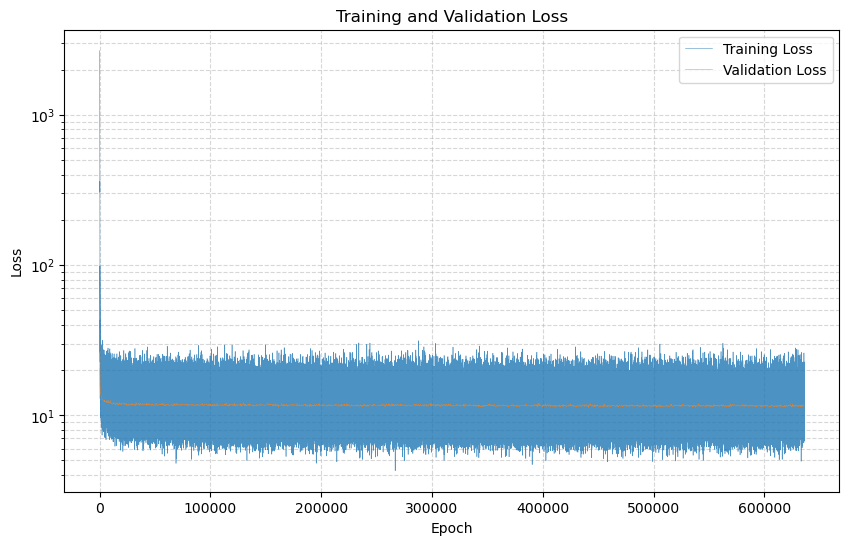

Training MSE: 8740.0498, R^2: -757517.6102
Test MSE: 8745.5381, R^2: -718026.3042


In [19]:
analyze_model_performance(model, loss_data[0], loss_data[1], train_dataloader, test_dataloader, device="cpu")

Test Set Performance:
R² Score: -1.4438
Mean Absolute Error: 5.1566
Root Mean Squared Error: 6.4770


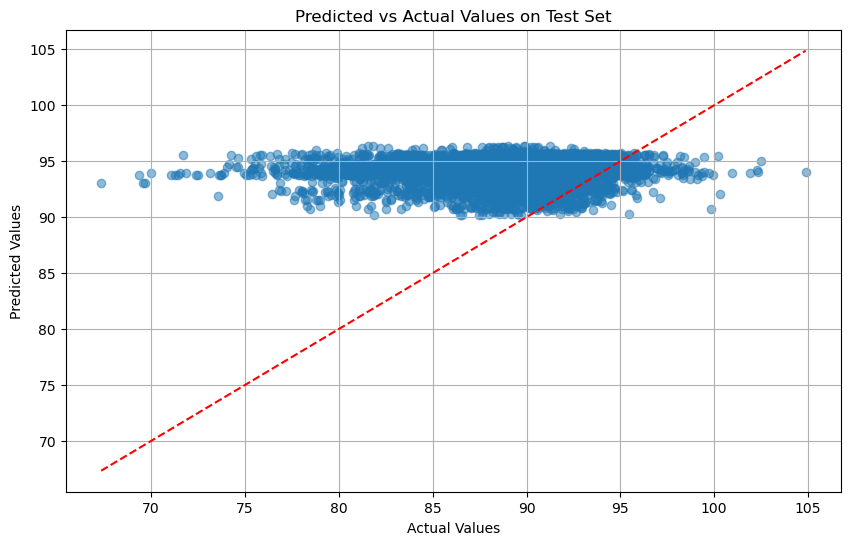

In [24]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Compute R² and loss metrics for the model on the test set

# Get predictions and actual values from the test set
y_pred, y_true = model.evaluate(test_dataloader, device="cpu")
y_true = train_dataset.denormalize_response(y_true)
# Calculate metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Test Set Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values on Test Set')
plt.grid(True)
plt.show()

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#### v1:

In [ ]:
models = []
model_names = []
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Create DataLoaders with the new EconDataset
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")
val_dataset = EconDataset(val_data, "State", "Industry", "Unemployment Rate", "Response")
input_size = len(train_dataset[0][0])
bs = 128

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

train_dataloaders.append(train_dataloader)
test_dataloaders.append(test_dataloader)
val_dataloaders.append(val_dataloader)

# 1. Basic SurvivalRateModel (Baseline)
model_basic = SurvivalRateModel(input_size=input_size, hidden_size1=256, hidden_size2=128)
models.append(model_basic)
model_names.append("Basic SurvivalRateModel")

# 2. SurvivalRateModel_Combined (Baseline)
model_combined = SurvivalRateModel_Combined(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined)
model_names.append("SurvivalRateModel_Combined")

# 3. SurvivalRateModel_Combined (No BatchNorm, LayerNorm instead)
class SurvivalRateModel_Combined_LayerNorm(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        new_layers = []
        for layer in self.layers:
            if isinstance(layer, nn.BatchNorm1d):
                new_layers.append(nn.LayerNorm(layer.num_features))
            else:
                new_layers.append(layer)
        self.layers = nn.Sequential(*new_layers)

model_combined_layer_norm = SurvivalRateModel_Combined_LayerNorm(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_layer_norm)
model_names.append("Combined LayerNorm")

# 4. SurvivalRateModel_Combined (No LeakyReLU, ReLU instead)
class SurvivalRateModel_Combined_ReLU(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        new_layers = []
        for layer in self.layers:
            if isinstance(layer, nn.LeakyReLU):
                new_layers.append(nn.ReLU())
            else:
                new_layers.append(layer)
        self.layers = nn.Sequential(*new_layers)

model_combined_relu = SurvivalRateModel_Combined_ReLU(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_relu)
model_names.append("Combined ReLU")

# 5. SurvivalRateModel_Combined (No Dropout)
class SurvivalRateModel_Combined_NoDropout(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(*[layer for layer in self.layers if not isinstance(layer, nn.Dropout)])

model_combined_no_dropout = SurvivalRateModel_Combined_NoDropout(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_no_dropout)
model_names.append("Combined No Dropout")

# 6. SurvivalRateModel_Combined (Convolutional Layers)
class SurvivalRateModel_Combined_Conv(SurvivalRateModel_Combined):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size=1, l1_lambda=0.0005, l2_lambda=0.01, noise_std=0.05, dropout_rate=0.2):
        super().__init__(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size, l1_lambda, l2_lambda, noise_std, dropout_rate)
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.fc_input_size = 32 * (input_size // 4)
        self.fc_layers = nn.Sequential(
            nn.Linear(self.fc_input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        return 100 * self.fc_layers(x)

model_combined_conv = SurvivalRateModel_Combined_Conv(input_size=input_size, hidden_size1=256, hidden_size2=128, hidden_size3=64, hidden_size4=32)
models.append(model_combined_conv)
model_names.append("Combined Conv Layers")

# 7. SurvivalRateModel_Combined (No Sigmoid)
class SurvivalRateModel_Combined_NoSigmoid(SurvivalRateModel_Combined):
    def forward(self, x):
        return self.layers[:-1](x)

model_combined_no_sigmoid = SurvivalRateModel_Combined_NoSigmoid(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_no_sigmoid)
model_names.append("Combined No Sigmoid")

# 8. SurvivalRateModel_Combined (Adding Tanh Activation)
class SurvivalRateModel_Combined_Tanh(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        new_layers = []
        for layer in self.layers:
            new_layers.append(layer)
            if isinstance(layer, nn.Linear):
                new_layers.append(nn.Tanh())
        self.layers = nn.Sequential(*new_layers[:-1]) #Remove the last Tanh before Sigmoid.

model_combined_tanh = SurvivalRateModel_Combined_Tanh(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_tanh)
model_names.append("Combined Tanh Activation")

# 9. SurvivalRateModel_Combined (No L1, No L2)
class SurvivalRateModel_Combined_NoReg(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l1_lambda = 0.0
        self.l2_lambda = 0.0

model_combined_no_reg = SurvivalRateModel_Combined_NoReg(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_no_reg)
model_names.append("Combined No Reg")


# Training and Evaluation Loop
num_epochs = 150
device = "cpu"  # or "cuda" if available

results = []

for i, model in enumerate(models):
    print(f"Training {model_names[i]}...")
    train_loss_cache, val_loss_cache = model.train_loop(
        train_dataloaders[0],  # All models use the same dataloaders
        num_epochs=num_epochs,
        learning_rate=0.001,  # Adjust learning rate if needed
        device=device,
        val_dataloader=val_dataloaders[0],
        suppress=True,
        patience=50,
    )

    y_pred, y_true = model.evaluate(test_dataloaders[0], device=device)

    # Denormalize predictions and actual values
    y_pred_denorm = train_dataset.denormalize_response(y_pred)
    y_true_denorm = train_dataset.denormalize_response(y_true)

    r2 = r2_score(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))

    results.append({
        "model_name": model_names[i],
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "y_pred": y_pred_denorm,
        "y_true": y_true_denorm,
    })

# Plotting Results
for result in results:
    print(f"Results for {result['model_name']}:")
    print(f"  R² Score: {result['r2']:.4f}")
    print(f"  Mean Absolute Error: {result['mae']:.4f}")
    print(f"  Root Mean Squared Error: {result['rmse']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(result['y_true'], result['y_pred'], alpha=0.5)
    plt.plot([min(result['y_true']), max(result['y_true'])], [min(result['y_true']), max(result['y_true'])], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f"Predicted vs Actual Values ({result['model_name']})")
    plt.grid(True)
    plt.show()

Training Basic SurvivalRateModel...


Training Epochs: 100%|██████████| 150/150 [00:56<00:00,  2.66it/s]


Training SurvivalRateModel_Combined...


Training Epochs:  56%|█████▌    | 84/150 [01:33<01:13,  1.11s/it]


Training Combined LayerNorm...


Training Epochs:  71%|███████▏  | 107/150 [01:42<00:41,  1.04it/s]


Training Combined ReLU...


Training Epochs:  57%|█████▋    | 86/150 [01:32<01:08,  1.07s/it]


Training Combined No Dropout...


Training Epochs: 100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


Training Combined Conv Layers...


Training Epochs:  73%|███████▎  | 110/150 [04:55<01:47,  2.69s/it]


Training Combined No Sigmoid...


Training Epochs:  81%|████████▏ | 122/150 [02:19<00:31,  1.14s/it]


Training Combined Tanh Activation...


Training Epochs: 100%|██████████| 150/150 [02:57<00:00,  1.18s/it]


Training Combined No Reg...


Training Epochs: 100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


Training Combined Adaptive Pool...


Training Epochs:   0%|          | 0/150 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x1 and 71x256)

#### v2:

Training Basic SurvivalRateModel...


Training Epochs: 100%|██████████| 150/150 [01:40<00:00,  1.49it/s]


Training Basic SurvivalRateModel Aggressive Regularization...


Training Epochs:  47%|████▋     | 70/150 [00:57<01:06,  1.21it/s]


Training Basic SurvivalRateModel Deep Learning...


Training Epochs:  45%|████▍     | 67/150 [00:58<01:12,  1.15it/s]


Training Combined No Reg...


Training Epochs: 100%|██████████| 150/150 [04:04<00:00,  1.63s/it]


Results for Basic SurvivalRateModel:
  R² Score: 0.1115
  Mean Absolute Error: 3.0542
  Root Mean Squared Error: 3.9055


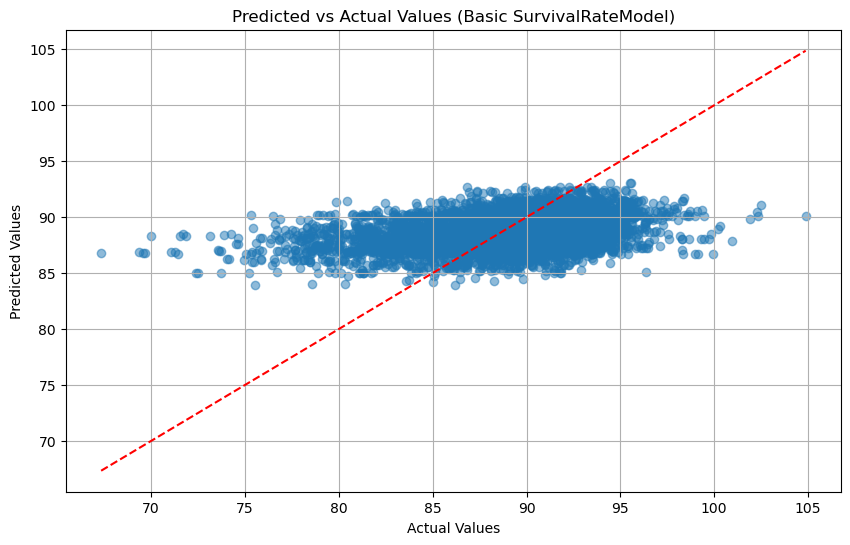

Results for Basic SurvivalRateModel Aggressive Regularization:
  R² Score: -23.1358
  Mean Absolute Error: 17.9544
  Root Mean Squared Error: 20.3550


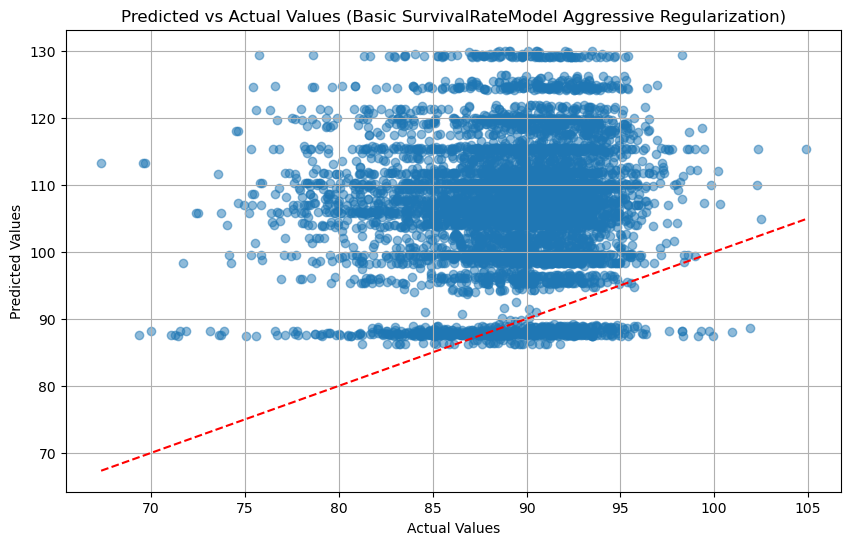

Results for Basic SurvivalRateModel Deep Learning:
  R² Score: -0.0033
  Mean Absolute Error: 3.1818
  Root Mean Squared Error: 4.1501


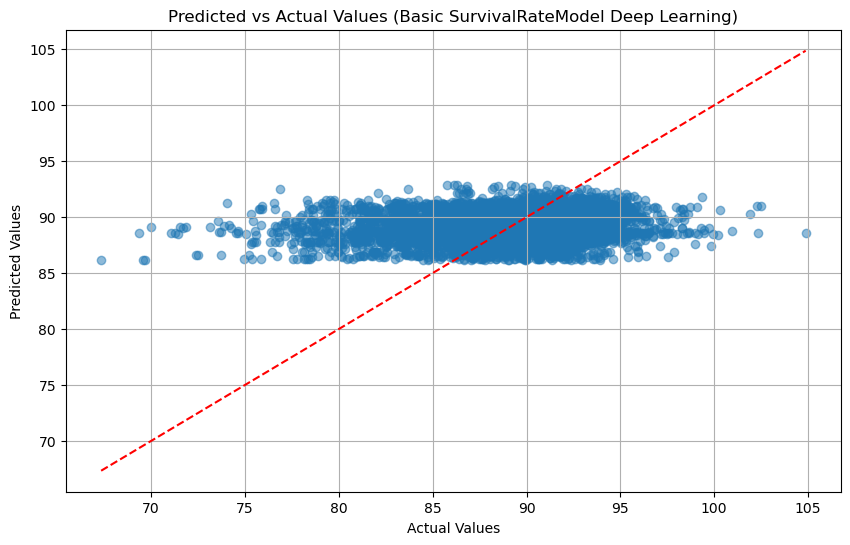

Results for Combined No Reg:
  R² Score: 0.0343
  Mean Absolute Error: 3.0462
  Root Mean Squared Error: 4.0716


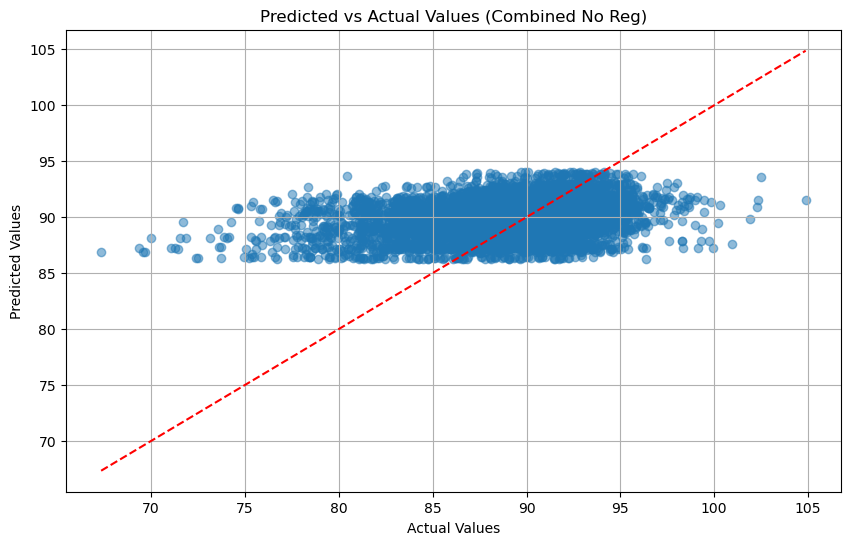

In [20]:
models = []
model_names = []
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Create DataLoaders with the new EconDataset
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")
val_dataset = EconDataset(val_data, "State", "Industry", "Unemployment Rate", "Response")
input_size = len(train_dataset[0][0])
bs = 128

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

train_dataloaders.append(train_dataloader)
test_dataloaders.append(test_dataloader)
val_dataloaders.append(val_dataloader)

# 1. Basic SurvivalRateModel (Baseline)
model_basic = SurvivalRateModel(input_size=input_size, hidden_size1=256, hidden_size2=128)
models.append(model_basic)
model_names.append("Basic SurvivalRateModel")

model_basic_agrr = SurvivalRateModel_AggressiveReg(input_size=input_size, hidden_size1=256, hidden_size2=128)
models.append(model_basic_agrr)
model_names.append("Basic SurvivalRateModel Aggressive Regularization")

model_basic_deep = SurvivalRateModel_DeepLearning(input_size=input_size, hidden_size1=256, hidden_size2=128, hidden_size3=128, hidden_size4=64)
models.append(model_basic_deep)
model_names.append("Basic SurvivalRateModel Deep Learning")

# 9. SurvivalRateModel_Combined (No L1, No L2)
class SurvivalRateModel_Combined_NoReg(SurvivalRateModel_Combined):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l1_lambda = 0.0
        self.l2_lambda = 0.0

model_combined_no_reg = SurvivalRateModel_Combined_NoReg(input_size=input_size, hidden_size1=512, hidden_size2=256, hidden_size3=128, hidden_size4=64)
models.append(model_combined_no_reg)
model_names.append("Combined No Reg")

# Training and Evaluation Loop
num_epochs = 150
device = "cpu"  # or "cuda" if available

results = []

for i, model in enumerate(models):
    print(f"Training {model_names[i]}...")
    train_loss_cache, val_loss_cache = model.train_loop(
        train_dataloaders[0],  # All models use the same dataloaders
        num_epochs=num_epochs,
        learning_rate=0.001,  # Adjust learning rate if needed
        device=device,
        val_dataloader=val_dataloaders[0],
        suppress=True,
        patience=50,
    )

    y_pred, y_true = model.evaluate(test_dataloaders[0], device=device)

    # Denormalize predictions and actual values
    y_pred_denorm = train_dataset.denormalize_response(y_pred)
    y_true_denorm = train_dataset.denormalize_response(y_true)

    r2 = r2_score(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))

    results.append({
        "model_name": model_names[i],
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "y_pred": y_pred_denorm,
        "y_true": y_true_denorm,
    })

# Plotting Results
for result in results:
    print(f"Results for {result['model_name']}:")
    print(f"  R² Score: {result['r2']:.4f}")
    print(f"  Mean Absolute Error: {result['mae']:.4f}")
    print(f"  Root Mean Squared Error: {result['rmse']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(result['y_true'], result['y_pred'], alpha=0.5)
    plt.plot([min(result['y_true']), max(result['y_true'])], [min(result['y_true']), max(result['y_true'])], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f"Predicted vs Actual Values ({result['model_name']})")
    plt.grid(True)
    plt.show()

#### v3:

Training RMSprop Optimizer...


Training Epochs:   1%|          | 1/150 [00:00<01:27,  1.71it/s]

Epoch 1/150, Train Loss: 9.0176, Val Loss: 0.0448


Training Epochs:   1%|▏         | 2/150 [00:01<01:27,  1.70it/s]

Epoch 2/150, Train Loss: 0.1184, Val Loss: 0.0375


Training Epochs:   2%|▏         | 3/150 [00:01<01:29,  1.63it/s]

Epoch 3/150, Train Loss: 0.2741, Val Loss: 0.8154


Training Epochs:   3%|▎         | 4/150 [00:02<01:26,  1.69it/s]

Epoch 4/150, Train Loss: 0.2639, Val Loss: 0.3982


Training Epochs:   3%|▎         | 5/150 [00:02<01:23,  1.74it/s]

Epoch 5/150, Train Loss: 0.1787, Val Loss: 0.0920


Training Epochs:   4%|▍         | 6/150 [00:03<01:21,  1.77it/s]

Epoch 6/150, Train Loss: 0.1400, Val Loss: 0.1047


Training Epochs:   5%|▍         | 7/150 [00:04<01:19,  1.79it/s]

Epoch 7/150, Train Loss: 0.1185, Val Loss: 0.0350


Training Epochs:   5%|▌         | 8/150 [00:04<01:18,  1.81it/s]

Epoch 8/150, Train Loss: 0.0784, Val Loss: 0.1177


Training Epochs:   6%|▌         | 9/150 [00:05<01:17,  1.82it/s]

Epoch 9/150, Train Loss: 0.0566, Val Loss: 0.0214


Training Epochs:   7%|▋         | 10/150 [00:05<01:16,  1.82it/s]

Epoch 10/150, Train Loss: 0.0461, Val Loss: 0.0853


Training Epochs:   7%|▋         | 11/150 [00:06<01:16,  1.83it/s]

Epoch 11/150, Train Loss: 0.0337, Val Loss: 0.0297


Training Epochs:   8%|▊         | 12/150 [00:06<01:15,  1.83it/s]

Epoch 12/150, Train Loss: 0.0322, Val Loss: 0.0324


Training Epochs:   9%|▊         | 13/150 [00:07<01:17,  1.77it/s]

Epoch 13/150, Train Loss: 0.0307, Val Loss: 0.0155


Training Epochs:   9%|▉         | 14/150 [00:07<01:16,  1.77it/s]

Epoch 14/150, Train Loss: 0.0293, Val Loss: 0.0561


Training Epochs:  10%|█         | 15/150 [00:08<01:15,  1.80it/s]

Epoch 15/150, Train Loss: 0.0293, Val Loss: 0.0443


Training Epochs:  11%|█         | 16/150 [00:08<01:14,  1.81it/s]

Epoch 16/150, Train Loss: 0.0275, Val Loss: 0.0182


Training Epochs:  11%|█▏        | 17/150 [00:09<01:13,  1.82it/s]

Epoch 17/150, Train Loss: 0.0319, Val Loss: 0.0198


Training Epochs:  12%|█▏        | 18/150 [00:10<01:12,  1.83it/s]

Epoch 18/150, Train Loss: 0.0256, Val Loss: 0.0172


Training Epochs:  13%|█▎        | 19/150 [00:10<01:11,  1.83it/s]

Epoch 19/150, Train Loss: 0.0310, Val Loss: 0.0209


Training Epochs:  13%|█▎        | 20/150 [00:11<01:10,  1.83it/s]

Epoch 20/150, Train Loss: 0.0275, Val Loss: 0.0239


Training Epochs:  14%|█▍        | 21/150 [00:11<01:10,  1.84it/s]

Epoch 21/150, Train Loss: 0.0264, Val Loss: 0.0179


Training Epochs:  15%|█▍        | 22/150 [00:12<01:09,  1.84it/s]

Epoch 22/150, Train Loss: 0.0293, Val Loss: 0.0259


Training Epochs:  15%|█▌        | 23/150 [00:12<01:11,  1.78it/s]

Epoch 23/150, Train Loss: 0.0250, Val Loss: 0.0176


Training Epochs:  16%|█▌        | 24/150 [00:13<01:09,  1.80it/s]

Epoch 24/150, Train Loss: 0.0260, Val Loss: 0.0195


Training Epochs:  17%|█▋        | 25/150 [00:13<01:08,  1.81it/s]

Epoch 25/150, Train Loss: 0.0260, Val Loss: 0.0421


Training Epochs:  17%|█▋        | 26/150 [00:14<01:08,  1.82it/s]

Epoch 26/150, Train Loss: 0.0263, Val Loss: 0.0150


Training Epochs:  18%|█▊        | 27/150 [00:15<01:07,  1.83it/s]

Epoch 27/150, Train Loss: 0.0226, Val Loss: 0.0194


Training Epochs:  19%|█▊        | 28/150 [00:15<01:06,  1.83it/s]

Epoch 28/150, Train Loss: 0.0265, Val Loss: 0.0323


Training Epochs:  19%|█▉        | 29/150 [00:16<01:05,  1.84it/s]

Epoch 29/150, Train Loss: 0.0232, Val Loss: 0.0579


Training Epochs:  20%|██        | 30/150 [00:16<01:05,  1.84it/s]

Epoch 30/150, Train Loss: 0.0241, Val Loss: 0.0193


Training Epochs:  21%|██        | 31/150 [00:17<01:04,  1.84it/s]

Epoch 31/150, Train Loss: 0.0232, Val Loss: 0.0211


Training Epochs:  21%|██▏       | 32/150 [00:17<01:03,  1.85it/s]

Epoch 32/150, Train Loss: 0.0232, Val Loss: 0.0173


Training Epochs:  22%|██▏       | 33/150 [00:18<01:05,  1.80it/s]

Epoch 33/150, Train Loss: 0.0227, Val Loss: 0.0635


Training Epochs:  23%|██▎       | 34/150 [00:18<01:04,  1.80it/s]

Epoch 34/150, Train Loss: 0.0237, Val Loss: 0.0219


Training Epochs:  23%|██▎       | 35/150 [00:19<01:03,  1.81it/s]

Epoch 35/150, Train Loss: 0.0208, Val Loss: 0.0165


Training Epochs:  24%|██▍       | 36/150 [00:19<01:02,  1.82it/s]

Epoch 36/150, Train Loss: 0.0205, Val Loss: 0.0480


Training Epochs:  25%|██▍       | 37/150 [00:20<01:01,  1.83it/s]

Epoch 37/150, Train Loss: 0.0205, Val Loss: 0.0560


Training Epochs:  25%|██▌       | 38/150 [00:21<01:02,  1.78it/s]

Epoch 38/150, Train Loss: 0.0190, Val Loss: 0.0168


Training Epochs:  26%|██▌       | 39/150 [00:21<01:03,  1.75it/s]

Epoch 39/150, Train Loss: 0.0204, Val Loss: 0.0149


Training Epochs:  27%|██▋       | 40/150 [00:22<01:01,  1.78it/s]

Epoch 40/150, Train Loss: 0.0192, Val Loss: 0.0172


Training Epochs:  27%|██▋       | 41/150 [00:22<01:01,  1.78it/s]

Epoch 41/150, Train Loss: 0.0197, Val Loss: 0.0149


Training Epochs:  28%|██▊       | 42/150 [00:23<01:00,  1.80it/s]

Epoch 42/150, Train Loss: 0.0188, Val Loss: 0.0204


Training Epochs:  29%|██▊       | 43/150 [00:23<01:01,  1.75it/s]

Epoch 43/150, Train Loss: 0.0184, Val Loss: 0.0386


Training Epochs:  29%|██▉       | 44/150 [00:24<00:59,  1.78it/s]

Epoch 44/150, Train Loss: 0.0187, Val Loss: 0.0166


Training Epochs:  30%|███       | 45/150 [00:25<00:58,  1.79it/s]

Epoch 45/150, Train Loss: 0.0181, Val Loss: 0.0152


Training Epochs:  31%|███       | 46/150 [00:25<00:57,  1.81it/s]

Epoch 46/150, Train Loss: 0.0184, Val Loss: 0.0156


Training Epochs:  31%|███▏      | 47/150 [00:26<00:56,  1.82it/s]

Epoch 47/150, Train Loss: 0.0170, Val Loss: 0.0162


Training Epochs:  32%|███▏      | 48/150 [00:26<00:55,  1.83it/s]

Epoch 48/150, Train Loss: 0.0168, Val Loss: 0.0173


Training Epochs:  33%|███▎      | 49/150 [00:27<00:55,  1.83it/s]

Epoch 49/150, Train Loss: 0.0179, Val Loss: 0.0270


Training Epochs:  33%|███▎      | 50/150 [00:27<00:54,  1.82it/s]

Epoch 50/150, Train Loss: 0.0172, Val Loss: 0.0247


Training Epochs:  34%|███▍      | 51/150 [00:28<00:54,  1.83it/s]

Epoch 51/150, Train Loss: 0.0156, Val Loss: 0.0161


Training Epochs:  35%|███▍      | 52/150 [00:28<00:53,  1.83it/s]

Epoch 52/150, Train Loss: 0.0166, Val Loss: 0.0224


Training Epochs:  35%|███▌      | 53/150 [00:29<00:54,  1.78it/s]

Epoch 53/150, Train Loss: 0.0162, Val Loss: 0.0148


Training Epochs:  36%|███▌      | 54/150 [00:29<00:53,  1.80it/s]

Epoch 54/150, Train Loss: 0.0158, Val Loss: 0.0254


Training Epochs:  37%|███▋      | 55/150 [00:30<00:52,  1.79it/s]

Epoch 55/150, Train Loss: 0.0151, Val Loss: 0.0205


Training Epochs:  37%|███▋      | 56/150 [00:31<00:52,  1.80it/s]

Epoch 56/150, Train Loss: 0.0150, Val Loss: 0.0245


Training Epochs:  38%|███▊      | 57/150 [00:31<00:51,  1.80it/s]

Epoch 57/150, Train Loss: 0.0155, Val Loss: 0.0185


Training Epochs:  39%|███▊      | 58/150 [00:32<00:50,  1.81it/s]

Epoch 58/150, Train Loss: 0.0152, Val Loss: 0.0195


Training Epochs:  39%|███▉      | 59/150 [00:32<00:50,  1.82it/s]

Epoch 59/150, Train Loss: 0.0142, Val Loss: 0.0168


Training Epochs:  40%|████      | 60/150 [00:33<00:49,  1.82it/s]

Epoch 60/150, Train Loss: 0.0142, Val Loss: 0.0149


Training Epochs:  41%|████      | 61/150 [00:33<00:48,  1.83it/s]

Epoch 61/150, Train Loss: 0.0141, Val Loss: 0.0184


Training Epochs:  41%|████▏     | 62/150 [00:34<00:48,  1.83it/s]

Epoch 62/150, Train Loss: 0.0139, Val Loss: 0.0179


Training Epochs:  42%|████▏     | 63/150 [00:34<00:48,  1.78it/s]

Epoch 63/150, Train Loss: 0.0142, Val Loss: 0.0164


Training Epochs:  43%|████▎     | 64/150 [00:35<00:47,  1.80it/s]

Epoch 64/150, Train Loss: 0.0141, Val Loss: 0.0229


Training Epochs:  43%|████▎     | 65/150 [00:36<00:47,  1.81it/s]

Epoch 65/150, Train Loss: 0.0136, Val Loss: 0.0161


Training Epochs:  44%|████▍     | 66/150 [00:36<00:48,  1.75it/s]

Epoch 66/150, Train Loss: 0.0135, Val Loss: 0.0154


Training Epochs:  45%|████▍     | 67/150 [00:37<00:47,  1.76it/s]

Epoch 67/150, Train Loss: 0.0141, Val Loss: 0.0187


Training Epochs:  45%|████▌     | 68/150 [00:37<00:46,  1.78it/s]

Epoch 68/150, Train Loss: 0.0132, Val Loss: 0.0210


Training Epochs:  46%|████▌     | 69/150 [00:38<00:45,  1.80it/s]

Epoch 69/150, Train Loss: 0.0135, Val Loss: 0.0147


Training Epochs:  47%|████▋     | 70/150 [00:38<00:44,  1.81it/s]

Epoch 70/150, Train Loss: 0.0130, Val Loss: 0.0254


Training Epochs:  47%|████▋     | 71/150 [00:39<00:43,  1.81it/s]

Epoch 71/150, Train Loss: 0.0134, Val Loss: 0.0213


Training Epochs:  48%|████▊     | 72/150 [00:39<00:42,  1.82it/s]

Epoch 72/150, Train Loss: 0.0133, Val Loss: 0.0171


Training Epochs:  49%|████▊     | 73/150 [00:40<00:43,  1.77it/s]

Epoch 73/150, Train Loss: 0.0132, Val Loss: 0.0164


Training Epochs:  49%|████▉     | 74/150 [00:41<00:42,  1.79it/s]

Epoch 74/150, Train Loss: 0.0134, Val Loss: 0.0181


Training Epochs:  50%|█████     | 75/150 [00:41<00:41,  1.81it/s]

Epoch 75/150, Train Loss: 0.0131, Val Loss: 0.0150


Training Epochs:  51%|█████     | 76/150 [00:42<00:40,  1.82it/s]

Epoch 76/150, Train Loss: 0.0135, Val Loss: 0.0145


Training Epochs:  51%|█████▏    | 77/150 [00:42<00:40,  1.82it/s]

Epoch 77/150, Train Loss: 0.0131, Val Loss: 0.0146


Training Epochs:  52%|█████▏    | 78/150 [00:43<00:39,  1.83it/s]

Epoch 78/150, Train Loss: 0.0133, Val Loss: 0.0143


Training Epochs:  53%|█████▎    | 79/150 [00:43<00:38,  1.83it/s]

Epoch 79/150, Train Loss: 0.0129, Val Loss: 0.0145


Training Epochs:  53%|█████▎    | 80/150 [00:44<00:38,  1.83it/s]

Epoch 80/150, Train Loss: 0.0134, Val Loss: 0.0193


Training Epochs:  54%|█████▍    | 81/150 [00:44<00:38,  1.81it/s]

Epoch 81/150, Train Loss: 0.0129, Val Loss: 0.0177


Training Epochs:  55%|█████▍    | 82/150 [00:45<00:37,  1.82it/s]

Epoch 82/150, Train Loss: 0.0131, Val Loss: 0.0303


Training Epochs:  55%|█████▌    | 83/150 [00:46<00:38,  1.76it/s]

Epoch 83/150, Train Loss: 0.0130, Val Loss: 0.0193


Training Epochs:  56%|█████▌    | 84/150 [00:46<00:37,  1.78it/s]

Epoch 84/150, Train Loss: 0.0129, Val Loss: 0.0152


Training Epochs:  57%|█████▋    | 85/150 [00:47<00:36,  1.80it/s]

Epoch 85/150, Train Loss: 0.0134, Val Loss: 0.0186


Training Epochs:  57%|█████▋    | 86/150 [00:47<00:35,  1.81it/s]

Epoch 86/150, Train Loss: 0.0131, Val Loss: 0.0154


Training Epochs:  58%|█████▊    | 87/150 [00:48<00:34,  1.82it/s]

Epoch 87/150, Train Loss: 0.0129, Val Loss: 0.0142


Training Epochs:  59%|█████▊    | 88/150 [00:48<00:33,  1.83it/s]

Epoch 88/150, Train Loss: 0.0128, Val Loss: 0.0143


Training Epochs:  59%|█████▉    | 89/150 [00:49<00:34,  1.76it/s]

Epoch 89/150, Train Loss: 0.0134, Val Loss: 0.0155


Training Epochs:  60%|██████    | 90/150 [00:49<00:33,  1.79it/s]

Epoch 90/150, Train Loss: 0.0126, Val Loss: 0.0147


Training Epochs:  61%|██████    | 91/150 [00:50<00:32,  1.80it/s]

Epoch 91/150, Train Loss: 0.0132, Val Loss: 0.0145


Training Epochs:  61%|██████▏   | 92/150 [00:51<00:32,  1.77it/s]

Epoch 92/150, Train Loss: 0.0129, Val Loss: 0.0160


Training Epochs:  62%|██████▏   | 93/150 [00:51<00:32,  1.77it/s]

Epoch 93/150, Train Loss: 0.0128, Val Loss: 0.0141


Training Epochs:  63%|██████▎   | 94/150 [00:52<00:31,  1.79it/s]

Epoch 94/150, Train Loss: 0.0130, Val Loss: 0.0387


Training Epochs:  63%|██████▎   | 95/150 [00:52<00:30,  1.81it/s]

Epoch 95/150, Train Loss: 0.0128, Val Loss: 0.0142


Training Epochs:  64%|██████▍   | 96/150 [00:53<00:29,  1.81it/s]

Epoch 96/150, Train Loss: 0.0133, Val Loss: 0.0218


Training Epochs:  65%|██████▍   | 97/150 [00:53<00:29,  1.82it/s]

Epoch 97/150, Train Loss: 0.0131, Val Loss: 0.0286


Training Epochs:  65%|██████▌   | 98/150 [00:54<00:28,  1.82it/s]

Epoch 98/150, Train Loss: 0.0125, Val Loss: 0.0227


Training Epochs:  66%|██████▌   | 99/150 [00:54<00:27,  1.83it/s]

Epoch 99/150, Train Loss: 0.0132, Val Loss: 0.0191


Training Epochs:  67%|██████▋   | 100/150 [00:55<00:27,  1.83it/s]

Epoch 100/150, Train Loss: 0.0125, Val Loss: 0.0146


Training Epochs:  67%|██████▋   | 101/150 [00:56<00:26,  1.83it/s]

Epoch 101/150, Train Loss: 0.0128, Val Loss: 0.0205


Training Epochs:  68%|██████▊   | 102/150 [00:56<00:27,  1.75it/s]

Epoch 102/150, Train Loss: 0.0128, Val Loss: 0.0161


Training Epochs:  69%|██████▊   | 103/150 [00:57<00:26,  1.78it/s]

Epoch 103/150, Train Loss: 0.0133, Val Loss: 0.0159


Training Epochs:  69%|██████▉   | 104/150 [00:57<00:25,  1.80it/s]

Epoch 104/150, Train Loss: 0.0130, Val Loss: 0.0142


Training Epochs:  70%|███████   | 105/150 [00:58<00:24,  1.81it/s]

Epoch 105/150, Train Loss: 0.0129, Val Loss: 0.0141


Training Epochs:  71%|███████   | 106/150 [00:58<00:25,  1.75it/s]

Epoch 106/150, Train Loss: 0.0127, Val Loss: 0.0142


Training Epochs:  71%|███████▏  | 107/150 [00:59<00:24,  1.78it/s]

Epoch 107/150, Train Loss: 0.0132, Val Loss: 0.0148


Training Epochs:  72%|███████▏  | 108/150 [00:59<00:23,  1.80it/s]

Epoch 108/150, Train Loss: 0.0130, Val Loss: 0.0153


Training Epochs:  73%|███████▎  | 109/150 [01:00<00:22,  1.81it/s]

Epoch 109/150, Train Loss: 0.0126, Val Loss: 0.0146


Training Epochs:  73%|███████▎  | 110/150 [01:01<00:22,  1.81it/s]

Epoch 110/150, Train Loss: 0.0128, Val Loss: 0.0142


Training Epochs:  74%|███████▍  | 111/150 [01:01<00:22,  1.74it/s]

Epoch 111/150, Train Loss: 0.0132, Val Loss: 0.0248


Training Epochs:  75%|███████▍  | 112/150 [01:02<00:21,  1.77it/s]

Epoch 112/150, Train Loss: 0.0131, Val Loss: 0.0143


Training Epochs:  75%|███████▌  | 113/150 [01:02<00:20,  1.79it/s]

Epoch 113/150, Train Loss: 0.0125, Val Loss: 0.0149


Training Epochs:  76%|███████▌  | 114/150 [01:03<00:19,  1.80it/s]

Epoch 114/150, Train Loss: 0.0129, Val Loss: 0.0154


Training Epochs:  77%|███████▋  | 115/150 [01:03<00:19,  1.81it/s]

Epoch 115/150, Train Loss: 0.0129, Val Loss: 0.0167


Training Epochs:  77%|███████▋  | 116/150 [01:04<00:18,  1.82it/s]

Epoch 116/150, Train Loss: 0.0126, Val Loss: 0.0146


Training Epochs:  78%|███████▊  | 117/150 [01:04<00:18,  1.83it/s]

Epoch 117/150, Train Loss: 0.0129, Val Loss: 0.0168


Training Epochs:  79%|███████▊  | 118/150 [01:05<00:17,  1.82it/s]

Epoch 118/150, Train Loss: 0.0130, Val Loss: 0.0185


Training Epochs:  79%|███████▉  | 119/150 [01:06<00:17,  1.82it/s]

Epoch 119/150, Train Loss: 0.0127, Val Loss: 0.0150


Training Epochs:  80%|████████  | 120/150 [01:06<00:16,  1.83it/s]

Epoch 120/150, Train Loss: 0.0127, Val Loss: 0.0257


Training Epochs:  81%|████████  | 121/150 [01:07<00:16,  1.76it/s]

Epoch 121/150, Train Loss: 0.0127, Val Loss: 0.0174


Training Epochs:  81%|████████▏ | 122/150 [01:07<00:17,  1.64it/s]

Epoch 122/150, Train Loss: 0.0130, Val Loss: 0.0162


Training Epochs:  82%|████████▏ | 123/150 [01:08<00:15,  1.69it/s]

Epoch 123/150, Train Loss: 0.0130, Val Loss: 0.0149


Training Epochs:  83%|████████▎ | 124/150 [01:09<00:15,  1.64it/s]

Epoch 124/150, Train Loss: 0.0131, Val Loss: 0.0169


Training Epochs:  83%|████████▎ | 125/150 [01:09<00:15,  1.66it/s]

Epoch 125/150, Train Loss: 0.0124, Val Loss: 0.0142


Training Epochs:  84%|████████▍ | 126/150 [01:10<00:14,  1.70it/s]

Epoch 126/150, Train Loss: 0.0133, Val Loss: 0.0142


Training Epochs:  85%|████████▍ | 127/150 [01:10<00:13,  1.73it/s]

Epoch 127/150, Train Loss: 0.0126, Val Loss: 0.0146


Training Epochs:  85%|████████▌ | 128/150 [01:11<00:12,  1.73it/s]

Epoch 128/150, Train Loss: 0.0133, Val Loss: 0.0150


Training Epochs:  86%|████████▌ | 129/150 [01:11<00:12,  1.73it/s]

Epoch 129/150, Train Loss: 0.0123, Val Loss: 0.0179


Training Epochs:  87%|████████▋ | 130/150 [01:12<00:12,  1.67it/s]

Epoch 130/150, Train Loss: 0.0129, Val Loss: 0.0154


Training Epochs:  87%|████████▋ | 131/150 [01:13<00:11,  1.68it/s]

Epoch 131/150, Train Loss: 0.0130, Val Loss: 0.0151


Training Epochs:  88%|████████▊ | 132/150 [01:13<00:10,  1.69it/s]

Epoch 132/150, Train Loss: 0.0127, Val Loss: 0.0142


Training Epochs:  89%|████████▊ | 133/150 [01:14<00:09,  1.71it/s]

Epoch 133/150, Train Loss: 0.0131, Val Loss: 0.0141


Training Epochs:  89%|████████▉ | 134/150 [01:14<00:09,  1.72it/s]

Epoch 134/150, Train Loss: 0.0127, Val Loss: 0.0142


Training Epochs:  90%|█████████ | 135/150 [01:15<00:08,  1.74it/s]

Epoch 135/150, Train Loss: 0.0127, Val Loss: 0.0150


Training Epochs:  91%|█████████ | 136/150 [01:16<00:07,  1.76it/s]

Epoch 136/150, Train Loss: 0.0127, Val Loss: 0.0193


Training Epochs:  91%|█████████▏| 137/150 [01:16<00:07,  1.77it/s]

Epoch 137/150, Train Loss: 0.0130, Val Loss: 0.0161


Training Epochs:  92%|█████████▏| 138/150 [01:17<00:06,  1.78it/s]

Epoch 138/150, Train Loss: 0.0128, Val Loss: 0.0149


Training Epochs:  93%|█████████▎| 139/150 [01:17<00:06,  1.72it/s]

Epoch 139/150, Train Loss: 0.0126, Val Loss: 0.0194


Training Epochs:  93%|█████████▎| 140/150 [01:18<00:05,  1.73it/s]

Epoch 140/150, Train Loss: 0.0128, Val Loss: 0.0173


Training Epochs:  94%|█████████▍| 141/150 [01:18<00:05,  1.76it/s]

Epoch 141/150, Train Loss: 0.0126, Val Loss: 0.0146


Training Epochs:  95%|█████████▍| 142/150 [01:19<00:04,  1.77it/s]

Epoch 142/150, Train Loss: 0.0129, Val Loss: 0.0192


Training Epochs:  95%|█████████▍| 142/150 [01:20<00:04,  1.77it/s]


Early stopping at epoch 143
Training Adagrad Optimizer...


Training Epochs:   1%|          | 1/150 [00:00<01:22,  1.82it/s]

Epoch 1/150, Train Loss: 0.5805, Val Loss: 0.0340


Training Epochs:   1%|▏         | 2/150 [00:01<01:20,  1.84it/s]

Epoch 2/150, Train Loss: 0.2006, Val Loss: 0.0267


Training Epochs:   2%|▏         | 3/150 [00:01<01:19,  1.84it/s]

Epoch 3/150, Train Loss: 0.1439, Val Loss: 0.0212


Training Epochs:   3%|▎         | 4/150 [00:02<01:19,  1.84it/s]

Epoch 4/150, Train Loss: 0.1093, Val Loss: 0.0199


Training Epochs:   3%|▎         | 5/150 [00:02<01:18,  1.84it/s]

Epoch 5/150, Train Loss: 0.0856, Val Loss: 0.0227


Training Epochs:   4%|▍         | 6/150 [00:03<01:20,  1.78it/s]

Epoch 6/150, Train Loss: 0.0720, Val Loss: 0.0184


Training Epochs:   5%|▍         | 7/150 [00:03<01:19,  1.80it/s]

Epoch 7/150, Train Loss: 0.0616, Val Loss: 0.0185


Training Epochs:   5%|▌         | 8/150 [00:04<01:18,  1.81it/s]

Epoch 8/150, Train Loss: 0.0527, Val Loss: 0.0186


Training Epochs:   6%|▌         | 9/150 [00:04<01:17,  1.82it/s]

Epoch 9/150, Train Loss: 0.0470, Val Loss: 0.0203


Training Epochs:   7%|▋         | 10/150 [00:05<01:17,  1.81it/s]

Epoch 10/150, Train Loss: 0.0433, Val Loss: 0.0173


Training Epochs:   7%|▋         | 11/150 [00:06<01:16,  1.82it/s]

Epoch 11/150, Train Loss: 0.0396, Val Loss: 0.0174


Training Epochs:   8%|▊         | 12/150 [00:06<01:15,  1.82it/s]

Epoch 12/150, Train Loss: 0.0372, Val Loss: 0.0175


Training Epochs:   9%|▊         | 13/150 [00:07<01:15,  1.81it/s]

Epoch 13/150, Train Loss: 0.0355, Val Loss: 0.0172


Training Epochs:   9%|▉         | 14/150 [00:07<01:14,  1.82it/s]

Epoch 14/150, Train Loss: 0.0330, Val Loss: 0.0173


Training Epochs:  10%|█         | 15/150 [00:08<01:16,  1.77it/s]

Epoch 15/150, Train Loss: 0.0324, Val Loss: 0.0167


Training Epochs:  11%|█         | 16/150 [00:08<01:14,  1.79it/s]

Epoch 16/150, Train Loss: 0.0303, Val Loss: 0.0168


Training Epochs:  11%|█▏        | 17/150 [00:09<01:13,  1.81it/s]

Epoch 17/150, Train Loss: 0.0287, Val Loss: 0.0184


Training Epochs:  12%|█▏        | 18/150 [00:09<01:13,  1.80it/s]

Epoch 18/150, Train Loss: 0.0280, Val Loss: 0.0169


Training Epochs:  13%|█▎        | 19/150 [00:10<01:12,  1.81it/s]

Epoch 19/150, Train Loss: 0.0271, Val Loss: 0.0182


Training Epochs:  13%|█▎        | 20/150 [00:11<01:11,  1.82it/s]

Epoch 20/150, Train Loss: 0.0263, Val Loss: 0.0180


Training Epochs:  14%|█▍        | 21/150 [00:11<01:10,  1.83it/s]

Epoch 21/150, Train Loss: 0.0257, Val Loss: 0.0167


Training Epochs:  15%|█▍        | 22/150 [00:12<01:11,  1.80it/s]

Epoch 22/150, Train Loss: 0.0248, Val Loss: 0.0166


Training Epochs:  15%|█▌        | 23/150 [00:12<01:10,  1.79it/s]

Epoch 23/150, Train Loss: 0.0245, Val Loss: 0.0167


Training Epochs:  16%|█▌        | 24/150 [00:13<01:12,  1.74it/s]

Epoch 24/150, Train Loss: 0.0237, Val Loss: 0.0178


Training Epochs:  17%|█▋        | 25/150 [00:13<01:10,  1.77it/s]

Epoch 25/150, Train Loss: 0.0235, Val Loss: 0.0172


Training Epochs:  17%|█▋        | 26/150 [00:14<01:09,  1.78it/s]

Epoch 26/150, Train Loss: 0.0228, Val Loss: 0.0174


Training Epochs:  18%|█▊        | 27/150 [00:14<01:08,  1.79it/s]

Epoch 27/150, Train Loss: 0.0225, Val Loss: 0.0170


Training Epochs:  19%|█▊        | 28/150 [00:15<01:08,  1.78it/s]

Epoch 28/150, Train Loss: 0.0216, Val Loss: 0.0164


Training Epochs:  19%|█▉        | 29/150 [00:16<01:07,  1.80it/s]

Epoch 29/150, Train Loss: 0.0213, Val Loss: 0.0163


Training Epochs:  20%|██        | 30/150 [00:16<01:06,  1.81it/s]

Epoch 30/150, Train Loss: 0.0214, Val Loss: 0.0166


Training Epochs:  21%|██        | 31/150 [00:17<01:05,  1.82it/s]

Epoch 31/150, Train Loss: 0.0209, Val Loss: 0.0167


Training Epochs:  21%|██▏       | 32/150 [00:17<01:04,  1.82it/s]

Epoch 32/150, Train Loss: 0.0207, Val Loss: 0.0166


Training Epochs:  22%|██▏       | 33/150 [00:18<01:08,  1.71it/s]

Epoch 33/150, Train Loss: 0.0203, Val Loss: 0.0166


Training Epochs:  23%|██▎       | 34/150 [00:18<01:08,  1.70it/s]

Epoch 34/150, Train Loss: 0.0199, Val Loss: 0.0161


Training Epochs:  23%|██▎       | 35/150 [00:19<01:07,  1.70it/s]

Epoch 35/150, Train Loss: 0.0194, Val Loss: 0.0160


Training Epochs:  24%|██▍       | 36/150 [00:20<01:05,  1.75it/s]

Epoch 36/150, Train Loss: 0.0194, Val Loss: 0.0164


Training Epochs:  25%|██▍       | 37/150 [00:20<01:03,  1.78it/s]

Epoch 37/150, Train Loss: 0.0188, Val Loss: 0.0186


Training Epochs:  25%|██▌       | 38/150 [00:21<01:03,  1.78it/s]

Epoch 38/150, Train Loss: 0.0191, Val Loss: 0.0161


Training Epochs:  26%|██▌       | 39/150 [00:21<01:01,  1.79it/s]

Epoch 39/150, Train Loss: 0.0188, Val Loss: 0.0165


Training Epochs:  27%|██▋       | 40/150 [00:22<01:00,  1.81it/s]

Epoch 40/150, Train Loss: 0.0184, Val Loss: 0.0172


Training Epochs:  27%|██▋       | 41/150 [00:23<01:04,  1.68it/s]

Epoch 41/150, Train Loss: 0.0179, Val Loss: 0.0159


Training Epochs:  28%|██▊       | 42/150 [00:23<01:02,  1.72it/s]

Epoch 42/150, Train Loss: 0.0181, Val Loss: 0.0173


Training Epochs:  29%|██▊       | 43/150 [00:24<01:00,  1.76it/s]

Epoch 43/150, Train Loss: 0.0178, Val Loss: 0.0161


Training Epochs:  29%|██▉       | 44/150 [00:24<00:59,  1.79it/s]

Epoch 44/150, Train Loss: 0.0177, Val Loss: 0.0164


Training Epochs:  30%|███       | 45/150 [00:25<00:58,  1.79it/s]

Epoch 45/150, Train Loss: 0.0173, Val Loss: 0.0157


Training Epochs:  31%|███       | 46/150 [00:25<00:58,  1.79it/s]

Epoch 46/150, Train Loss: 0.0170, Val Loss: 0.0157


Training Epochs:  31%|███▏      | 47/150 [00:26<00:57,  1.80it/s]

Epoch 47/150, Train Loss: 0.0173, Val Loss: 0.0157


Training Epochs:  32%|███▏      | 48/150 [00:26<00:56,  1.81it/s]

Epoch 48/150, Train Loss: 0.0170, Val Loss: 0.0164


Training Epochs:  33%|███▎      | 49/150 [00:27<00:57,  1.77it/s]

Epoch 49/150, Train Loss: 0.0169, Val Loss: 0.0167


Training Epochs:  33%|███▎      | 50/150 [00:27<00:56,  1.78it/s]

Epoch 50/150, Train Loss: 0.0164, Val Loss: 0.0158


Training Epochs:  34%|███▍      | 51/150 [00:28<00:55,  1.80it/s]

Epoch 51/150, Train Loss: 0.0163, Val Loss: 0.0173


Training Epochs:  35%|███▍      | 52/150 [00:29<00:54,  1.80it/s]

Epoch 52/150, Train Loss: 0.0161, Val Loss: 0.0162


Training Epochs:  35%|███▌      | 53/150 [00:29<00:52,  1.83it/s]

Epoch 53/150, Train Loss: 0.0162, Val Loss: 0.0173


Training Epochs:  36%|███▌      | 54/150 [00:30<00:52,  1.83it/s]

Epoch 54/150, Train Loss: 0.0159, Val Loss: 0.0176


Training Epochs:  37%|███▋      | 55/150 [00:30<00:51,  1.84it/s]

Epoch 55/150, Train Loss: 0.0158, Val Loss: 0.0158


Training Epochs:  37%|███▋      | 56/150 [00:31<00:51,  1.84it/s]

Epoch 56/150, Train Loss: 0.0158, Val Loss: 0.0174


Training Epochs:  38%|███▊      | 57/150 [00:31<00:50,  1.84it/s]

Epoch 57/150, Train Loss: 0.0158, Val Loss: 0.0154


Training Epochs:  39%|███▊      | 58/150 [00:32<00:54,  1.69it/s]

Epoch 58/150, Train Loss: 0.0156, Val Loss: 0.0169


Training Epochs:  39%|███▉      | 59/150 [00:33<00:53,  1.69it/s]

Epoch 59/150, Train Loss: 0.0154, Val Loss: 0.0161


Training Epochs:  40%|████      | 60/150 [00:33<00:51,  1.73it/s]

Epoch 60/150, Train Loss: 0.0154, Val Loss: 0.0163


Training Epochs:  41%|████      | 61/150 [00:34<00:50,  1.76it/s]

Epoch 61/150, Train Loss: 0.0152, Val Loss: 0.0155


Training Epochs:  41%|████▏     | 62/150 [00:34<00:49,  1.79it/s]

Epoch 62/150, Train Loss: 0.0150, Val Loss: 0.0173


Training Epochs:  42%|████▏     | 63/150 [00:35<00:49,  1.76it/s]

Epoch 63/150, Train Loss: 0.0153, Val Loss: 0.0166


Training Epochs:  43%|████▎     | 64/150 [00:35<00:47,  1.80it/s]

Epoch 64/150, Train Loss: 0.0149, Val Loss: 0.0168


Training Epochs:  43%|████▎     | 65/150 [00:36<00:46,  1.82it/s]

Epoch 65/150, Train Loss: 0.0150, Val Loss: 0.0159


Training Epochs:  44%|████▍     | 66/150 [00:36<00:47,  1.76it/s]

Epoch 66/150, Train Loss: 0.0148, Val Loss: 0.0159


Training Epochs:  45%|████▍     | 67/150 [00:37<00:46,  1.79it/s]

Epoch 67/150, Train Loss: 0.0146, Val Loss: 0.0162


Training Epochs:  45%|████▌     | 68/150 [00:38<00:45,  1.81it/s]

Epoch 68/150, Train Loss: 0.0148, Val Loss: 0.0173


Training Epochs:  46%|████▌     | 69/150 [00:38<00:46,  1.74it/s]

Epoch 69/150, Train Loss: 0.0144, Val Loss: 0.0177


Training Epochs:  47%|████▋     | 70/150 [00:39<00:45,  1.78it/s]

Epoch 70/150, Train Loss: 0.0142, Val Loss: 0.0156


Training Epochs:  47%|████▋     | 71/150 [00:39<00:43,  1.80it/s]

Epoch 71/150, Train Loss: 0.0144, Val Loss: 0.0158


Training Epochs:  48%|████▊     | 72/150 [00:40<00:43,  1.81it/s]

Epoch 72/150, Train Loss: 0.0144, Val Loss: 0.0159


Training Epochs:  49%|████▊     | 73/150 [00:40<00:42,  1.82it/s]

Epoch 73/150, Train Loss: 0.0142, Val Loss: 0.0163


Training Epochs:  49%|████▉     | 74/150 [00:41<00:42,  1.78it/s]

Epoch 74/150, Train Loss: 0.0142, Val Loss: 0.0158


Training Epochs:  50%|█████     | 75/150 [00:41<00:41,  1.80it/s]

Epoch 75/150, Train Loss: 0.0141, Val Loss: 0.0173


Training Epochs:  51%|█████     | 76/150 [00:42<00:40,  1.82it/s]

Epoch 76/150, Train Loss: 0.0139, Val Loss: 0.0174


Training Epochs:  51%|█████▏    | 77/150 [00:43<00:41,  1.77it/s]

Epoch 77/150, Train Loss: 0.0140, Val Loss: 0.0162


Training Epochs:  52%|█████▏    | 78/150 [00:43<00:44,  1.60it/s]

Epoch 78/150, Train Loss: 0.0138, Val Loss: 0.0169


Training Epochs:  53%|█████▎    | 79/150 [00:44<00:42,  1.65it/s]

Epoch 79/150, Train Loss: 0.0137, Val Loss: 0.0156


Training Epochs:  53%|█████▎    | 80/150 [00:45<00:42,  1.66it/s]

Epoch 80/150, Train Loss: 0.0136, Val Loss: 0.0157


Training Epochs:  54%|█████▍    | 81/150 [00:45<00:40,  1.71it/s]

Epoch 81/150, Train Loss: 0.0137, Val Loss: 0.0188


Training Epochs:  55%|█████▍    | 82/150 [00:46<00:38,  1.76it/s]

Epoch 82/150, Train Loss: 0.0135, Val Loss: 0.0166


Training Epochs:  55%|█████▌    | 83/150 [00:46<00:42,  1.59it/s]

Epoch 83/150, Train Loss: 0.0135, Val Loss: 0.0167


Training Epochs:  56%|█████▌    | 84/150 [00:47<00:44,  1.48it/s]

Epoch 84/150, Train Loss: 0.0137, Val Loss: 0.0156


Training Epochs:  57%|█████▋    | 85/150 [00:48<00:43,  1.50it/s]

Epoch 85/150, Train Loss: 0.0134, Val Loss: 0.0163


Training Epochs:  57%|█████▋    | 86/150 [00:48<00:40,  1.59it/s]

Epoch 86/150, Train Loss: 0.0136, Val Loss: 0.0159


Training Epochs:  58%|█████▊    | 87/150 [00:49<00:37,  1.66it/s]

Epoch 87/150, Train Loss: 0.0134, Val Loss: 0.0162


Training Epochs:  59%|█████▊    | 88/150 [00:49<00:35,  1.73it/s]

Epoch 88/150, Train Loss: 0.0133, Val Loss: 0.0160


Training Epochs:  59%|█████▉    | 89/150 [00:50<00:35,  1.72it/s]

Epoch 89/150, Train Loss: 0.0133, Val Loss: 0.0162


Training Epochs:  60%|██████    | 90/150 [00:51<00:37,  1.60it/s]

Epoch 90/150, Train Loss: 0.0132, Val Loss: 0.0152


Training Epochs:  61%|██████    | 91/150 [00:51<00:38,  1.55it/s]

Epoch 91/150, Train Loss: 0.0132, Val Loss: 0.0164


Training Epochs:  61%|██████▏   | 92/150 [00:52<00:35,  1.64it/s]

Epoch 92/150, Train Loss: 0.0132, Val Loss: 0.0154


Training Epochs:  62%|██████▏   | 93/150 [00:52<00:33,  1.71it/s]

Epoch 93/150, Train Loss: 0.0130, Val Loss: 0.0156


Training Epochs:  63%|██████▎   | 94/150 [00:53<00:31,  1.76it/s]

Epoch 94/150, Train Loss: 0.0130, Val Loss: 0.0178


Training Epochs:  63%|██████▎   | 95/150 [00:54<00:30,  1.80it/s]

Epoch 95/150, Train Loss: 0.0131, Val Loss: 0.0182


Training Epochs:  64%|██████▍   | 96/150 [00:54<00:29,  1.82it/s]

Epoch 96/150, Train Loss: 0.0130, Val Loss: 0.0156


Training Epochs:  65%|██████▍   | 97/150 [00:55<00:28,  1.84it/s]

Epoch 97/150, Train Loss: 0.0130, Val Loss: 0.0153


Training Epochs:  65%|██████▌   | 98/150 [00:55<00:28,  1.86it/s]

Epoch 98/150, Train Loss: 0.0129, Val Loss: 0.0165


Training Epochs:  66%|██████▌   | 99/150 [00:56<00:27,  1.86it/s]

Epoch 99/150, Train Loss: 0.0129, Val Loss: 0.0156


Training Epochs:  67%|██████▋   | 100/150 [00:56<00:26,  1.85it/s]

Epoch 100/150, Train Loss: 0.0130, Val Loss: 0.0160


Training Epochs:  67%|██████▋   | 101/150 [00:57<00:26,  1.86it/s]

Epoch 101/150, Train Loss: 0.0129, Val Loss: 0.0165


Training Epochs:  68%|██████▊   | 102/150 [00:57<00:25,  1.87it/s]

Epoch 102/150, Train Loss: 0.0128, Val Loss: 0.0163


Training Epochs:  69%|██████▊   | 103/150 [00:58<00:25,  1.87it/s]

Epoch 103/150, Train Loss: 0.0128, Val Loss: 0.0156


Training Epochs:  69%|██████▉   | 104/150 [00:58<00:24,  1.88it/s]

Epoch 104/150, Train Loss: 0.0128, Val Loss: 0.0183


Training Epochs:  70%|███████   | 105/150 [00:59<00:23,  1.88it/s]

Epoch 105/150, Train Loss: 0.0127, Val Loss: 0.0165


Training Epochs:  71%|███████   | 106/150 [00:59<00:24,  1.81it/s]

Epoch 106/150, Train Loss: 0.0127, Val Loss: 0.0154


Training Epochs:  71%|███████▏  | 107/150 [01:00<00:24,  1.79it/s]

Epoch 107/150, Train Loss: 0.0125, Val Loss: 0.0155


Training Epochs:  72%|███████▏  | 108/150 [01:01<00:23,  1.81it/s]

Epoch 108/150, Train Loss: 0.0127, Val Loss: 0.0167


Training Epochs:  73%|███████▎  | 109/150 [01:01<00:22,  1.83it/s]

Epoch 109/150, Train Loss: 0.0125, Val Loss: 0.0153


Training Epochs:  73%|███████▎  | 110/150 [01:02<00:21,  1.85it/s]

Epoch 110/150, Train Loss: 0.0125, Val Loss: 0.0162


Training Epochs:  74%|███████▍  | 111/150 [01:02<00:22,  1.73it/s]

Epoch 111/150, Train Loss: 0.0125, Val Loss: 0.0165


Training Epochs:  75%|███████▍  | 112/150 [01:03<00:21,  1.78it/s]

Epoch 112/150, Train Loss: 0.0125, Val Loss: 0.0164


Training Epochs:  75%|███████▌  | 113/150 [01:03<00:20,  1.81it/s]

Epoch 113/150, Train Loss: 0.0125, Val Loss: 0.0159


Training Epochs:  76%|███████▌  | 114/150 [01:04<00:19,  1.84it/s]

Epoch 114/150, Train Loss: 0.0125, Val Loss: 0.0152


Training Epochs:  77%|███████▋  | 115/150 [01:04<00:18,  1.85it/s]

Epoch 115/150, Train Loss: 0.0124, Val Loss: 0.0171


Training Epochs:  77%|███████▋  | 116/150 [01:05<00:18,  1.86it/s]

Epoch 116/150, Train Loss: 0.0124, Val Loss: 0.0154


Training Epochs:  78%|███████▊  | 117/150 [01:05<00:17,  1.87it/s]

Epoch 117/150, Train Loss: 0.0126, Val Loss: 0.0169


Training Epochs:  79%|███████▊  | 118/150 [01:06<00:17,  1.88it/s]

Epoch 118/150, Train Loss: 0.0124, Val Loss: 0.0159


Training Epochs:  79%|███████▉  | 119/150 [01:06<00:16,  1.88it/s]

Epoch 119/150, Train Loss: 0.0122, Val Loss: 0.0159


Training Epochs:  80%|████████  | 120/150 [01:07<00:15,  1.88it/s]

Epoch 120/150, Train Loss: 0.0123, Val Loss: 0.0157


Training Epochs:  81%|████████  | 121/150 [01:08<00:15,  1.88it/s]

Epoch 121/150, Train Loss: 0.0123, Val Loss: 0.0161


Training Epochs:  81%|████████▏ | 122/150 [01:08<00:14,  1.88it/s]

Epoch 122/150, Train Loss: 0.0121, Val Loss: 0.0159


Training Epochs:  82%|████████▏ | 123/150 [01:09<00:14,  1.88it/s]

Epoch 123/150, Train Loss: 0.0123, Val Loss: 0.0153


Training Epochs:  83%|████████▎ | 124/150 [01:09<00:13,  1.88it/s]

Epoch 124/150, Train Loss: 0.0122, Val Loss: 0.0160


Training Epochs:  83%|████████▎ | 125/150 [01:10<00:13,  1.88it/s]

Epoch 125/150, Train Loss: 0.0122, Val Loss: 0.0152


Training Epochs:  84%|████████▍ | 126/150 [01:10<00:12,  1.89it/s]

Epoch 126/150, Train Loss: 0.0121, Val Loss: 0.0161


Training Epochs:  85%|████████▍ | 127/150 [01:11<00:12,  1.88it/s]

Epoch 127/150, Train Loss: 0.0122, Val Loss: 0.0170


Training Epochs:  85%|████████▌ | 128/150 [01:11<00:11,  1.88it/s]

Epoch 128/150, Train Loss: 0.0122, Val Loss: 0.0164


Training Epochs:  86%|████████▌ | 129/150 [01:12<00:11,  1.89it/s]

Epoch 129/150, Train Loss: 0.0121, Val Loss: 0.0156


Training Epochs:  87%|████████▋ | 130/150 [01:12<00:10,  1.89it/s]

Epoch 130/150, Train Loss: 0.0121, Val Loss: 0.0160


Training Epochs:  87%|████████▋ | 131/150 [01:13<00:10,  1.88it/s]

Epoch 131/150, Train Loss: 0.0121, Val Loss: 0.0170


Training Epochs:  88%|████████▊ | 132/150 [01:13<00:09,  1.87it/s]

Epoch 132/150, Train Loss: 0.0121, Val Loss: 0.0165


Training Epochs:  89%|████████▊ | 133/150 [01:14<00:09,  1.88it/s]

Epoch 133/150, Train Loss: 0.0120, Val Loss: 0.0156


Training Epochs:  89%|████████▉ | 134/150 [01:14<00:08,  1.88it/s]

Epoch 134/150, Train Loss: 0.0120, Val Loss: 0.0162


Training Epochs:  90%|█████████ | 135/150 [01:15<00:08,  1.87it/s]

Epoch 135/150, Train Loss: 0.0121, Val Loss: 0.0164


Training Epochs:  91%|█████████ | 136/150 [01:16<00:07,  1.87it/s]

Epoch 136/150, Train Loss: 0.0120, Val Loss: 0.0154


Training Epochs:  91%|█████████▏| 137/150 [01:16<00:06,  1.87it/s]

Epoch 137/150, Train Loss: 0.0121, Val Loss: 0.0160


Training Epochs:  92%|█████████▏| 138/150 [01:17<00:06,  1.88it/s]

Epoch 138/150, Train Loss: 0.0119, Val Loss: 0.0158


Training Epochs:  93%|█████████▎| 139/150 [01:17<00:05,  1.88it/s]

Epoch 139/150, Train Loss: 0.0119, Val Loss: 0.0159


Training Epochs:  93%|█████████▎| 139/150 [01:18<00:06,  1.78it/s]

Early stopping at epoch 140
Results for Baseline SurvivalRateModel:
  R² Score: 0.1502
  Mean Absolute Error: 2.8579
  Root Mean Squared Error: 3.8194


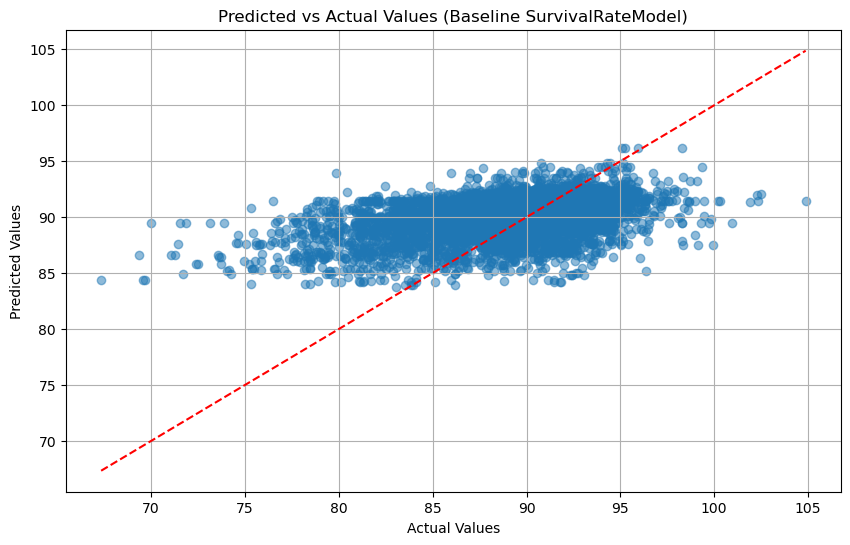

Results for One Layer No Sigmoid:
  R² Score: 0.1631
  Mean Absolute Error: 2.9147
  Root Mean Squared Error: 3.7903


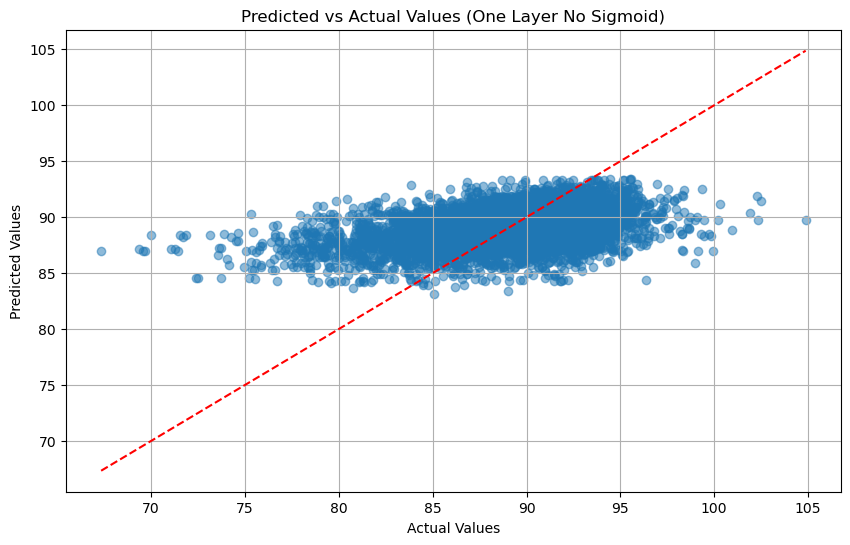

Results for Deep Narrow No Sigmoid:
  R² Score: 0.1458
  Mean Absolute Error: 2.9543
  Root Mean Squared Error: 3.8294


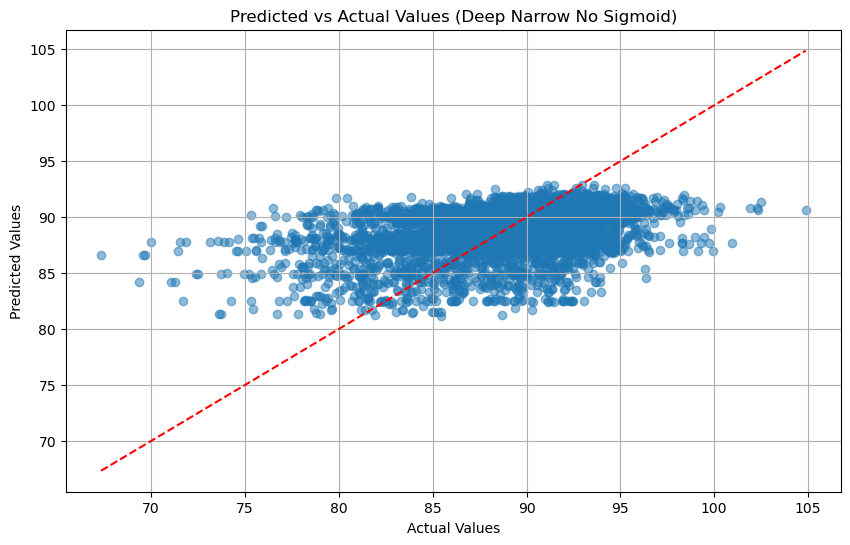

Results for Modified Sigmoid (65-100):
  R² Score: -340701.4079
  Mean Absolute Error: 2418.3936
  Root Mean Squared Error: 2418.3970


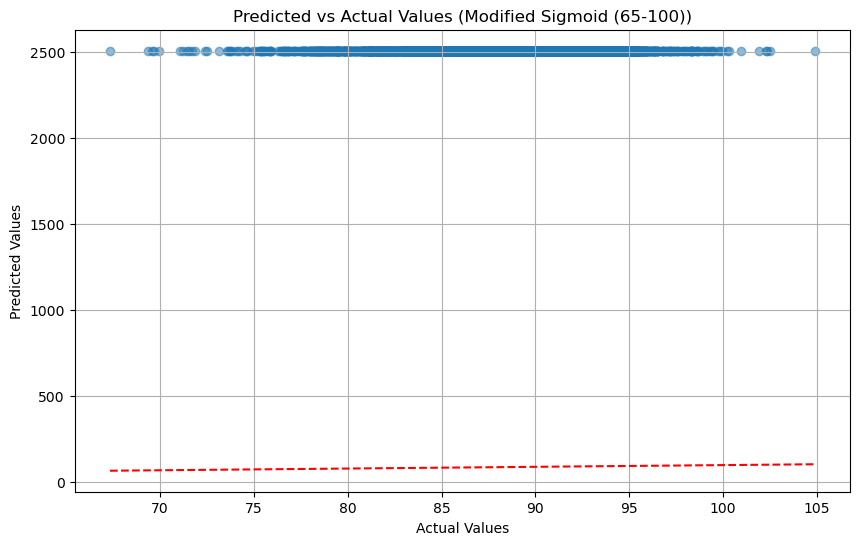

Results for Breadth Loss Model:
  R² Score: 0.1843
  Mean Absolute Error: 2.8578
  Root Mean Squared Error: 3.7419


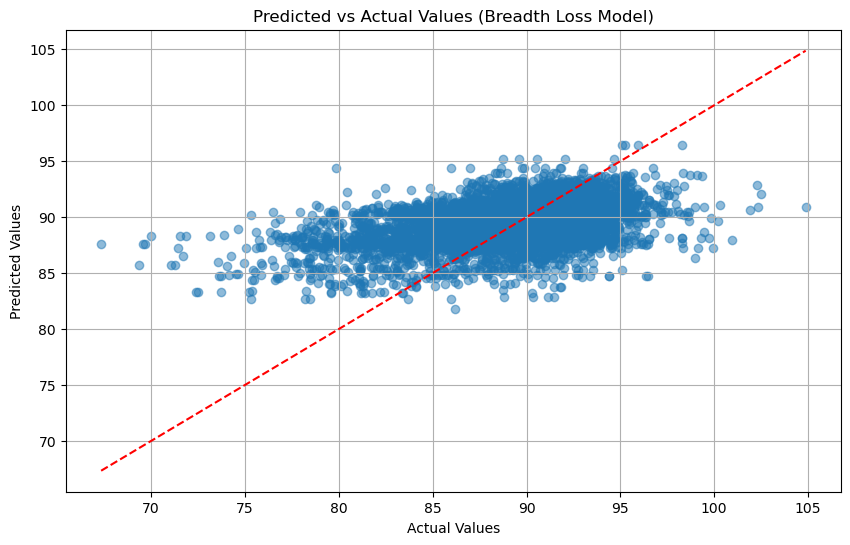

Results for LR Scheduler Model:
  R² Score: 0.1567
  Mean Absolute Error: 2.8721
  Root Mean Squared Error: 3.8049


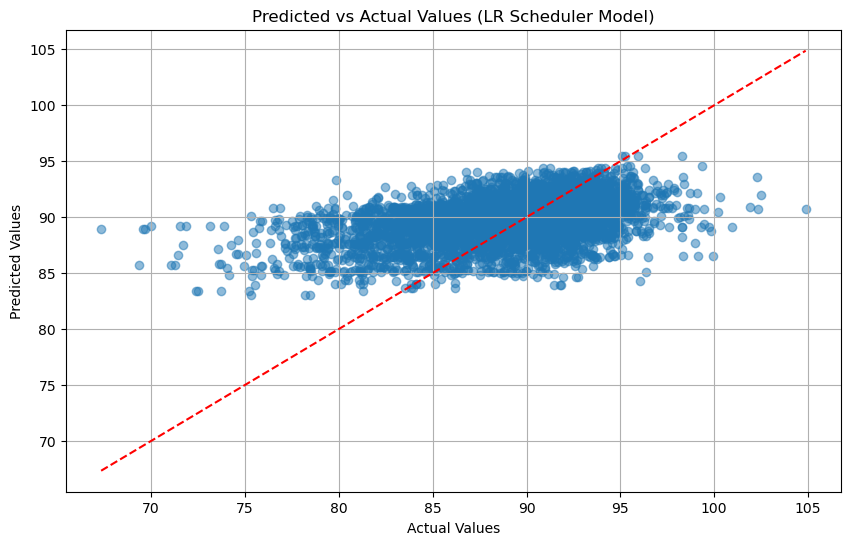

Results for RMSprop Optimizer:
  R² Score: 0.1107
  Mean Absolute Error: 2.9254
  Root Mean Squared Error: 3.9071


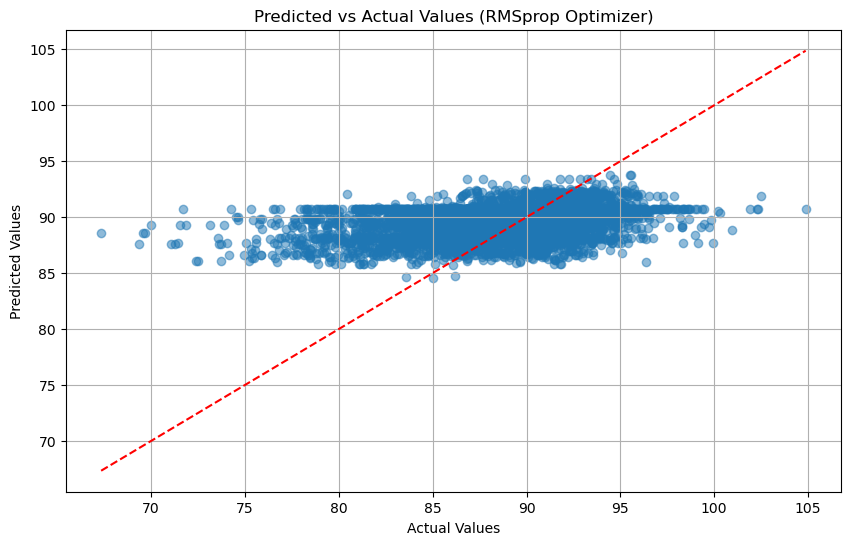

Results for Adagrad Optimizer:
  R² Score: 0.0700
  Mean Absolute Error: 3.0434
  Root Mean Squared Error: 3.9957


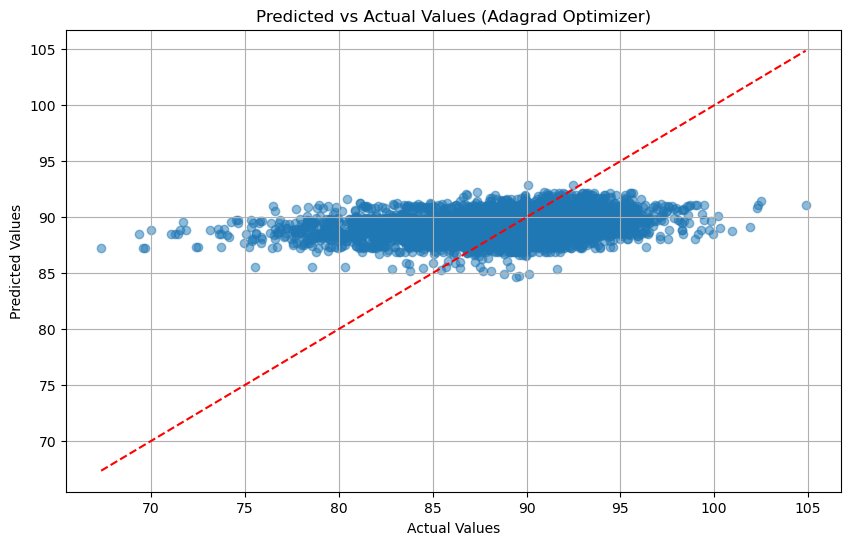

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

models = []
model_names = []
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Create DataLoaders with the new EconDataset
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")
val_dataset = EconDataset(val_data, "State", "Industry", "Unemployment Rate", "Response")
input_size = len(train_dataset[0][0])
bs = 128

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

train_dataloaders.append(train_dataloader)
test_dataloaders.append(test_dataloader)
val_dataloaders.append(val_dataloader)

# 1. Baseline SurvivalRateModel
model_baseline = SurvivalRateModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_baseline)
model_names.append("Baseline SurvivalRateModel")

# 2. One Hidden Layer, No Sigmoid
class OneLayerModel(SurvivalRateModel):
    def __init__(self, input_size, hidden_size):
        super().__init__(input_size, hidden_size, hidden_size, dropout=0)
        self.layers =nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 1))


    def forward(self, x):
        return self.layers(x)

model_one_layer = OneLayerModel(input_size=input_size, hidden_size=128)
models.append(model_one_layer)
model_names.append("One Layer No Sigmoid")

# 3. Many Layers, Small Hidden Sizes, No Sigmoid
class DeepNarrowModel(SurvivalRateModel):
    def __init__(self, input_size, hidden_size=8, num_layers=5):
        super().__init__(input_size, hidden_size, hidden_size, dropout=0)
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        layers.append(nn.Linear(hidden_size, 1))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

model_deep_narrow = DeepNarrowModel(input_size=input_size)
models.append(model_deep_narrow)
model_names.append("Deep Narrow No Sigmoid")

# 4. Modified Sigmoid Output (65-100)
class ModifiedSigmoidModel(SurvivalRateModel):
    def forward(self, x):
        return 65 + 35 * torch.sigmoid(self.layers(x))

model_modified_sigmoid = ModifiedSigmoidModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_modified_sigmoid)
model_names.append("Modified Sigmoid (65-100)")

# 5. Breadth Loss Model
class BreadthLossModel(SurvivalRateModel):
    def train_step(self, x, y, criterion, optimizer, breadth_lambda=0.01):
        optimizer.zero_grad()
        outputs = self(x)
        loss = criterion(outputs, y)
        breadth_loss = -torch.std(outputs)
        total_loss = loss + breadth_lambda * breadth_loss
        total_loss.backward()
        optimizer.step()
        return total_loss.item()

    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.001, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False, optimizer=None, breadth_lambda=0.01):
        return super().train_loop(dataloader, num_epochs, learning_rate, device=device, suppress=suppress, optimizer=optimizer, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb)

model_breadth_loss = BreadthLossModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_breadth_loss)
model_names.append("Breadth Loss Model")

# 6. Learning Rate Scheduler
class LRSchedulerModel(SurvivalRateModel):
    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.001, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False, gamma=0.95):
        self.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
        train_loss_cache, val_loss_cache = super().train_loop(dataloader, num_epochs, learning_rate, device=device, suppress=suppress, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb)
        for epoch in range(len(train_loss_cache)):
            scheduler.step()
        return train_loss_cache, val_loss_cache

model_lr_scheduler = LRSchedulerModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_lr_scheduler)
model_names.append("LR Scheduler Model")

# 7. Optimizer: SGD
class SGDModel(SurvivalRateModel):
    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.01, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False):
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        return super().train_loop(dataloader, num_epochs, learning_rate, device=device, suppress=suppress, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb, optimizer=optimizer)

model_sgd = SGDModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_sgd)
model_names.append("SGD Optimizer")

# 8. Optimizer: RMSprop
class RMSpropModel(SurvivalRateModel):
    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.001, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False):
        optimizer = optim.RMSprop(self.parameters(), lr=learning_rate)
        return super().train_loop(dataloader=dataloader, num_epochs=num_epochs, learning_rate=learning_rate, device=device, suppress=suppress, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb, optimizer=optimizer)

model_rmsprop = RMSpropModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_rmsprop)
model_names.append("RMSprop Optimizer")

# 9. Optimizer: Adagrad
class AdagradModel(SurvivalRateModel):
    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.01, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False):
        optimizer = optim.Adagrad(self.parameters(), lr=learning_rate)
        return super().train_loop(dataloader=dataloader, num_epochs=num_epochs, learning_rate=learning_rate, device=device, suppress=suppress, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb, optimizer=optimizer)

model_adagrad = AdagradModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_adagrad)
model_names.append("Adagrad Optimizer")

# Training and Evaluation Loop (same as before)
num_epochs = 150
device = "cpu"

# results = []

for i, model in enumerate(models):
    if i < 7:
        continue
    print(f"Training {model_names[i]}...")
    if isinstance(model, BreadthLossModel):
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=True,
            patience=50,
            breadth_lambda=0.01  # Pass breadth_lambda for BreadthLossModel
        )
    elif isinstance(model, LRSchedulerModel):
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=True,
            patience=50,
            gamma=0.95  # Pass gamma for LRSchedulerModel
        )
    else:
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=False,
            patience=50,
        )

    y_pred, y_true = model.evaluate(test_dataloaders[0], device=device)

    # Denormalize predictions and actual values
    y_pred_denorm = train_dataset.denormalize_response(y_pred)
    y_true_denorm = train_dataset.denormalize_response(y_true)

    r2 = r2_score(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))

    results.append({
        "model_name": model_names[i],
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "y_pred": y_pred_denorm,
        "y_true": y_true_denorm,
    })


Results for Baseline SurvivalRateModel:
  R² Score: 0.1502
  Mean Absolute Error: 2.8579
  Root Mean Squared Error: 3.8194


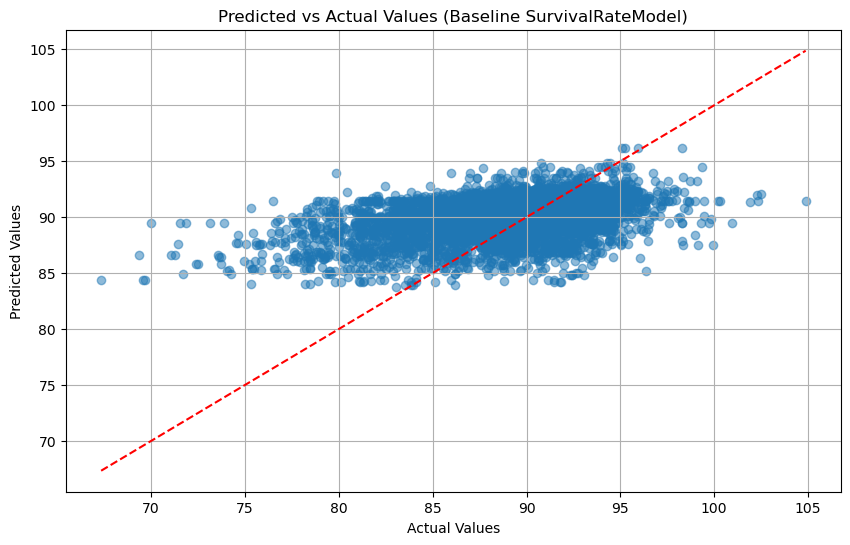

Results for One Layer No Sigmoid:
  R² Score: 0.1631
  Mean Absolute Error: 2.9147
  Root Mean Squared Error: 3.7903


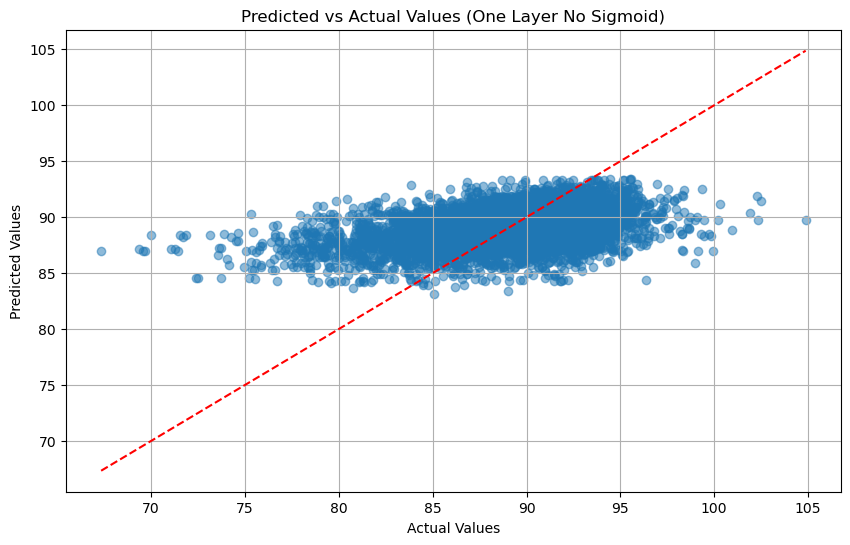

Results for Deep Narrow No Sigmoid:
  R² Score: 0.1458
  Mean Absolute Error: 2.9543
  Root Mean Squared Error: 3.8294


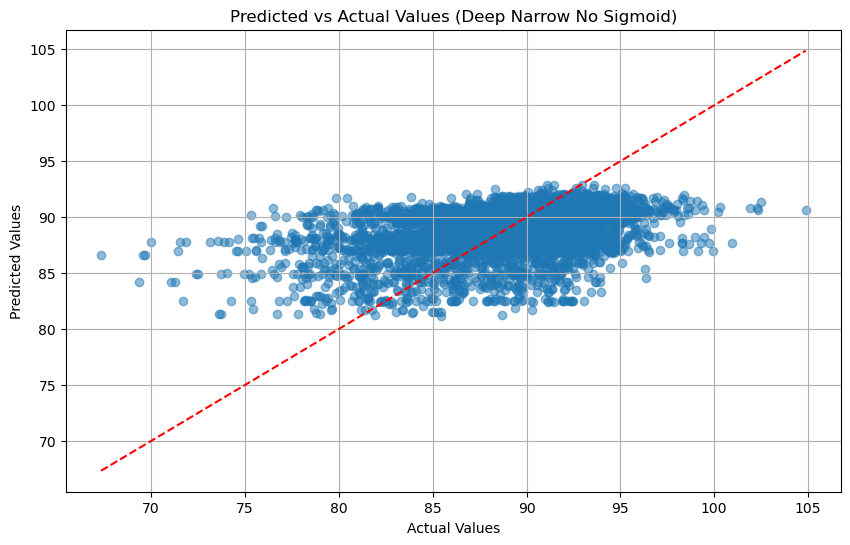

Results for Modified Sigmoid (65-100):
  R² Score: -340701.4079
  Mean Absolute Error: 2418.3936
  Root Mean Squared Error: 2418.3970


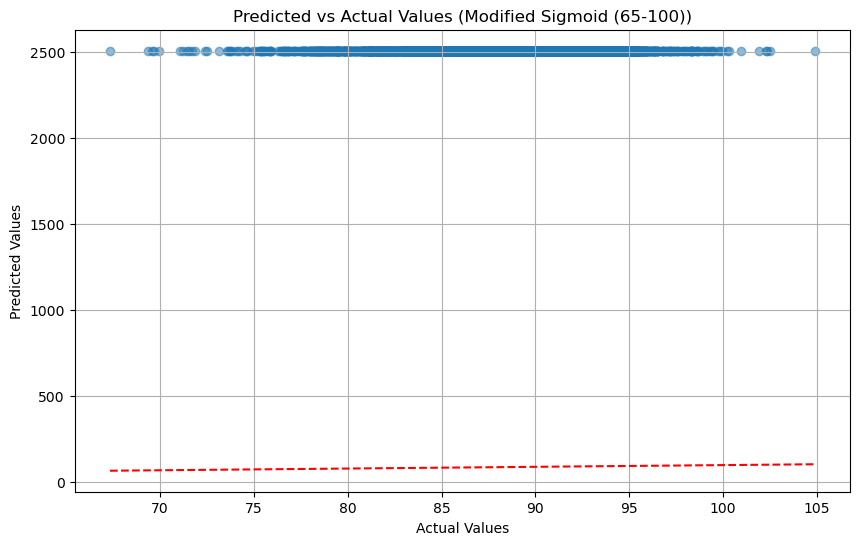

Results for Breadth Loss Model:
  R² Score: 0.1843
  Mean Absolute Error: 2.8578
  Root Mean Squared Error: 3.7419


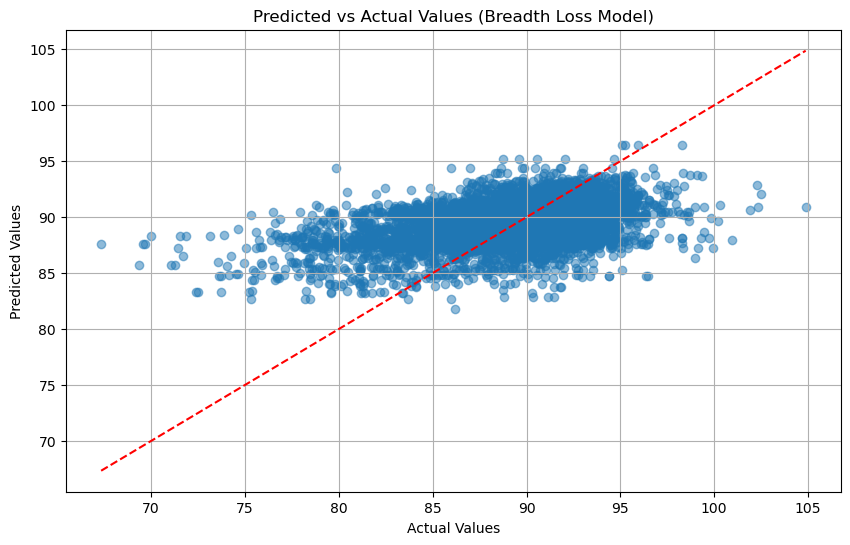

Results for LR Scheduler Model:
  R² Score: 0.1567
  Mean Absolute Error: 2.8721
  Root Mean Squared Error: 3.8049


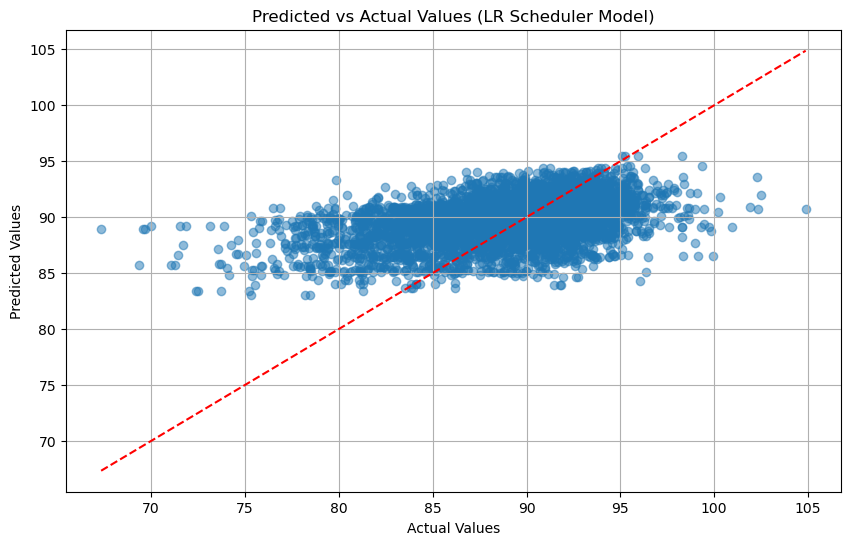

Results for RMSprop Optimizer:
  R² Score: 0.1107
  Mean Absolute Error: 2.9254
  Root Mean Squared Error: 3.9071


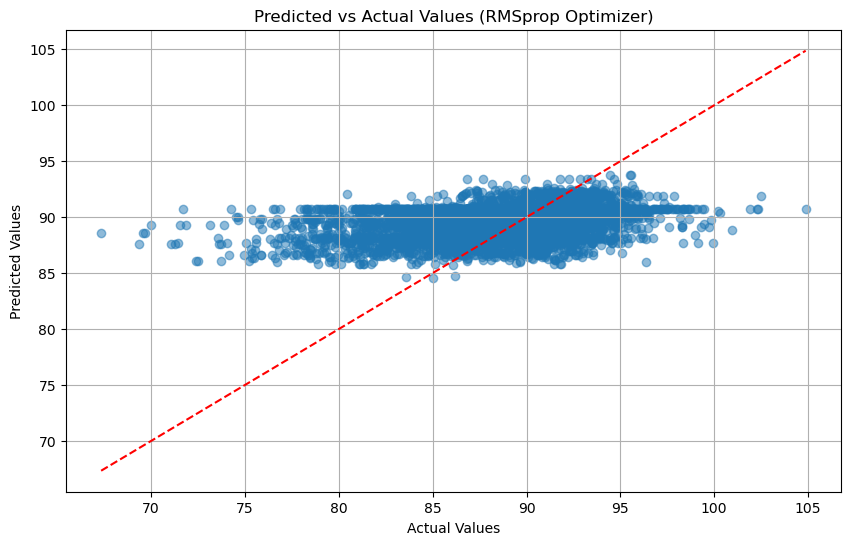

Results for Adagrad Optimizer:
  R² Score: 0.0700
  Mean Absolute Error: 3.0434
  Root Mean Squared Error: 3.9957


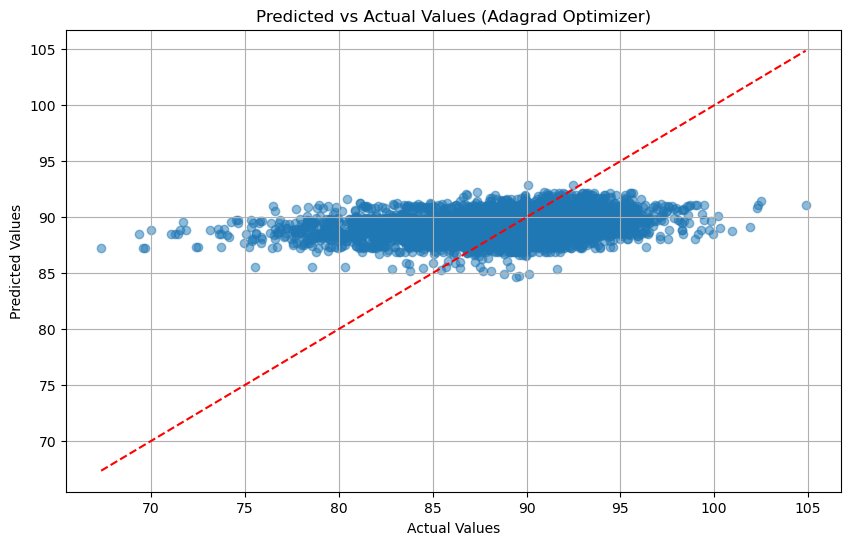

In [20]:
for result in results:
    print(f"Results for {result['model_name']}:")
    print(f"  R² Score: {result['r2']:.4f}")
    print(f"  Mean Absolute Error: {result['mae']:.4f}")
    print(f"  Root Mean Squared Error: {result['rmse']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(result['y_true'], result['y_pred'], alpha=0.5)
    plt.plot([min(result['y_true']), max(result['y_true'])], [min(result['y_true']), max(result['y_true'])], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f"Predicted vs Actual Values ({result['model_name']})")
    plt.grid(True)
    plt.show()

#### v4:

In [ ]:
models = []
model_names = []
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Create DataLoaders with the new EconDataset
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")
val_dataset = EconDataset(val_data, "State", "Industry", "Unemployment Rate", "Response")
input_size = len(train_dataset[0][0])
bs = 128

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

train_dataloaders.append(train_dataloader)
test_dataloaders.append(test_dataloader)
val_dataloaders.append(val_dataloader)


# 1. Baseline SurvivalRateModel
model_baseline = SurvivalRateModel(input_size=input_size, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_baseline)
model_names.append("Baseline SurvivalRateModel")

# 2. Embedded SurvivalRateModel
model_baseline = SurvivalRateModel_Embeddings(num_states=51, num_industries=19, hidden_size1=256, hidden_size2=128, dropout=0.1)
models.append(model_baseline)
model_names.append("Baseline SurvivalRateModel")

# 3-5. Breadth Loss Model
class BreadthLossModel(SurvivalRateModel):
    def train_step(self, x, y, criterion, optimizer, breadth_lambda=0.01):
        optimizer.zero_grad()
        outputs = self(x)
        loss = criterion(outputs, y)
        breadth_loss = -torch.std(outputs)
        total_loss = loss + breadth_lambda * breadth_loss
        total_loss.backward()
        optimizer.step()
        return total_loss.item()

    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.001, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False, optimizer=None, breadth_lambda=0.01):
        return super().train_loop(dataloader, num_epochs, learning_rate, device=device, suppress=suppress, optimizer=optimizer, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb)

model_breadth_loss_low = BreadthLossModel(hidden_size1=256, hidden_size2=128)
models.append(model_breadth_loss_low)
model_names.append("Breadth Loss Low Model")

model_breadth_loss_med = BreadthLossModel(hidden_size1=256, hidden_size2=128)
models.append(model_breadth_loss_med)
model_names.append("Breadth Loss Med Model")

model_breadth_loss_high = BreadthLossModel(hidden_size1=256, hidden_size2=128)
models.append(model_breadth_loss_high)
model_names.append("Breadth Loss High Model")

# 6. Breadth Loss Embeddings
class BreadthLossModelEmbed(SurvivalRateModel_Embeddings):
    def train_step(self, x, y, criterion, optimizer, breadth_lambda=0.01):
        optimizer.zero_grad()
        outputs = self(x)
        loss = criterion(outputs, y)
        breadth_loss = -torch.std(outputs)
        total_loss = loss + breadth_lambda * breadth_loss
        total_loss.backward()
        optimizer.step()
        return total_loss.item()

    def train_loop(self, dataloader, num_epochs=150, learning_rate=0.001, device="cpu", val_dataloader=None, suppress=False, patience=40, uses_wandb=False, optimizer=None, breadth_lambda=0.01):
        return super().train_loop(dataloader, num_epochs, learning_rate, device=device, suppress=suppress, optimizer=optimizer, val_dataloader=val_dataloader, patience=patience, uses_wandb=uses_wandb)

model_breadth_embed = BreadthLossModelEmbed(num_states=51, num_industries=19, hidden_size1=256, hidden_size2=128)
models.append(model_breadth_embed)
model_names.append("Model Breadth Embed Model")

results = []

for i, model in enumerate(models):
    print(f"Training {model_names[i]}...")
    if isinstance(model, BreadthLossModel):
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=True,
            patience=50,
            breadth_lambda=0.01 * 10^(i-2)  # Pass breadth_lambda for BreadthLossModel
        )
    elif isinstance(model, BreadthLossModelEmbed):
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=True,
            patience=50,
        )
    else:
        train_loss_cache, val_loss_cache = model.train_loop(
            train_dataloaders[0],
            num_epochs=num_epochs,
            learning_rate=0.001,
            device=device,
            val_dataloader=val_dataloaders[0],
            suppress=False,
            patience=50,
        )

    y_pred, y_true = model.evaluate(test_dataloaders[0], device=device)

    # Denormalize predictions and actual values
    y_pred_denorm = train_dataset.denormalize_response(y_pred)
    y_true_denorm = train_dataset.denormalize_response(y_true)

    r2 = r2_score(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))

    results.append({
        "model_name": model_names[i],
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "y_pred": y_pred_denorm,
        "y_true": y_true_denorm,
    })


TypeError: SurvivalRateModel.__init__() missing 1 required positional argument: 'dropout'